In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
from preprocessing import *
from lstm import *

# Data Collection/Preprocessing

## Resp_by_state_2023 ('resp')
- Combined: COVID-19 + Influenza + RSV; Combined 없애도 될 듯
- 기상청 데이터 by date 

In [2]:
os.getcwd()
image_folder = "Figures/"

In [3]:
data = pd.read_csv("Resp_by_state_2023.csv")
data['pathogen'].value_counts()
data['week_end'] = pd.to_datetime(data['week_end'])  
data['month_year'] = data['week_end'].dt.to_period('M')

In [4]:
data[data['week_end']=='2022-10-08']

week_end  pathogen      geography  percent_visits     status  \
236 2022-10-08  COVID-19        Alabama             1.0  Reporting   
237 2022-10-08  COVID-19         Alaska             1.3  Reporting   
238 2022-10-08  COVID-19        Arizona             1.6  Reporting   
239 2022-10-08  COVID-19       Arkansas             0.9  Reporting   
240 2022-10-08  COVID-19     California             1.1  Reporting   
..         ...       ...            ...             ...        ...   
467 2022-10-08  Combined       Virginia             3.7  Reporting   
468 2022-10-08  Combined     Washington             2.7  Reporting   
469 2022-10-08  Combined  West Virginia             3.1  Reporting   
470 2022-10-08  Combined      Wisconsin             2.4  Reporting   
471 2022-10-08  Combined        Wyoming             2.5  Reporting   

    trend_on_date recent_trend month_year  
236    Decreasing    No Change    2022-10  
237    Decreasing   Decreasing    2022-10  
238     No Change   Decreasing    2022-10  
239    Decreasing    No Change    2022-10  
240    Decreasing   Decreasing    2022-10  
..            ...          ...        ...  
467    Decreasing   Increasing    2022-10  
468    Decreasing   Decreasing    2022-10  
469    Decreasing   Increasing    2022-10  
470    Decreasing   Increasing    2022-10  
471     No Change    No Change    2022-10  

[236 rows x 8 columns]

In [5]:
data.sort_values(by='week_end', ascending=True, inplace=True)

percent_visits (mean), status, trend_on_date, recent_trend (mode)

In [6]:
grouped_data = data.groupby(['month_year', 'pathogen', 'geography']).agg(
    percent_visits=('percent_visits', 'mean'),
    status=('status', lambda x: x.mode()[0]),  # Get the most common status
    trend_on_date=('trend_on_date', lambda x: x.mode()[0]),  # Get the most common trend_on_date
    recent_trend=('recent_trend', lambda x: x.mode()[0])  # Get the most common recent_trend
).reset_index()

grouped_data

month_year  pathogen      geography  percent_visits     status  \
0       2022-10  COVID-19        Alabama            0.94  Reporting   
1       2022-10  COVID-19         Alaska            1.32  Reporting   
2       2022-10  COVID-19        Arizona            1.76  Reporting   
3       2022-10  COVID-19       Arkansas            0.94  Reporting   
4       2022-10  COVID-19     California            1.08  Reporting   
...         ...       ...            ...             ...        ...   
5419    2024-08       RSV        Vermont            0.00  Reporting   
5420    2024-08       RSV       Virginia            0.00  Reporting   
5421    2024-08       RSV     Washington            0.00  Reporting   
5422    2024-08       RSV  West Virginia            0.00  Reporting   
5423    2024-08       RSV      Wisconsin            0.00  Reporting   

     trend_on_date recent_trend  
0       Decreasing    No Change  
1       Decreasing   Decreasing  
2       Increasing   Decreasing  
3       Decreasing    No Change  
4       Decreasing   Decreasing  
...            ...          ...  
5419     No Change    No Change  
5420     No Change    No Change  
5421     No Change    No Change  
5422     No Change    No Change  
5423     No Change    No Change  

[5424 rows x 7 columns]

#### Remove 'Region' - Focusing on state level & Remove "Combined" on Pathogen

In [7]:
resp = grouped_data[(~grouped_data['geography'].str.startswith("Region")) & (grouped_data['pathogen'] != "Combined")]

#### Turn date into datetime

In [8]:
resp = resp.rename(columns={'month_year': 'Date'})
resp['Date'] = resp['Date'].astype(str) + '-01'
resp['Date'] = pd.to_datetime(resp['Date'], format='%Y-%m-%d')
resp

Date  pathogen      geography  percent_visits     status  \
0    2022-10-01  COVID-19        Alabama            0.94  Reporting   
1    2022-10-01  COVID-19         Alaska            1.32  Reporting   
2    2022-10-01  COVID-19        Arizona            1.76  Reporting   
3    2022-10-01  COVID-19       Arkansas            0.94  Reporting   
4    2022-10-01  COVID-19     California            1.08  Reporting   
...         ...       ...            ...             ...        ...   
5419 2024-08-01       RSV        Vermont            0.00  Reporting   
5420 2024-08-01       RSV       Virginia            0.00  Reporting   
5421 2024-08-01       RSV     Washington            0.00  Reporting   
5422 2024-08-01       RSV  West Virginia            0.00  Reporting   
5423 2024-08-01       RSV      Wisconsin            0.00  Reporting   

     trend_on_date recent_trend  
0       Decreasing    No Change  
1       Decreasing   Decreasing  
2       Increasing   Decreasing  
3       Decreasing    No Change  
4       Decreasing   Decreasing  
...            ...          ...  
5419     No Change    No Change  
5420     No Change    No Change  
5421     No Change    No Change  
5422     No Change    No Change  
5423     No Change    No Change  

[3378 rows x 7 columns]

#### Find NA 

In [9]:
def NA(df):
    na_results = {}
    for col in df.columns:
        na = df[col].isna()
        na_results[col] = na 
        print(f'{col} NA = {na.sum()}')

In [10]:
na_results = {}
for col in resp.columns:
    na = resp[col].isna()
    na_results[col] = na 
    print(f'{col} NA = {na.sum()}')

Date NA = 0
pathogen NA = 0
geography NA = 0
percent_visits NA = 0
status NA = 0
trend_on_date NA = 0
recent_trend NA = 0


In [11]:
resp = resp.rename(columns=
            {'geography': 'State',
             'pathogen': 'Pathogen',
             'status': 'Status'})
resp = resp[resp['State'] != 'National']

In [12]:
resp_state = resp['State'].unique()
resp_state

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Montana',
       'Nebraska', 'Nevada', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

#### Descriptive

#### All states (FacetGrid)
- Mean for multiple rows in each date in each state

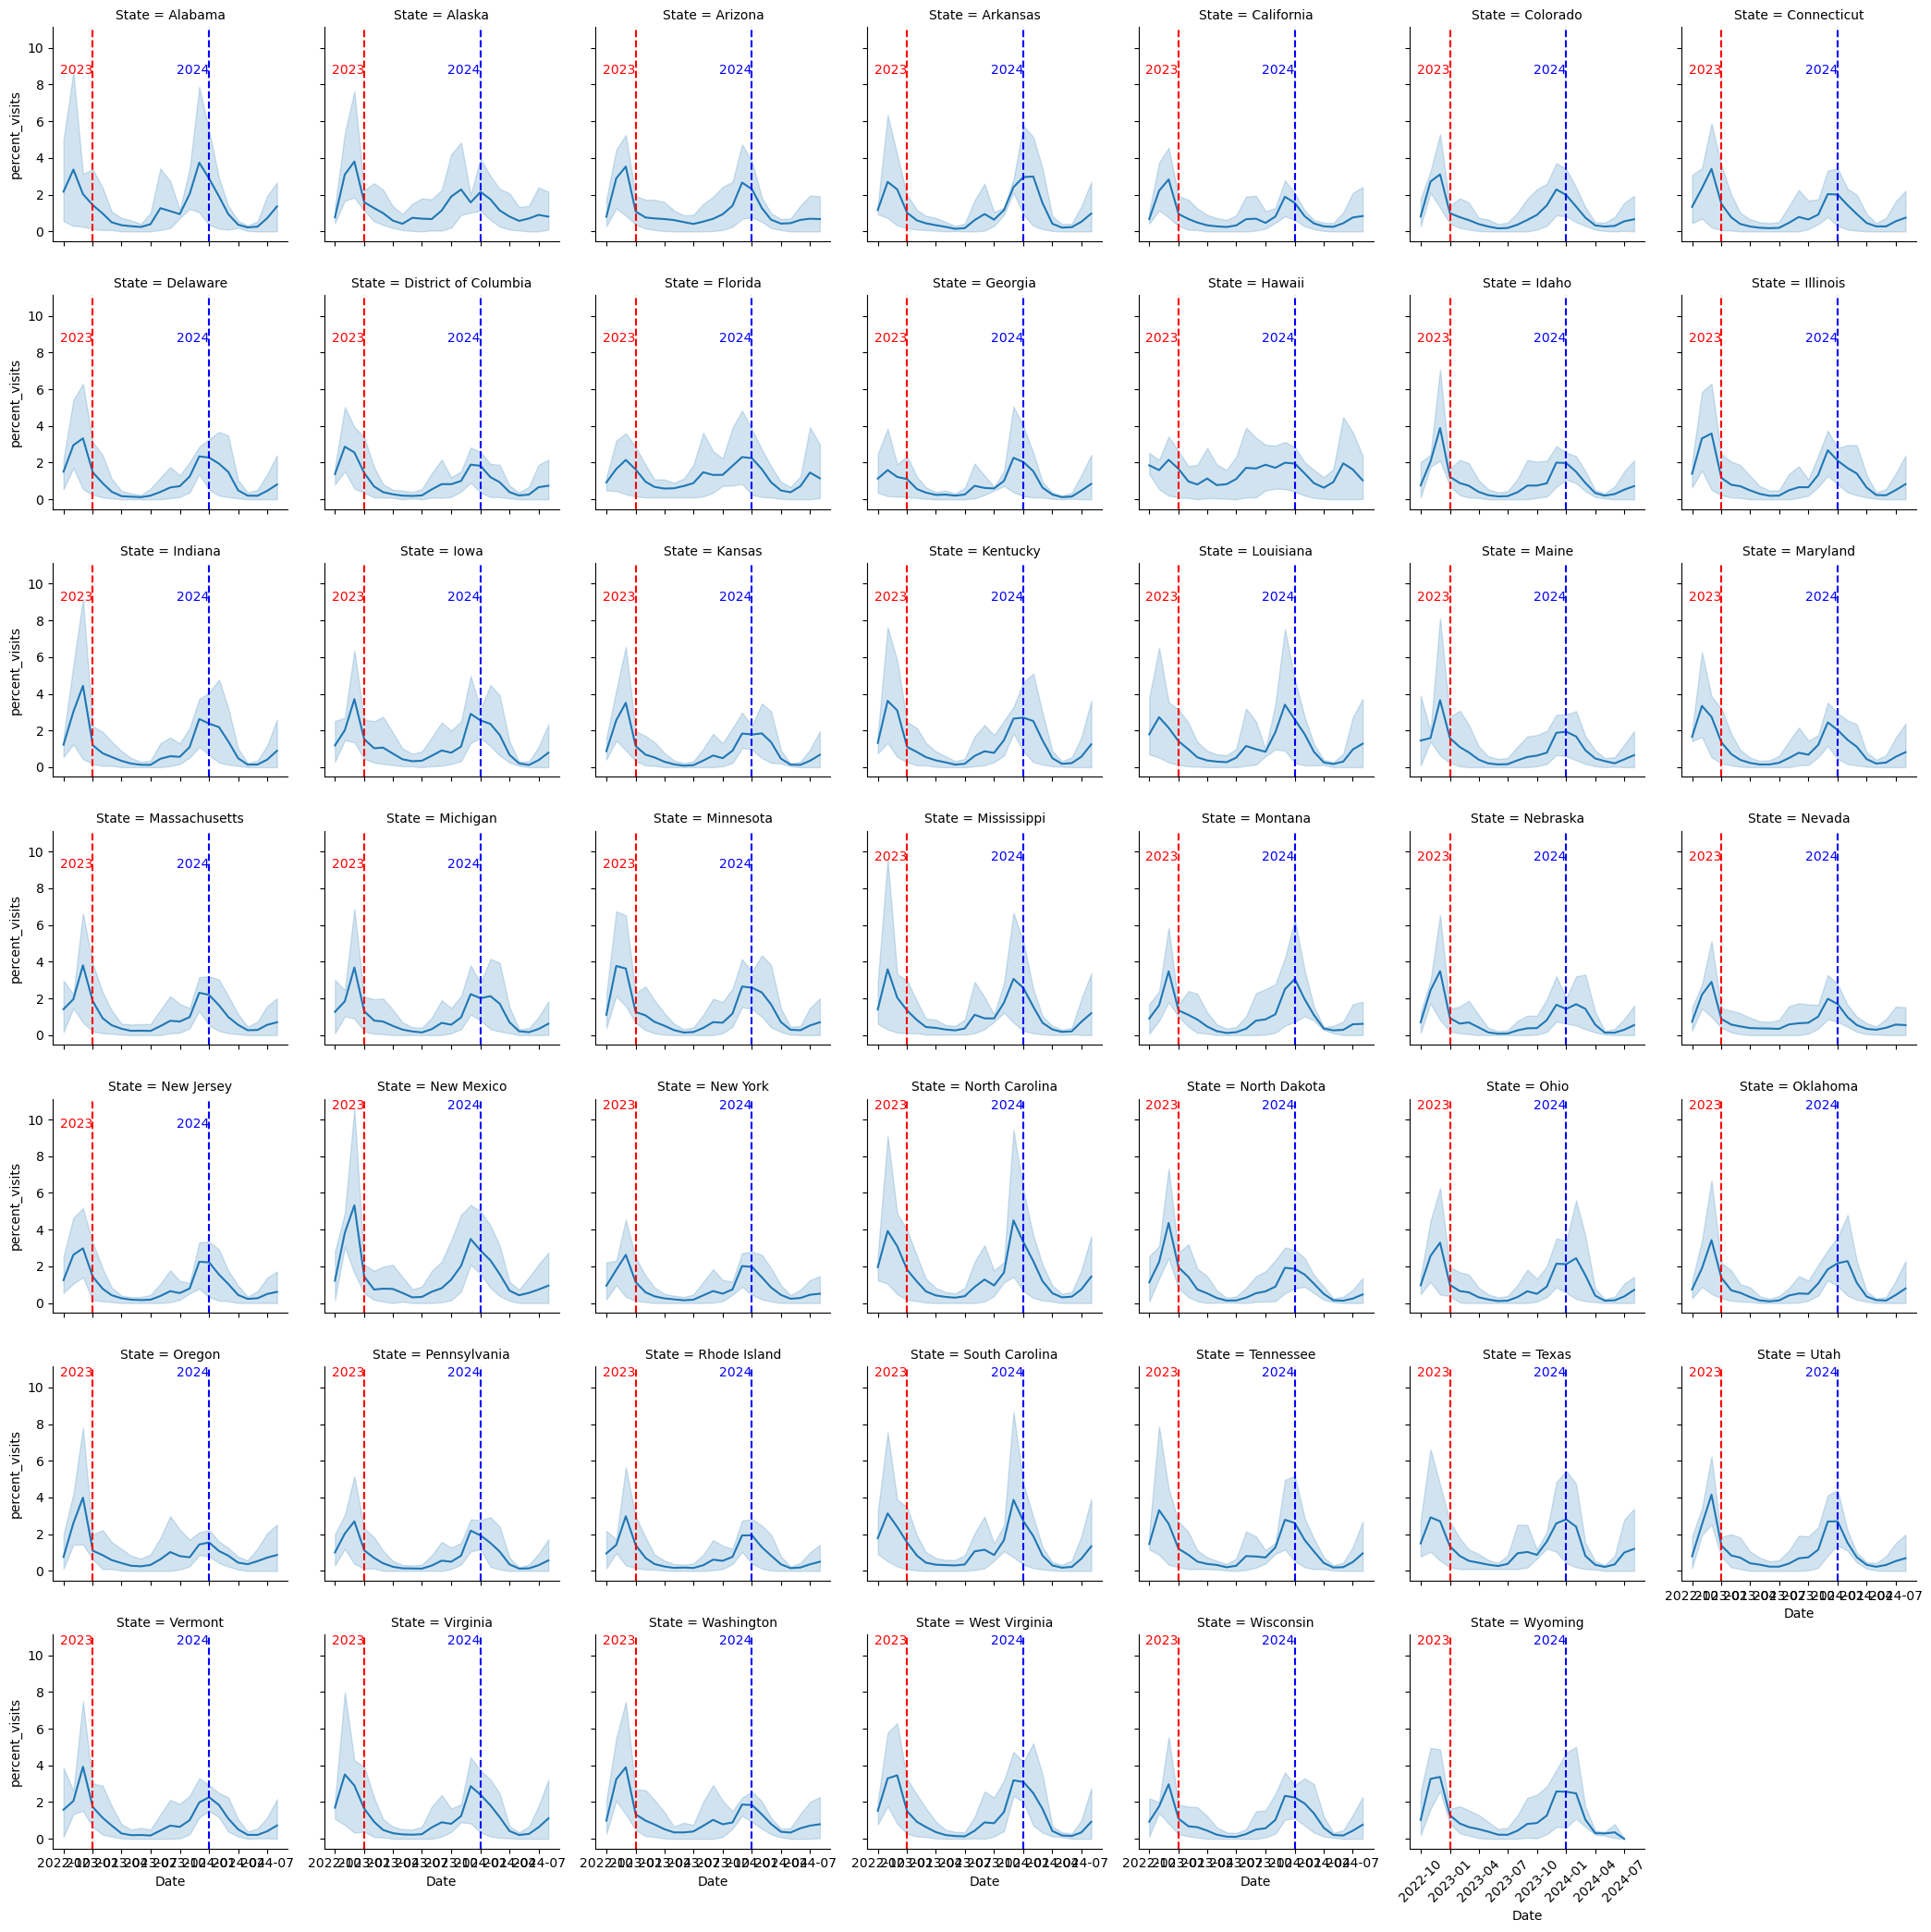

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

image_folder = "Figures/"

def plot_with_year_lines(x, y, **kwargs):
    sns.lineplot(x=x, y=y, **kwargs)
    # Add vertical lines for the start of each year
    plt.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--')
    plt.axvline(pd.Timestamp('2024-01-01'), color='blue', linestyle='--')
    
    plt.text(pd.Timestamp('2023-01-01'), plt.ylim()[1], '2023', color='red', ha='right', va='top')
    plt.text(pd.Timestamp('2024-01-01'), plt.ylim()[1], '2024', color='blue', ha='right', va='top')

g = sns.FacetGrid(resp, col="State", col_wrap=7, height=3)
g.map(plot_with_year_lines, "Date", "percent_visits")

plt.xticks(rotation=45)
plt.tight_layout()

image_path = os.path.join(image_folder, "statewise_percent_visits.png")
plt.savefig(image_path, dpi=300, bbox_inches='tight')
plt.show()

#### Top 5 States: Each State Focused
- Hawaii less clear: probably it has has a tropical climates with two primary seasons (may-oct & nov-apr)
- COVID seems to be less relevant to 'season' than RSV and Influenza

In [14]:
a = resp.groupby(['State', 'Date'])['percent_visits'].mean().reset_index()
top_5 = a.groupby('State')['percent_visits'].mean().reset_index().sort_values(by='percent_visits', ascending=False).head(5)

In [15]:
top_5.reset_index()

index           State  percent_visits
0     29      New Mexico        1.460290
1     31  North Carolina        1.453696
2     11          Hawaii        1.404420
3      1          Alaska        1.321377
4      0         Alabama        1.282029

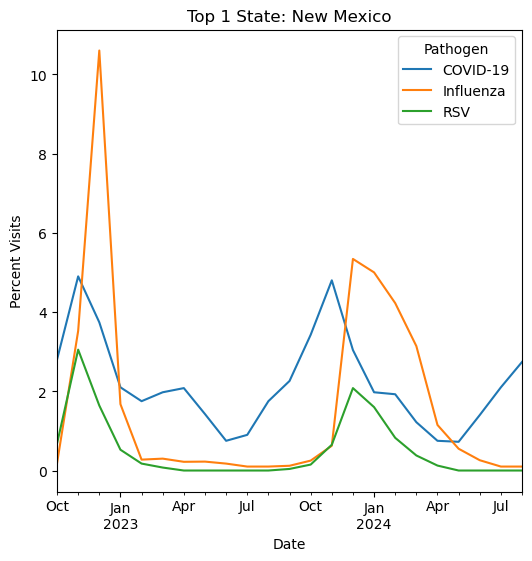

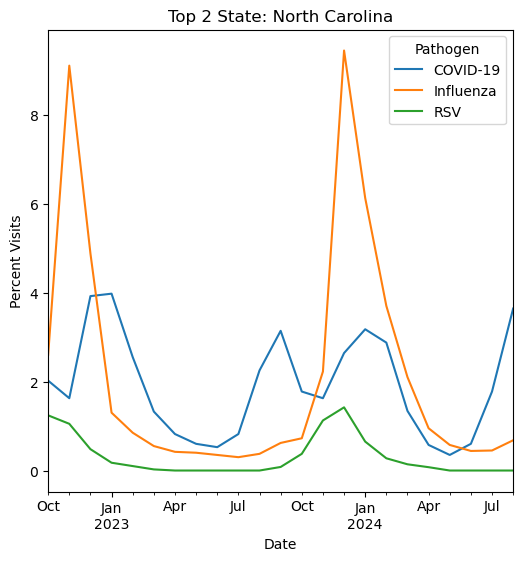

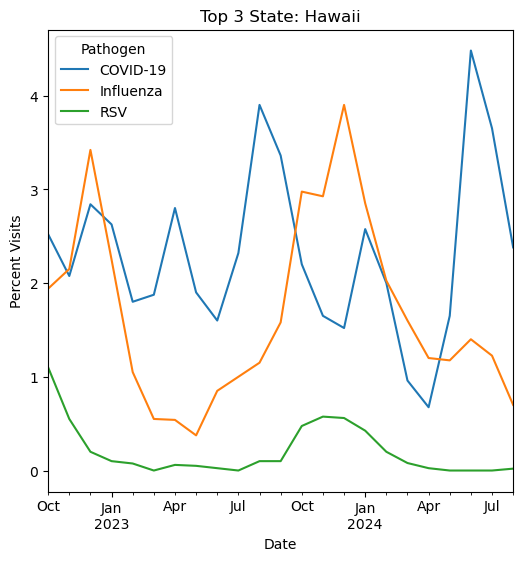

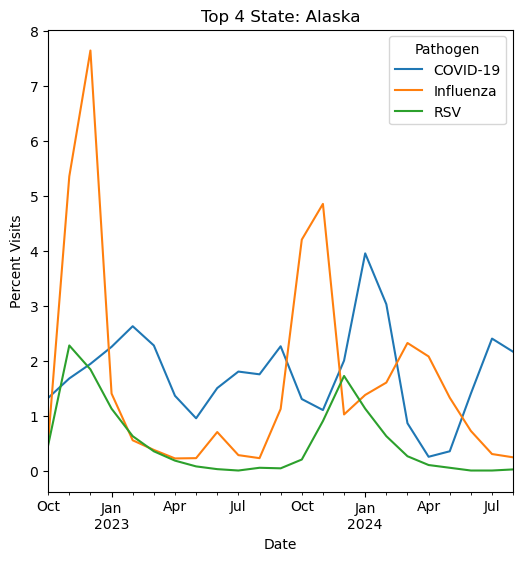

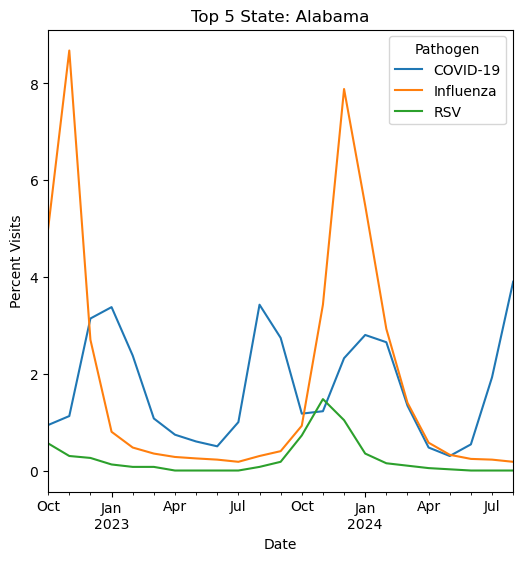

In [16]:
index = 1 

for _, row in top_5.iterrows():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    state = row['State']
    
    for label, grp in resp[resp['State'] == state].groupby('Pathogen'):
        grp.plot(x = 'Date', y = 'percent_visits',ax = ax, label = label)
    
    ax.set_title(f'Top {index} State: {state}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Percent Visits')
    ax.legend(title='Pathogen')

    index += 1
    image_path = os.path.join(image_folder, f"top_state_{index}_{state}.png")
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    plt.show()

#### Top 5 States: Each Pathogen
- Compared to Influenza & RSV, COVID is shown to be more fluctuating
- Influenza & RSV: Shown to be high in winter
- But generally all shown to be high in winter: viruses could spread more easily in cold temperature/ people's reduced immune system response/ co-occurence with other viruses/ indoor activity/ 

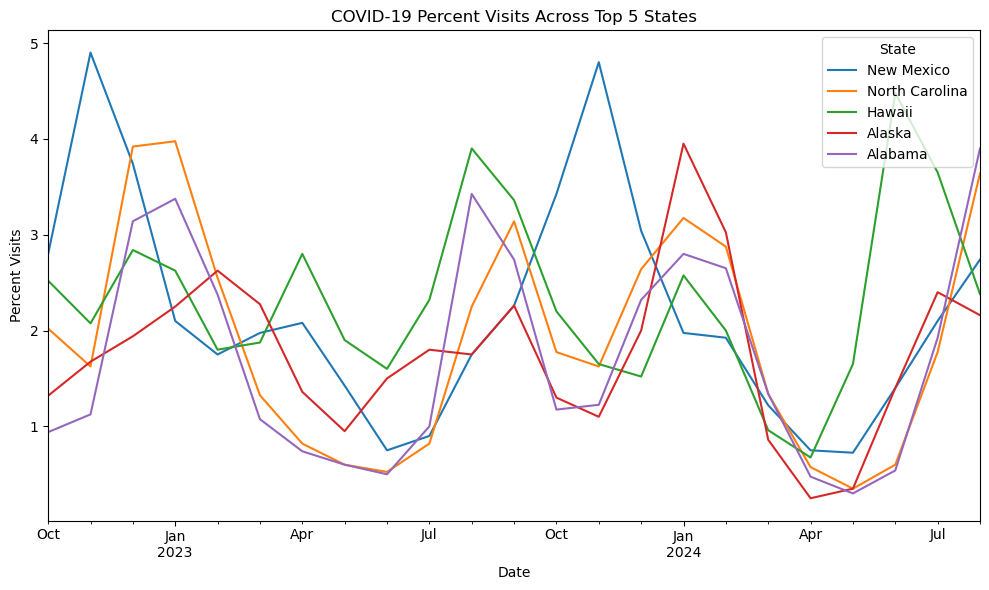

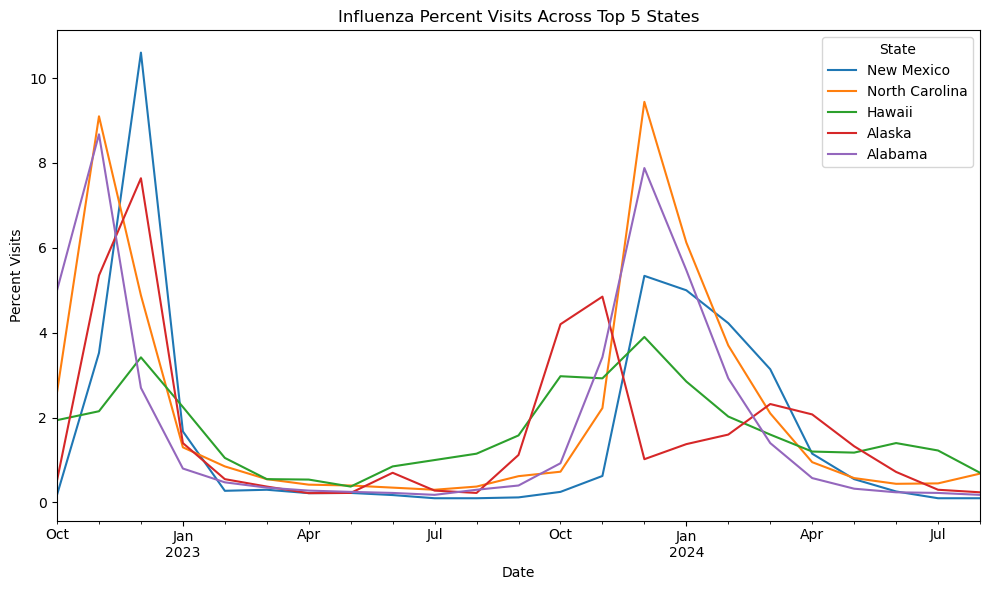

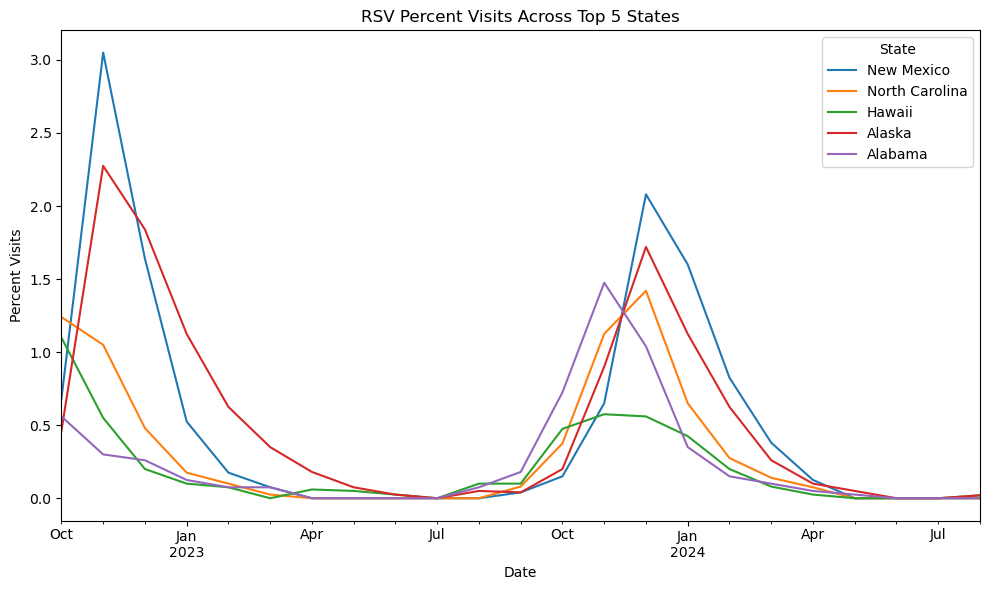

In [17]:
pathogens = resp['Pathogen'].unique()  

for pathogen in pathogens:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter the data for each pathogen and top 5 states
    for _, row in top_5.iterrows():
        state = row['State']
        state_data = resp[(resp['State'] == state) & (resp['Pathogen'] == pathogen)]
        
        # Plot the data for each state
        state_data.plot(x='Date', y='percent_visits', ax=ax, label=state)
    
    ax.set_title(f'{pathogen} Percent Visits Across Top 5 States')
    ax.set_xlabel('Date')
    ax.set_ylabel('Percent Visits')
    ax.legend(title='State')

    plt.tight_layout()
    plt.show()

## Weather Data (NOAA Bulk)
- "PRCP" = Total Monthly Precipitation
- "RHAV" = Monthly Average Relative Humidity
- "SNOW" = Total Monthly Snowfall
- "TAVG" = Average Monthly Temperature. 

In [18]:
import os
import pandas as pd

os.chdir('/Users/jeonseo/Desktop/QMSS/Fall 2024/Thesis')

temp_directory = './temperature'

columns_to_select = ['EVAP', 'PRCP', 'RHAV', 'SNOW', 'TAVG', 'TMAX', 'TMIN']

combined_df = pd.DataFrame()

# Iterate over all CSV files in the directory
for filename in os.listdir(temp_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(temp_directory, filename)

        df = pd.read_csv(file_path)

        # Date 
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
        df = df[df['DATE'] >= '2022-10-01']

        location = filename.replace('.csv', '')
        df['LOCATION'] = location

        selected_columns = ['DATE'] + [col for col in columns_to_select if col in df.columns] + ['LOCATION']
        df = df[selected_columns]

        combined_df = pd.concat([combined_df, df], ignore_index=True)


print(combined_df.head())

combined_df.to_csv('combined_temperature_data.csv', index=False)

        DATE  EVAP   PRCP  RHAV  SNOW   TAVG   TMAX   TMIN LOCATION
0 2022-10-01   NaN   23.6  71.0   0.0  18.51  25.02  12.01  georgia
1 2022-11-01   NaN   49.0  71.0   0.0  16.58  21.94  11.21  georgia
2 2022-12-01   NaN   44.3  66.0   0.0  11.76  17.22   6.29  georgia
3 2023-01-01   NaN  115.8  67.0   0.0  13.18  19.46   6.89  georgia
4 2023-02-01   NaN   69.6  69.0   0.0  17.20  23.54  10.85  georgia


In [19]:
weather = combined_df
weather = weather.rename(columns={'DATE': 'Date',
                        'PRCP': 'Precipitation',
                        'RHAV': 'Humidity',
                        'SNOW': 'Snowfall',
                        'TAVG': 'Temperature',
                         'LOCATION': 'State'})

Select these columns

In [20]:
weather = weather[['Date', 'Precipitation', 'Humidity', 'Snowfall', 'Temperature', 'State']]
weather_state = weather['State'].unique()

Change districtofcolumbia into district of columbia

In [21]:
weather['State'] = weather['State'].replace('districtofcolumbia', 'district of columbia')
weather_state = weather['State'].unique()

In [22]:
weather_state = [state.lower() for state in weather_state]
resp_state = [state.lower() for state in resp_state]

print(f'States that we miss in total: {set(weather_state) - set(resp_state)}')  # In only weahter dataset 

States that we miss in total: {'new hampshire', 'south dakota', 'missouri'}


#### Remove 'Missouri', 'South Dakota', 'New Hampshire'

In [23]:
weather['State'] = weather['State'].str.lower()

In [24]:
weather = weather[~weather['State'].isin(['missouri', 'south dakota', 'new hampshire'])]

In [25]:
weather_list = [state for state in weather['State'].unique()]

In [26]:
weather

Date  Precipitation  Humidity  Snowfall  Temperature         State
0    2022-10-01           23.6      71.0       0.0        18.51       georgia
1    2022-11-01           49.0      71.0       0.0        16.58       georgia
2    2022-12-01           44.3      66.0       0.0        11.76       georgia
3    2023-01-01          115.8      67.0       0.0        13.18       georgia
4    2023-02-01           69.6      69.0       0.0        17.20       georgia
...         ...            ...       ...       ...          ...           ...
1168 2024-04-01           94.0      69.0       0.0         9.27  rhode island
1169 2024-05-01          192.3       NaN       0.0        15.33  rhode island
1170 2024-06-01          145.1       NaN       0.0        21.43  rhode island
1171 2024-07-01           90.8       NaN       0.0        24.03  rhode island
1172 2024-08-01          123.1       NaN       0.0        21.71  rhode island

[1104 rows x 6 columns]

#### Find NA & Fill with Mean 

In [27]:
for col in weather.columns:
    if weather[col].isna().sum() > 0:
        weather[col] = weather[col].fillna(weather[col].mean())

In [28]:
na_results = {}
for col in weather.columns:
    na = weather[col].isna()
    na_results[col] = na 
    print(f'{col} NA = {na.sum()}')

Date NA = 0
Precipitation NA = 0
Humidity NA = 0
Snowfall NA = 0
Temperature NA = 0
State NA = 0


#### Merged

In [29]:
resp['State'] = resp['State'].str.lower()
merged = resp.merge(weather, on=['Date', 'State'])
merged.to_csv("Merged_resp_weather")

In [30]:
merged.drop(columns=['trend_on_date'], inplace=True)

## Mobility (BTS: Bureau of Transporation Statistics)
- https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv/about_data
- Average all columns within same state in a same day
- Then, average daily to compute monthly data by state
- Extrapolate the future values 

In [31]:
mob_directory = './Mobility'

for filename in os.listdir(mob_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(mob_directory, filename)  # Use mob_directory
        mob = pd.read_csv(file_path)

In [32]:
mob['Date'] = pd.to_datetime(mob['Date'])  

In [33]:
mobility = mob[mob['Date'] >= '2022-10-01']  
mobility.drop(['Level', 'Row ID', 'Week', 'County FIPS'], axis=1, inplace=True)
mobility.sort_values(by='Date', ascending=True)
mobility.to_csv("mobility.csv")

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_9681/1189304993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobility.drop(['Level', 'Row ID', 'Week', 'County FIPS'], axis=1, inplace=True)


In [34]:
mobility = pd.read_csv('mobility.csv', index_col = 0)

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_9681/1396557541.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mobility = pd.read_csv('mobility.csv', index_col = 0)


In [35]:
mobility.head()

Date  State FIPS State Postal Code                 County Name  \
3519475  2022-10-09         2.0                AK  Lake and Peninsula Borough   
3839190  2022-11-13         1.0                AL                Henry County   
3839191  2022-11-13         1.0                AL              Houston County   
3839192  2022-11-13         1.0                AL              Jackson County   
3839193  2022-11-13         1.0                AL            Jefferson County   

         Population Staying at Home  Population Not Staying at Home  \
3519475                         NaN                             NaN   
3839190                      2338.0                         14867.0   
3839191                     18430.0                         87452.0   
3839192                      8086.0                         43540.0   
3839193                    143790.0                        514783.0   

         Number of Trips  Number of Trips <1  Number of Trips 1-3  \
3519475              NaN                 NaN                  NaN   
3839190          60688.0             12608.0               9141.0   
3839191         341465.0             81345.0              73782.0   
3839192         163643.0             27154.0              27895.0   
3839193        1740097.0            427561.0             383236.0   

         Number of Trips 3-5  Number of Trips 5-10  Number of Trips 10-25  \
3519475                  NaN                   NaN                    NaN   
3839190               5356.0               11106.0                14862.0   
3839191              52062.0               65669.0                46877.0   
3839192              18094.0               33348.0                38301.0   
3839193             225427.0              298351.0               287740.0   

         Number of Trips 25-50  Number of Trips 50-100  \
3519475                    NaN                     NaN   
3839190                 5801.0                   838.0   
3839191                10814.0                  7267.0   
3839192                14518.0                  2783.0   
3839193                65547.0                 25460.0   

         Number of Trips 100-250  Number of Trips 250-500  \
3519475                      NaN                      NaN   
3839190                    900.0                     58.0   
3839191                   2890.0                    563.0   
3839192                   1218.0                    299.0   
3839193                  21166.0                   4132.0   

         Number of Trips >=500  Month  
3519475                    NaN     10  
3839190                   18.0     11  
3839191                  196.0     11  
3839192                   33.0     11  
3839193                 1477.0     11

In [36]:
mob_cat = ['State FIPS', 'State Postal Code', 'County Name', 'Month'] 
columns_to_exclude = mob_cat + ['Date']
grouped_mobility = mobility.groupby(['Date', 'State Postal Code']).agg({col: 'mean' for col in mobility.columns if col not in columns_to_exclude}).reset_index()

In [37]:
grouped_mobility['Date'] = pd.to_datetime(grouped_mobility['Date'])

monthly_mean_mobility = grouped_mobility.groupby(
    [grouped_mobility['Date'].dt.to_period('M'), 'State Postal Code']
).agg(
    {col: 'mean' for col in grouped_mobility.columns if col not in ['Date','State Postal Code']}
).reset_index()

monthly_mean_mobility['Date'] = monthly_mean_mobility['Date'].dt.to_timestamp()
monthly_mean_mobility.tail(10)

Date State Postal Code  Population Staying at Home  \
959 2024-04-01                SD                 4990.502488   
960 2024-04-01                TN                26658.609375   
961 2024-04-01                TX                44254.202614   
962 2024-04-01                UT                46687.011111   
963 2024-04-01                VA                25801.027363   
964 2024-04-01                VT                16458.644444   
965 2024-04-01                WA                85402.941667   
966 2024-04-01                WI                30272.641553   
967 2024-04-01                WV                13062.151786   
968 2024-04-01                WY                10276.888889   

     Population Not Staying at Home  Number of Trips  Number of Trips <1  \
959                    21417.228856     1.163223e+05        35517.084577   
960                   115615.848958     5.459453e+05       137265.265625   
961                   183164.471895     8.147342e+05       226205.994118   
962                   167043.522222     8.454425e+05       226475.322222   
963                   101594.778607     5.492021e+05       165819.324627   
964                    66739.888889     3.650684e+05        89514.544444   
965                   295341.708333     1.400404e+06       395576.483333   
966                   129246.098174     6.780688e+05       185401.760274   
967                    50943.098214     2.473598e+05        63335.776786   
968                    37953.027778     2.209296e+05        69743.638889   

     Number of Trips 1-3  Number of Trips 3-5  Number of Trips 5-10  \
959         28246.402985         13028.480100          15262.537313   
960        121114.746528         65097.838542          88308.732639   
961        182549.726797         93874.947059         123124.849020   
962        194294.955556        104078.433333         137501.344444   
963        128669.644279         62517.139303          80560.135572   
964         85271.577778         43079.544444          54489.922222   
965        309639.237500        159433.883333         217373.637500   
966        155194.728311         77879.929224         101866.787671   
967         58119.741071         29613.363095          38630.827381   
968         60782.020833         26953.895833          22040.826389   

     Number of Trips 10-25  Number of Trips 25-50  Number of Trips 50-100  \
959           14039.420398            6009.375622             2738.126866   
960           90594.192708           27435.307292             8771.420139   
961          126402.740523           40950.826144            13030.758170   
962          118308.977778           42101.294444            13540.755556   
963           77206.703980           23267.946517             7261.844527   
964           62544.177778           21943.000000             5680.144444   
965          217647.445833           67965.525000            19604.100000   
966          101257.719178           35881.171233            13311.363014   
967           36585.857143           13460.413690             5212.360119   
968           18433.486111           13486.020833             5980.381944   

     Number of Trips 100-250  Number of Trips 250-500  Number of Trips >=500  
959              1203.529851               181.587065              95.716418  
960              5399.536458              1368.029514             590.239583  
961              6037.716993              1477.658824            1078.950327  
962              6312.188889              1643.250000            1185.944444  
963              2778.021144               752.751244             368.595771  
964              1915.155556               408.955556             221.422222  
965              8706.837500              1568.554167            2888.391667  
966              5625.415525              1090.652968             559.257991  
967              1971.991071               331.065476              98.410714  
968              2840.555556               434.4

#### Extrapolation for 2024/05 ~ 08 

In [38]:
import pandas as pd

future_months = pd.date_range(start='2024-05-01', end='2024-08-01', freq='MS')
existing_states = monthly_mean_mobility['State Postal Code'].unique()

future_rows = []
for state in existing_states:
    for month in future_months:
        future_rows.append({'Date': month, 'State Postal Code': state})

future_df = pd.DataFrame(future_rows)
future_df

full_data = pd.concat([monthly_mean_mobility, future_df], ignore_index=True)
full_data.set_index(['Date'], inplace=True)
full_data.reset_index(inplace=True)
full_data.tail(4)

Date State Postal Code  Population Staying at Home  \
1169 2024-05-01                WY                         NaN   
1170 2024-06-01                WY                         NaN   
1171 2024-07-01                WY                         NaN   
1172 2024-08-01                WY                         NaN   

      Population Not Staying at Home  Number of Trips  Number of Trips <1  \
1169                             NaN              NaN                 NaN   
1170                             NaN              NaN                 NaN   
1171                             NaN              NaN                 NaN   
1172                             NaN              NaN                 NaN   

      Number of Trips 1-3  Number of Trips 3-5  Number of Trips 5-10  \
1169                  NaN                  NaN                   NaN   
1170                  NaN                  NaN                   NaN   
1171                  NaN                  NaN                   NaN   
1172                  NaN                  NaN                   NaN   

      Number of Trips 10-25  Number of Trips 25-50  Number of Trips 50-100  \
1169                    NaN                    NaN                     NaN   
1170                    NaN                    NaN                     NaN   
1171                    NaN                    NaN                     NaN   
1172                    NaN                    NaN                     NaN   

      Number of Trips 100-250  Number of Trips 250-500  Number of Trips >=500  
1169                      NaN                      NaN                    NaN  
1170                      NaN                      NaN                    NaN  
1171                      NaN                      NaN                    NaN  
1172                      NaN                      NaN                    NaN

In [39]:
full_data_grouped = full_data.groupby('State Postal Code')
numeric_cols = full_data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    # Interpolate within each state across time (using 'Date' without setting it as index)
    full_data[col] = full_data_grouped[col].transform(lambda group: group.interpolate(method='linear', limit_direction='both'))

In [40]:
extrapolated_data = full_data.copy()

In [41]:
trip = extrapolated_data.rename(columns={
    'State Postal Code': 'State'})
trip.head(2)

Date State  Population Staying at Home  \
0 2022-10-01    AK                14908.311851   
1 2022-10-01    AL                26178.692125   

   Population Not Staying at Home  Number of Trips  Number of Trips <1  \
0                    50850.469874    230348.871620        58282.870150   
1                   118032.631404    547708.313093       121189.157021   

   Number of Trips 1-3  Number of Trips 3-5  Number of Trips 5-10  \
0         62178.914175         33433.961856          35102.770741   
1        116642.406072         72215.044118          97466.356736   

   Number of Trips 10-25  Number of Trips 25-50  Number of Trips 50-100  \
0           24224.585923           10576.701418             3959.639345   
1           92603.943548           30193.500000            11198.751423   

   Number of Trips 100-250  Number of Trips 250-500  Number of Trips >=500  
0               979.785894               901.616943             708.025174  
1              4975.963947              1004.837287             218.352941

In [42]:
trip_state = trip['State'].unique()
trip_state

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

mapping states

In [43]:
state_map = {
    'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AZ': 'Arizona', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MO': 'Missouri', 'MS': 'Mississippi', 'MT': 'Montana', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia',
    'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming'
}

In [44]:
trip['State'] = trip['State'].apply(lambda x: state_map.get(x))

In [45]:
trip_state = [state.lower() for state in trip_state]

Remove missouri, new hampshire, south dakota

In [46]:
trip['State'] = trip['State'].str.lower() 

In [47]:
trip = trip[~trip['State'].isin(['missouri', 'new hampshire', 'south dakota'])]

In [48]:
trip = trip[['Date', 'State', 'Population Staying at Home', 'Population Not Staying at Home', 'Number of Trips']]

In [49]:
trip.to_csv("trip_csv")

In [50]:
merged['State'] = merged['State'].str.lower()

In [51]:
trip

Date          State  Population Staying at Home  \
0    2022-10-01         alaska                14908.311851   
1    2022-10-01        alabama                26178.692125   
2    2022-10-01       arkansas                14380.357810   
3    2022-10-01        arizona               198904.870968   
4    2022-10-01     california               323989.429696   
...         ...            ...                         ...   
1168 2024-08-01  west virginia                13062.151786   
1169 2024-05-01        wyoming                10276.888889   
1170 2024-06-01        wyoming                10276.888889   
1171 2024-07-01        wyoming                10276.888889   
1172 2024-08-01        wyoming                10276.888889   

      Population Not Staying at Home  Number of Trips  
0                       5.085047e+04     2.303489e+05  
1                       1.180326e+05     5.477083e+05  
2                       6.503554e+04     2.945177e+05  
3                       7.109348e+05     3.192398e+06  
4                       1.028061e+06     4.223268e+06  
...                              ...              ...  
1168                    5.094310e+04     2.473598e+05  
1169                    3.795303e+04     2.209296e+05  
1170                    3.795303e+04     2.209296e+05  
1171                    3.795303e+04     2.209296e+05  
1172                    3.795303e+04     2.209296e+05  

[1104 rows x 5 columns]

### Final Df: 'Merged_final.csv'

In [52]:
merged = merged.merge(trip, on=['Date', 'State'])

In [53]:
merged.to_csv("Merged_final.csv")

## Unemployment 
- FRED: https://fred.stlouisfed.org/release?rid=112&t=&et=&pageID=4

In [54]:
import os
import pandas as pd

# Path to the folder containing unemployment CSV files
unemp_file_path = '/Users/jeonseo/Desktop/QMSS/Fall 2024/Thesis/Unemployment'

# Dictionary to map filenames to state names
state_mapping = {
    "TXUR.csv": "Texas", "NJURN.csv": "New Jersey", "LAUR.csv": "Louisiana", "NEUR.csv": "Nebraska",
    "MSUR.csv": "Mississippi", "ALUR.csv": "Alabama", "KYURN.csv": "Kentucky", "OHUR.csv": "Ohio",
    "VAUR.csv": "Virginia", "MNUR.csv": "Minnesota", "NCUR.csv": "North Carolina", "DEUR.csv": "Delaware",
    "KSUR.csv": "Kansas", "ILUR.csv": "Illinois", "MIUR.csv": "Michigan", "WVUR.csv": "West Virginia",
    "ARUR.csv": "Arkansas", "NDUR.csv": "North Dakota", "AKUR.csv": "Alaska", "INUR.csv": "Indiana",
    "CTUR.csv": "Connecticut", "COUR.csv": "Colorado", "UTUR.csv": "Utah", "OKUR.csv": "Oklahoma",
    "DCUR.csv": "District of Columbia", "NYUR.csv": "New York", "MTUR.csv": "Montana", "MOUR.csv": "Missouri",
    "WIUR.csv": "Wisconsin", "PAUR.csv": "Pennsylvania", "ORUR.csv": "Oregon", "RIUR.csv": "Rhode Island",
    "AZUR.csv": "Arizona", "IDUR.csv": "Idaho", "MAUR.csv": "Massachusetts", "TNUR.csv": "Tennessee",
    "PRUR.csv": "Puerto Rico", "NHUR.csv": "New Hampshire", "MEUR.csv": "Maine", "WAUR.csv": "Washington",
    "CAUR.csv": "California", "HIUR.csv": "Hawaii", "SCUR.csv": "South Carolina", "VTUR.csv": "Vermont",
    "GAUR.csv": "Georgia", "NVUR.csv": "Nevada", "NMUR.csv": "New Mexico", "FLUR.csv": "Florida",
    "MDUR.csv": "Maryland", "IAUR.csv": "Iowa", "WYUR.csv": "Wyoming"
}

unemp = []

for filename in os.listdir(unemp_file_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(unemp_file_path, filename)        
        df = pd.read_csv(file_path)
        
        # Rename the second column (the unemployment rate column) to 'Unemployment Rate'
        df.rename(columns={df.columns[1]: 'Unemployment Rate'}, inplace=True)
        
        if filename in state_mapping:
            df['State'] = state_mapping[filename]
        else:
            print(f"State mapping not found for file: {filename}")
        unemp.append(df)

combined_df = pd.concat(unemp, ignore_index=True)

In [55]:
unemp = combined_df.copy()
unemp.rename(columns={'DATE': 'Date'}, inplace=True)

In [56]:
unemp['State'] = unemp['State'].str.lower()
unemp_state = unemp['State'].str.lower()
missing_in_unemp = set(merged['State']) - set(unemp_state)
added_in_unemp = set(unemp_state) - set(merged['State'])
added_in_unemp

{'missouri', 'new hampshire', 'puerto rico'}

In [57]:
unemp = unemp[~unemp['State'].isin(added_in_unemp)]
unemp['Date'] = pd.to_datetime(unemp['Date'])
merged = pd.read_csv("Merged_final.csv", index_col =0)
merged['Date'] = pd.to_datetime(merged['Date'])

In [58]:
merged = merged.merge(unemp, on=['Date', 'State'], how='inner')
merged.to_csv('Merged_final.csv')

## GDP (%  change - good for LSTM's variability detection)
- BEA: https://apps.bea.gov/histdatacore/Regional_Accounts_new.html

In [59]:
gdp_file_path = '/Users/jeonseo/Desktop/QMSS/Fall 2024/Thesis/Gdp quarterly'
gdp = []
for filename in os.listdir(gdp_file_path):
    if filename.endswith(".csv"):  
        file_path = os.path.join(gdp_file_path, filename)
        
        df = pd.read_csv(file_path)  # Adjust 'skiprows' based on the file structure
        
        gdp.append(df)

if gdp:
    combined_df = pd.concat(gdp, ignore_index=True)

In [60]:
gdp = combined_df.copy()
gdp.dropna(inplace=True)
gdp = gdp[gdp['Description'].str.startswith('All industry')]
gdp.rename(columns = {'GeoName': 'State'}, inplace=True)
columns_to_drop = ['GeoFIPS', 'Region', 'TableName', 'LineCode', 'IndustryClassification', 'Description', 'Unit']
gdp.drop(columns = columns_to_drop, inplace=True)

- Interpolation

In [61]:
gdp['2024:Q2'] = None
gdp['2024:Q3'] = None

- Numeric tranformation

In [62]:
gdp.set_index('State', inplace=True)
for col in gdp.columns:
    gdp[col] = pd.to_numeric(gdp[col], errors='coerce')
gdp.interpolate(axis=1, inplace=True)    

In [63]:
gdp = gdp.iloc[:, 19:] 
gdp = gdp.reset_index()

In [64]:
gdp

State       2022:Q4       2023:Q1       2023:Q2       2023:Q3  \
0         California  1.153230e+02  1.164560e+02  1.172550e+02  1.186360e+02   
1             Plains  1.339564e+06  1.353681e+06  1.360688e+06  1.377878e+06   
2        New England  1.108280e+02  1.104440e+02  1.109290e+02  1.122000e+02   
3            Georgia  7.953980e+05  7.916798e+05  7.966257e+05  8.112938e+05   
4       South Dakota  5.446800e+04  5.577110e+04  5.590960e+04  5.662860e+04   
..               ...           ...           ...           ...           ...   
357   North Carolina  6.143807e+05  6.194703e+05  6.211158e+05  6.281329e+05   
358  United States *  2.640840e+07  2.681360e+07  2.706301e+07  2.761013e+07   
359  United States *  1.473240e+05  1.481530e+05  1.483280e+05  1.471290e+05   
360       New Jersey  1.103650e+02  1.099070e+02  1.105390e+02  1.118300e+02   
361         Far West  1.158360e+02  1.168980e+02  1.176700e+02  1.190780e+02   

          2023:Q4       2024:Q1       2024:Q2       2024:Q3  
0    1.195510e+02  1.199220e+02  1.199220e+02  1.199220e+02  
1    1.384792e+06  1.379439e+06  1.379439e+06  1.379439e+06  
2    1.130890e+02  1.133760e+02  1.133760e+02  1.133760e+02  
3    8.219894e+05  8.332162e+05  8.332162e+05  8.332162e+05  
4    5.692780e+04  5.631600e+04  5.631600e+04  5.631600e+04  
..            ...           ...           ...           ...  
357  6.340084e+05  6.376206e+05  6.376206e+05  6.376206e+05  
358  2.795700e+07  2.826917e+07  2.826917e+07  2.826917e+07  
359  1.547240e+05  1.567140e+05  1.567140e+05  1.567140e+05  
360  1.127300e+02  1.130210e+02  1.130210e+02  1.130210e+02  
361  1.200630e+02  1.204740e+02  1.204740e+02  1.204740e+02  

[362 rows x 9 columns]

In [65]:
merged = pd.read_csv("Merged_final.csv", index_col = 0)

- Remove below states:
{'far west',
 'great lakes',
 'mideast',
 'missouri',
 'new england',
 'new hampshire',
 'plains',
 'rocky mountain',
 'south dakota',
 'southeast',
 'southwest',
 'united states *'}

In [66]:
gdp_state = gdp['State'].str.lower()
missing_in_unemp = set(merged['State']) - set(gdp_state)
added_in_unemp = set(gdp_state) - set(merged['State'])
added_in_unemp

{'far west',
 'great lakes',
 'mideast',
 'missouri',
 'new england',
 'new hampshire',
 'plains',
 'rocky mountain',
 'south dakota',
 'southeast',
 'southwest',
 'united states',
 'united states *'}

In [67]:
gdp['State'] = gdp['State'].str.lower()
gdp = gdp[~gdp['State'].isin(added_in_unemp)]

- Structured to merged dataset

In [68]:
gdp

State     2022:Q4     2023:Q1     2023:Q2     2023:Q3  \
0        california     115.323     116.456     117.255     118.636   
3           georgia  795398.000  791679.800  796625.700  811293.800   
5       mississippi     104.732     104.267     103.802     103.998   
6             texas     117.974     119.345     120.780     123.042   
8         wisconsin  405488.200  406944.300  408892.400  417134.700   
..              ...         ...         ...         ...         ...   
354          nevada  230380.800  233018.300  236035.900  241431.900   
355       minnesota  380279.900  380653.900  381280.700  385131.000   
356        arkansas  139846.200  140575.400  140438.100  140677.700   
357  north carolina  614380.700  619470.300  621115.800  628132.900   
360      new jersey     110.365     109.907     110.539     111.830   

        2023:Q4     2024:Q1     2024:Q2     2024:Q3  
0       119.551     119.922     119.922     119.922  
3    821989.400  833216.200  833216.200  833216.200  
5       104.865     105.123     105.123     105.123  
6       124.548     125.326     125.326     125.326  
8    422895.600  426554.000  426554.000  426554.000  
..          ...         ...         ...         ...  
354  247104.500  251548.000  251548.000  251548.000  
355  387408.500  386600.900  386600.900  386600.900  
356  141447.700  142338.700  142338.700  142338.700  
357  634008.400  637620.600  637620.600  637620.600  
360     112.730     113.021     113.021     113.021  

[288 rows x 9 columns]

In [69]:
gdp_state = gdp.drop_duplicates(subset=['State'])

In [70]:
gdp_melted = pd.melt(gdp_state, id_vars=['State'], var_name='Quarter', value_name='Value')

if gdp_melted.duplicated(subset=['State', 'Quarter']).any():
    print("Warning: Duplicates found in `gdp_melted` by State and Quarter")
    gdp_melted = gdp_melted.drop_duplicates(subset=['State', 'Quarter'])


# Define a mapping of quarters to actual months
quarter_to_months = {
    '2022:Q4': ['2022-10-01', '2022-11-01', '2022-12-01'],
    '2023:Q1': ['2023-01-01', '2023-02-01', '2023-03-01'],
    '2023:Q2': ['2023-04-01', '2023-05-01', '2023-06-01'],
    '2023:Q3': ['2023-07-01', '2023-08-01', '2023-09-01'],
    '2023:Q4': ['2023-10-01', '2023-11-01', '2023-12-01'],
    '2024:Q1': ['2024-01-01', '2024-02-01', '2024-03-01'],
    '2024:Q2': ['2024-04-01', '2024-05-01', '2024-06-01'],
    '2024:Q3': ['2024-07-01', '2024-08-01', '2024-09-01']
}

expanded_rows = []

# Iterate over each unique row in `gdp_melted`
for _, row in gdp_melted.iterrows():
    quarter = row['Quarter']
    state = row['State']
    value = row['Value']
    
    # Append each month with corresponding value
    for month in quarter_to_months[quarter]:
        expanded_rows.append({'State': state, 'Date': month, 'GDP': value})

# Convert expanded_rows into a DataFrame
expanded_gdp_df = pd.DataFrame(expanded_rows)

In [71]:
expanded_gdp_df[expanded_gdp_df['State'] == 'california']

State        Date      GDP
0     california  2022-10-01  115.323
1     california  2022-11-01  115.323
2     california  2022-12-01  115.323
144   california  2023-01-01  116.456
145   california  2023-02-01  116.456
146   california  2023-03-01  116.456
288   california  2023-04-01  117.255
289   california  2023-05-01  117.255
290   california  2023-06-01  117.255
432   california  2023-07-01  118.636
433   california  2023-08-01  118.636
434   california  2023-09-01  118.636
576   california  2023-10-01  119.551
577   california  2023-11-01  119.551
578   california  2023-12-01  119.551
720   california  2024-01-01  119.922
721   california  2024-02-01  119.922
722   california  2024-03-01  119.922
864   california  2024-04-01  119.922
865   california  2024-05-01  119.922
866   california  2024-06-01  119.922
1008  california  2024-07-01  119.922
1009  california  2024-08-01  119.922
1010  california  2024-09-01  119.922

In [72]:
gdp_expanded = pd.DataFrame(expanded_rows)
gdp_expanded = gdp_expanded[gdp_expanded['Date'] != '2024-09-01']

In [73]:
merged['Date'] = pd.to_datetime(merged['Date'])
gdp_expanded['Date'] = pd.to_datetime(gdp_expanded['Date'])

In [74]:
merged = merged.merge(gdp_expanded, on=['Date', 'State'], how='inner')  
merged.to_csv("Merged_final.csv")

In [75]:
merged.columns

Index(['Date', 'Pathogen', 'State', 'percent_visits', 'Status', 'recent_trend',
       'Precipitation', 'Humidity', 'Snowfall', 'Temperature',
       'Population Staying at Home', 'Population Not Staying at Home',
       'Number of Trips', 'Unemployment Rate', 'GDP'],
      dtype='object')

## Air quality
- https://www.kaggle.com/datasets/adampq/air-quality-index-by-state-1980-2022
- Air quality yearly (extrapolated)

In [76]:
air_quality_path = '/Users/jeonseo/Desktop/QMSS/Fall 2024/Thesis/Air Quality'
air_quality = []
for filename in os.listdir(air_quality_path):
    if filename.endswith(".csv"):  
        file_path = os.path.join(air_quality_path, filename)
        
        df = pd.read_csv(file_path)  # Adjust 'skiprows' based on the file structure
        
        air_quality.append(df)

if air_quality:
    air_quality = pd.concat(air_quality, ignore_index=True)

In [77]:
air_quality = air_quality[['Year', 'State', 'Pop_Est', 'Median AQI']]
air_quality

Year          State   Pop_Est  Median AQI
0     1980        Alabama   3900368         314
1     1980         Alaska    405315         132
2     1980        Arizona   2737774         355
3     1980       Arkansas   2288738          38
4     1980     California  23800800        2215
...    ...            ...       ...         ...
2188  2022       Virginia   8683619        1008
2189  2022     Washington   7785786         687
2190  2022  West Virginia   1775156         493
2191  2022      Wisconsin   5892539        1062
2192  2022        Wyoming    581381         646

[2193 rows x 4 columns]

In [78]:
from sklearn.linear_model import LinearRegression

forecasted_rows = []

for state in air_quality['State'].unique():
    state_data = air_quality[air_quality['State'] == state]
    
    # Forecast Median_AQI
    X_aqi = state_data[['Year']]
    y_aqi = state_data['Median AQI']
    model_aqi = LinearRegression()
    model_aqi.fit(X_aqi, y_aqi)
    forecast_aqi = model_aqi.predict([[2023], [2024]])
    
    # Forecast Pop_Est
    X_pop = state_data[['Year']]
    y_pop = state_data['Pop_Est']
    model_pop = LinearRegression()
    model_pop.fit(X_pop, y_pop)
    forecast_pop = model_pop.predict([[2023], [2024]])

    # Append forecasted values for both AQI and Pop_Est
    for i, year in enumerate([2023, 2024]):
        forecasted_rows.append({
            'Year': year,
            'State': state,
            'Median AQI': forecast_aqi[i],
            'Pop_Est': forecast_pop[i]
        })

forecast_df = pd.DataFrame(forecasted_rows)
df_combined = pd.concat([air_quality, forecast_df], ignore_index=True)
df_combined = df_combined.drop_duplicates(subset=['Year', 'State'])
df_combined

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python

Year          State       Pop_Est   Median AQI
0     1980        Alabama  3.900368e+06   314.000000
1     1980         Alaska  4.053150e+05   132.000000
2     1980        Arizona  2.737774e+06   355.000000
3     1980       Arkansas  2.288738e+06    38.000000
4     1980     California  2.380080e+07  2215.000000
...    ...            ...           ...          ...
2290  2024  West Virginia  1.645873e+06   709.416793
2291  2023      Wisconsin  6.047457e+06  1225.328904
2292  2024      Wisconsin  6.079724e+06  1232.860767
2293  2023        Wyoming  5.871714e+05   759.707641
2294  2024        Wyoming  5.902204e+05   776.341287

[2295 rows x 4 columns]

In [79]:
df_combined.rename(columns={'Pop_Est': 'Population', 'Median AQI': 'Air_Quality_Index'}, inplace=True)

In [80]:
df_combined['State'] = df_combined['State'].str.lower()

In [81]:
df_combined

Year          State    Population  Air_Quality_Index
0     1980        alabama  3.900368e+06         314.000000
1     1980         alaska  4.053150e+05         132.000000
2     1980        arizona  2.737774e+06         355.000000
3     1980       arkansas  2.288738e+06          38.000000
4     1980     california  2.380080e+07        2215.000000
...    ...            ...           ...                ...
2290  2024  west virginia  1.645873e+06         709.416793
2291  2023      wisconsin  6.047457e+06        1225.328904
2292  2024      wisconsin  6.079724e+06        1232.860767
2293  2023        wyoming  5.871714e+05         759.707641
2294  2024        wyoming  5.902204e+05         776.341287

[2295 rows x 4 columns]

In [82]:
merged['Year'] = pd.to_datetime(merged['Date']).dt.year
merged = pd.merge(merged, df_combined, on=['State', 'Year'], how='left')
merged.drop(columns='Year', inplace=True)

In [83]:
merged.to_csv('Merged_final.csv')

## Public Health Funding ('Merged_final.csv')
- https://statehealthcompare.shadac.org/landing/117/per-person-state-public-health-funding

In [84]:
public_health_path = '/Users/jeonseo/Desktop/QMSS/Fall 2024/Thesis/Public Health Funding'
public_health = []
for filename in os.listdir(public_health_path):
    if filename.endswith(".csv"):  
        file_path = os.path.join(public_health_path, filename)
        columns = ["ID", "State", "Year", "Unit", "Funding"]
        
        df = pd.read_csv(file_path, skiprows=7, sep=",", names=columns, usecols=[0, 1, 2, 3, 4])
        
        public_health.append(df)

if public_health:
    public_health = pd.concat(public_health, ignore_index=True)

In [85]:
public_health['Funding'] = public_health.groupby('State')['Funding'].transform(lambda x: x.fillna(x.median()))
public_health

ID    State  Year     Unit  Funding
0     1  Alabama  2005  Dollars    68.00
1     1  Alabama  2007  Dollars    52.00
2     1  Alabama  2008  Dollars    58.00
3     1  Alabama  2009  Dollars    64.00
4     1  Alabama  2010  Dollars    68.00
..   ..      ...   ...      ...      ...
913  56  Wyoming  2019  Dollars    50.44
914  56  Wyoming  2020  Dollars    28.74
915  56  Wyoming  2021  Dollars    27.23
916  56  Wyoming  2022  Dollars    23.18
917  56  Wyoming  2023  Dollars    33.44

[918 rows x 5 columns]

In [86]:
public_health = public_health[['State', 'Year', 'Funding']]

from sklearn.linear_model import LinearRegression

forecasted_rows = []

for state in public_health['State'].unique():
    state_data = public_health[public_health['State'] == state]
    
    # Forecast Funding
    X_fund = state_data[['Year']]
    y_fund = state_data['Funding']
    model_fund = LinearRegression()
    model_fund.fit(X_fund, y_fund)
    forecast_fund = model_fund.predict([[2024]])
    
    for i, year in enumerate([2024]):
        forecasted_rows.append({
            'Year': year,
            'State': state,
            'Funding': forecast_fund[i]
        })

forecast_df = pd.DataFrame(forecasted_rows)
df_combined = pd.concat([public_health, forecast_df], ignore_index=True)
df_combined = df_combined.drop_duplicates(subset=['Year', 'State'])
df_combined

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python

State  Year    Funding
0          Alabama  2005  68.000000
1          Alabama  2007  52.000000
2          Alabama  2008  58.000000
3          Alabama  2009  64.000000
4          Alabama  2010  68.000000
..             ...   ...        ...
964       Virginia  2024  40.035977
965     Washington  2024  64.899627
966  West Virginia  2024  74.722042
967      Wisconsin  2024  20.496790
968        Wyoming  2024  28.100500

[969 rows x 3 columns]

In [87]:
df_combined.rename(columns={'Funding': 'Public_Health_Funding'}, inplace=True)

In [88]:
df_combined['State'] = df_combined['State'].str.lower()

In [89]:
df_combined

State  Year  Public_Health_Funding
0          alabama  2005              68.000000
1          alabama  2007              52.000000
2          alabama  2008              58.000000
3          alabama  2009              64.000000
4          alabama  2010              68.000000
..             ...   ...                    ...
964       virginia  2024              40.035977
965     washington  2024              64.899627
966  west virginia  2024              74.722042
967      wisconsin  2024              20.496790
968        wyoming  2024              28.100500

[969 rows x 3 columns]

In [90]:
merged['Year'] = pd.to_datetime(merged['Date']).dt.year
merged = pd.merge(merged, df_combined, on=['State', 'Year'], how='left')
merged.drop(columns='Year', inplace=True)

In [91]:
merged.to_csv('Merged_final.csv')

## Smoking Rates

## Nutrition Level

## EDA

In [92]:
merged = pd.read_csv("Merged_final.csv", index_col = 0)
merged.head(2)

Date  Pathogen    State  percent_visits     Status recent_trend  \
0  2022-10-01  COVID-19  alabama            0.94  Reporting    No Change   
1  2022-10-01  COVID-19   alaska            1.32  Reporting   Decreasing   

   Precipitation   Humidity   Snowfall  Temperature  \
0      60.300000  67.000000   0.000000    15.550000   
1      84.144077  65.554118  58.230539    13.496885   

   Population Staying at Home  Population Not Staying at Home  \
0                26178.692125                   118032.631404   
1                14908.311851                    50850.469874   

   Number of Trips  Unemployment Rate      GDP  Population  Air_Quality_Index  \
0    547708.313093                2.5  110.440   5074296.0              559.0   
1    230348.871620                4.0   95.545    733583.0              122.0   

   Public_Health_Funding  
0                  49.48  
1                  91.15

In [93]:
NA(merged)

Date NA = 0
Pathogen NA = 0
State NA = 0
percent_visits NA = 0
Status NA = 0
recent_trend NA = 0
Precipitation NA = 0
Humidity NA = 0
Snowfall NA = 0
Temperature NA = 0
Population Staying at Home NA = 0
Population Not Staying at Home NA = 0
Number of Trips NA = 0
Unemployment Rate NA = 0
GDP NA = 0
Population NA = 0
Air_Quality_Index NA = 0
Public_Health_Funding NA = 69


In [94]:
merged['Public_Health_Funding'].fillna(merged['Public_Health_Funding'].median(), inplace=True)

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_9681/1333285382.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Public_Health_Funding'].fillna(merged['Public_Health_Funding'].median(), inplace=True)


In [95]:
merged.to_csv('Merged_final.csv')

#### 0) 'Final_df.csv' Multicollinearity 

In [96]:
# merged['Mobility_Index'] = merged['Number of Trips'] / merged['Population']  

In [97]:
numeric_data = merged.select_dtypes(['float', 'int'])
numeric_data.drop(columns='percent_visits', inplace=True)

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif_data

Feature        VIF
0                    Precipitation   2.837025
1                         Humidity  24.577536
2                         Snowfall   1.685801
3                      Temperature   4.113695
4       Population Staying at Home  94.042114
5   Population Not Staying at Home  79.368866
6                  Number of Trips  78.121900
7                Unemployment Rate  21.456832
8                              GDP   2.114594
9                       Population  10.124099
10               Air_Quality_Index  15.472842
11           Public_Health_Funding   2.759702

#### Mobility Index: (Population of not staying home / overall population) * # of Trips

In [99]:
# Feature Engineering
# merged['outdoor_ratio'] = merged['Population Not Staying at Home'] / (merged['Population Staying at Home'] + merged['Population Not Staying at Home'] + 1e-6)
# merged['mobility_index'] = merged['outdoor_ratio'] * merged['Number of Trips']
numeric_data = merged.select_dtypes(['float', 'int'])
numeric_data.drop(columns=['percent_visits', 'Population Not Staying at Home', 'Population Staying at Home', 'Number of Trips', 'Population'], inplace=True)

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif_data

Feature        VIF
0          Precipitation   2.740996
1               Humidity  21.130103
2               Snowfall   1.637411
3            Temperature   4.078020
4      Unemployment Rate  16.918119
5                    GDP   1.810373
6      Air_Quality_Index   4.172394
7  Public_Health_Funding   2.651960

In [101]:
correlation = merged[['Humidity', 'Population Staying at Home']].corr()
print(correlation)

                            Humidity  Population Staying at Home
Humidity                    1.000000                   -0.016041
Population Staying at Home -0.016041                    1.000000


- Scaling humidity & outdoor_ratio

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

merged[numeric_data.columns] = scaler.fit_transform(merged[numeric_data.columns])

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

numeric_data = merged.select_dtypes(['float', 'int'])
numeric_data.drop(columns=['percent_visits', 'Population Not Staying at Home', 'Population Staying at Home'], inplace=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif_data

Feature       VIF
0          Precipitation  1.234198
1               Humidity  1.228970
2               Snowfall  1.429617
3            Temperature  1.514758
4        Number of Trips  4.030792
5      Unemployment Rate  1.145238
6                    GDP  1.227076
7             Population  5.909897
8      Air_Quality_Index  3.384409
9  Public_Health_Funding  1.107421

In [104]:
merged.drop(columns=['Population Not Staying at Home', 'Population Staying at Home'], inplace=True)

#### 1) Correlation among variables

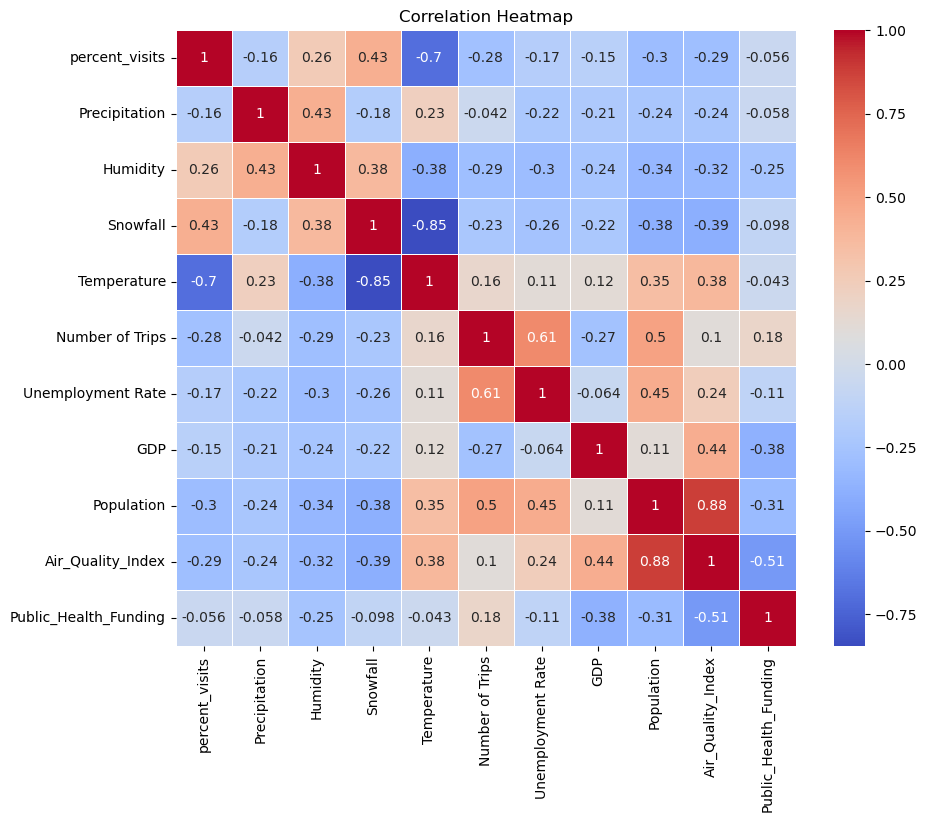

In [105]:
correlation_matrix =merged[merged.select_dtypes(['int', 'float']).columns].corr()

heatmap(correlation_matrix, image_folder, "Correlation Heatmap")

In [106]:
# merged.to_csv('final_df.csv')

In [107]:
# final = pd.read_csv('final_df.csv', index_col=0)
# final.head(2)

#### 2) Temp vs. Percent_Visits

In [108]:
top_5['State'] = top_5['State'].str.lower()
top_5

State  percent_visits
29      new mexico        1.460290
31  north carolina        1.453696
11          hawaii        1.404420
1           alaska        1.321377
0          alabama        1.282029

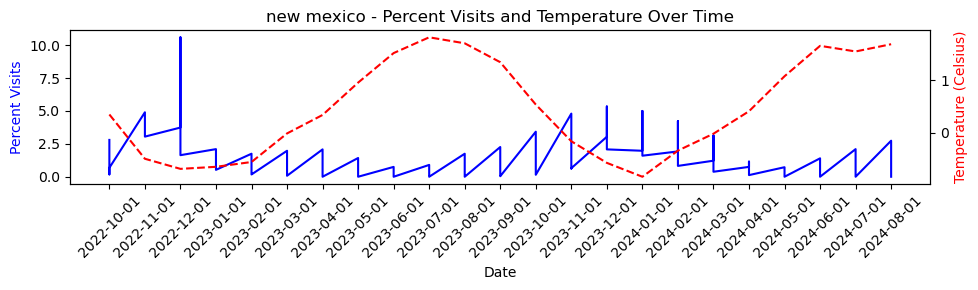

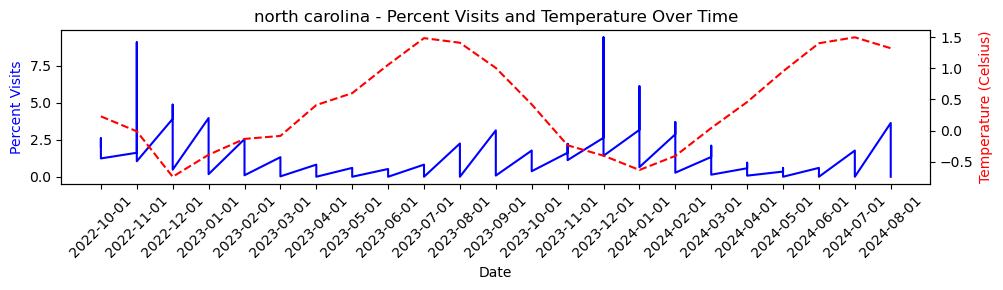

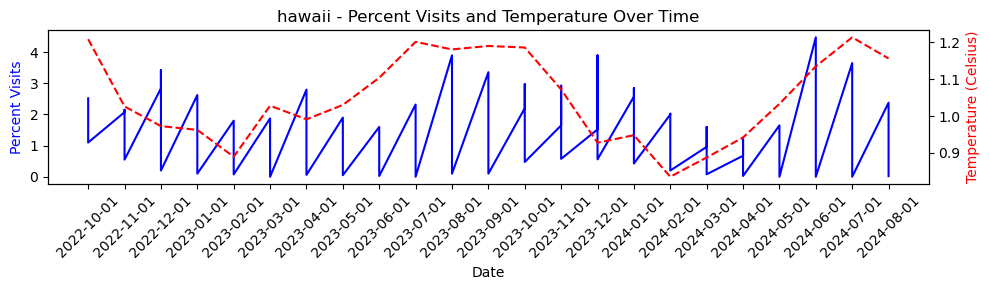

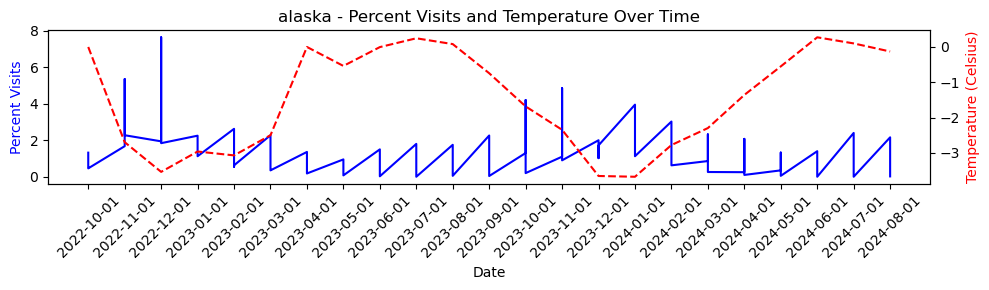

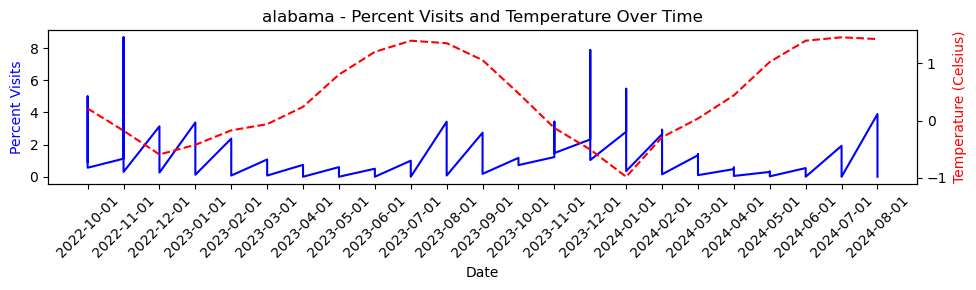

In [109]:
# Plot percent_visits over time for each state with temperature as a secondary axis
for state in top_5['State']:
    state_data = merged[merged['State'] == state]
    
    fig, ax1 = plt.subplots(figsize=(10,3))
    
    ax1.plot(state_data['Date'], state_data['percent_visits'], color='b', label='Percent Visits')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Percent Visits', color='b')
    ax1.tick_params(axis='x', rotation=45)

    
    ax2 = ax1.twinx()  # Create another y-axis to show Temperature
    ax2.plot(state_data['Date'], state_data['Temperature'], color='r', label='Temperature', linestyle='--')
    ax2.set_ylabel('Temperature (Celsius)', color='r')
    
    plt.title(f'{state} - Percent Visits and Temperature Over Time')
    fig.tight_layout()
    image_path = os.path.join(image_folder, f"top_state_{index}_{state}: percent_visit vs temp.png")
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    plt.show()

#### 3) By State | By Pathogen

In [110]:
def boxplot(data, x, y, path=None, title=None, **kwargs): 
    plt.figure(figsize=(10,6))
    sns.boxplot(x=x, y=y, data=data, **kwargs)
    if title:
        plt.title(title)
        plt.xticks(rotation=90)
    if path:
        image_path = os.path.join(image_folder, f"{title}.png")
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
    plt.show()

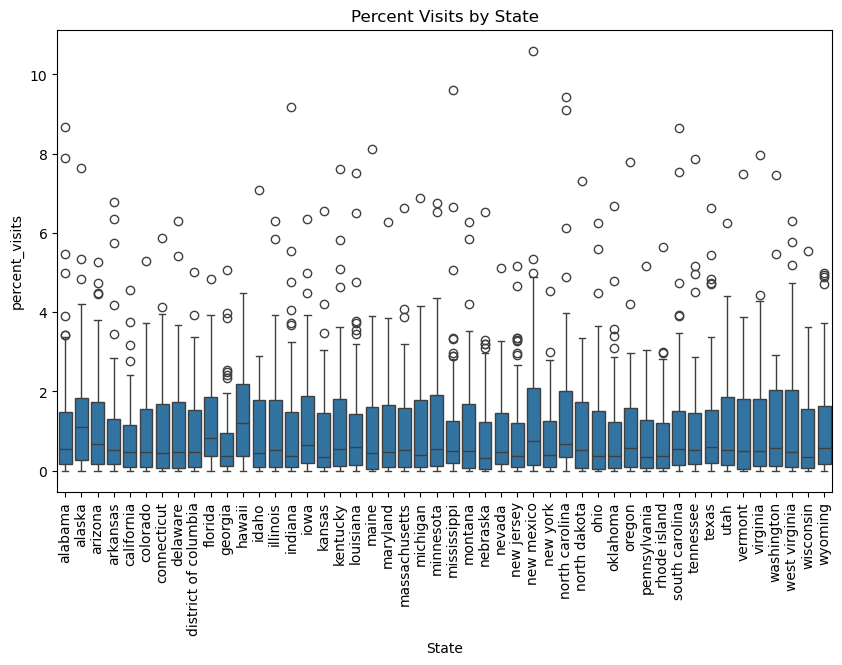

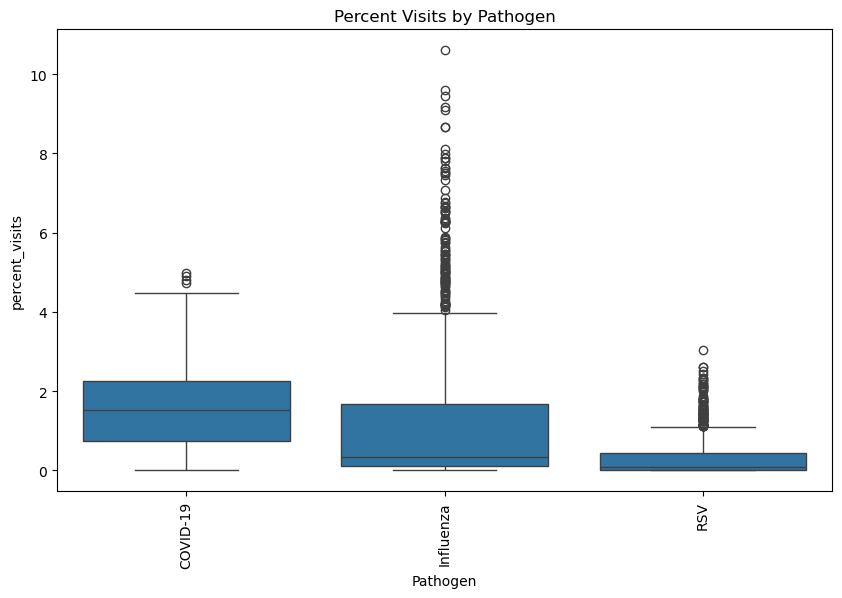

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Boxplot for percent_visits by State
boxplot(merged, x='State', y='percent_visits', path=image_folder, title="Percent Visits by State") 

# # Boxplot for percent_visits by Pathogen
boxplot(merged, x='Pathogen', y='percent_visits', path=image_folder, title="Percent Visits by Pathogen") 

### Scaling before running a model

In [112]:
final = merged.copy()

Numeric

In [113]:
numeric_features = final.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
numeric_features

['percent_visits',
 'Precipitation',
 'Humidity',
 'Snowfall',
 'Temperature',
 'Number of Trips',
 'Unemployment Rate',
 'GDP',
 'Population',
 'Air_Quality_Index',
 'Public_Health_Funding']

Date

In [114]:
final['Date'] = pd.to_datetime(final['Date'], errors='coerce')  
date_features = ['Date'] 
date_features

['Date']

Categorical

In [115]:
# Label Encoder for Categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categorical_features = final.select_dtypes(include='object').columns.tolist()
categorical_features

['Pathogen', 'State', 'Status', 'recent_trend']

In [116]:
from sklearn.preprocessing import LabelEncoder
categorical_features = final.select_dtypes(include='object').columns.tolist()

# Create a dictionary to store the mappings for each categorical feature
label_encoders = {}
mapping_dict = {}

# Iterate over each categorical feature and apply Label Encoding
for feature in categorical_features:
    label_encoder = LabelEncoder()  # Initialize a new LabelEncoder for each feature
    
    # Fit and transform the data
    final[feature] = label_encoder.fit_transform(final[feature])
    label_encoders[feature] = label_encoder
    mapping_dict[feature] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping for reference
for feature, mapping in mapping_dict.items():
    print(f"Mapping for {feature}: {mapping}")

Mapping for Pathogen: {'COVID-19': 0, 'Influenza': 1, 'RSV': 2}
Mapping for State: {'alabama': 0, 'alaska': 1, 'arizona': 2, 'arkansas': 3, 'california': 4, 'colorado': 5, 'connecticut': 6, 'delaware': 7, 'district of columbia': 8, 'florida': 9, 'georgia': 10, 'hawaii': 11, 'idaho': 12, 'illinois': 13, 'indiana': 14, 'iowa': 15, 'kansas': 16, 'kentucky': 17, 'louisiana': 18, 'maine': 19, 'maryland': 20, 'massachusetts': 21, 'michigan': 22, 'minnesota': 23, 'mississippi': 24, 'montana': 25, 'nebraska': 26, 'nevada': 27, 'new jersey': 28, 'new mexico': 29, 'new york': 30, 'north carolina': 31, 'north dakota': 32, 'ohio': 33, 'oklahoma': 34, 'oregon': 35, 'pennsylvania': 36, 'rhode island': 37, 'south carolina': 38, 'tennessee': 39, 'texas': 40, 'utah': 41, 'vermont': 42, 'virginia': 43, 'washington': 44, 'west virginia': 45, 'wisconsin': 46, 'wyoming': 47}
Mapping for Status: {'Reporting': 0}
Mapping for recent_trend: {'Decreasing': 0, 'Increasing': 1, 'No Change': 2}


In [117]:
label_encoders

{'Pathogen': LabelEncoder(),
 'State': LabelEncoder(),
 'Status': LabelEncoder(),
 'recent_trend': LabelEncoder()}

Later - you could revert back like this

In [113]:
# final['State'] = label_encoders['State'].inverse_transform(final['State'])

# Feature Importance 
- Random Forest Regressor
- Feature importance by pathogen
- Summary plot (Overall ranking); Waterfall (Specific prediction for a single sample)

In [118]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import shap
# np.sqrt(mse) = rmse

In [119]:
import numpy as np

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

- Encoding: States & Recent Trend

In [120]:
merged = pd.read_csv("Merged_final.csv", index_col = 0)
merged

Date  Pathogen          State  percent_visits     Status  \
0     2022-10-01  COVID-19        alabama            0.94  Reporting   
1     2022-10-01  COVID-19         alaska            1.32  Reporting   
2     2022-10-01  COVID-19        arizona            1.76  Reporting   
3     2022-10-01  COVID-19       arkansas            0.94  Reporting   
4     2022-10-01  COVID-19     california            1.08  Reporting   
...          ...       ...            ...             ...        ...   
3304  2024-08-01       RSV        vermont            0.00  Reporting   
3305  2024-08-01       RSV       virginia            0.00  Reporting   
3306  2024-08-01       RSV     washington            0.00  Reporting   
3307  2024-08-01       RSV  west virginia            0.00  Reporting   
3308  2024-08-01       RSV      wisconsin            0.00  Reporting   

     recent_trend  Precipitation   Humidity   Snowfall  Temperature  \
0       No Change      60.300000  67.000000   0.000000    15.550000   
1      Decreasing      84.144077  65.554118  58.230539    13.496885   
2      Decreasing      36.700000  59.000000   0.000000     9.100000   
3       No Change      56.500000  58.000000   0.000000    18.530000   
4      Decreasing       0.500000  65.554118  58.230539    20.410000   
...           ...            ...        ...        ...          ...   
3304    No Change     110.400000  65.554118   0.000000    21.360000   
3305    No Change      87.100000  65.554118   0.000000    26.030000   
3306    No Change       6.600000  65.554118   0.000000    22.050000   
3307    No Change     103.800000  65.554118   0.000000    21.610000   
3308    No Change      74.200000  65.554118   0.000000    21.590000   

      Population Staying at Home  Population Not Staying at Home  \
0                   26178.692125                    1.180326e+05   
1                   14908.311851                    5.085047e+04   
2                  198904.870968                    7.109348e+05   
3                   14380.357810                    6.503554e+04   
4                  323989.429696                    1.028061e+06   
...                          ...                             ...   
3304                16458.644444                    6.673989e+04   
3305                25801.027363                    1.015948e+05   
3306                85402.941667                    2.953417e+05   
3307                13062.151786                    5.094310e+04   
3308                30272.641553                    1.292461e+05   

      Number of Trips  Unemployment Rate         GDP    Population  \
0        5.477083e+05                2.5     110.440  5.074296e+06   
1        2.303489e+05                4.0      95.545  7.335830e+05   
2        3.192398e+06                4.0     122.800  7.359197e+06   
3        2.945177e+05                3.3  172395.800  3.045637e+06   
4        4.223268e+06                4.2     115.323  3.902934e+07   
...               ...                ...         ...           ...   
3304     3.650684e+05                2.2   44488.500  6.639589e+05   
3305     5.492021e+05                2.8  732555.900  9.099581e+06   
3306     1.400404e+06                4.8  829924.100  8.023832e+06   
3307     2.473598e+05                4.2     108.548  1.645873e+06   
3308     6.780688e+05                2.9  426554.000  6.079724e+06   

      Air_Quality_Index  Public_Health_Funding  
0            559.000000              49.480000  
1            122.000000              91.150000  
2            565.000000              16.570000  
3            372.000000              45.340000  
4           2205.000000             130.290000  
...                 ...                    ...  
3304         124.517517              37.011596  
3305        1257.288432              40.035977  
3306         915.070220              64.899627  
3307         709.416793              74.722042  
3308        1232.860767              20.496790  

[3309 rows x 18 columns]

## Clustering states

In [121]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

state_cluster = merged.drop(['Date', 'Status', 'recent_trend'], axis=1).groupby('State').mean(numeric_only=True).reset_index()

features = ['State', 'percent_visits', 'Temperature', 'Humidity', 'Number of Trips', 'Unemployment Rate', 'GDP', 'Population', 'Air_Quality_Index', 'Public_Health_Funding']
state_cluster = state_cluster[features]
numeric_state_cluster = state_cluster.drop(columns='State')

scaler = StandardScaler()
state_cluster_scaled = scaler.fit_transform(numeric_state_cluster)

kmeans = KMeans(n_clusters=5, random_state=42)
state_cluster['Cluster'] = kmeans.fit_predict(state_cluster_scaled)
state_cluster = state_cluster[['State', 'Cluster']]

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [122]:
merged = merged.merge(state_cluster[['State', 'Cluster']], on='State', how='left')

In [124]:
merged.head()

Date  Pathogen       State  percent_visits     Status recent_trend  \
0  2022-10-01  COVID-19     alabama            0.94  Reporting    No Change   
1  2022-10-01  COVID-19      alaska            1.32  Reporting   Decreasing   
2  2022-10-01  COVID-19     arizona            1.76  Reporting   Decreasing   
3  2022-10-01  COVID-19    arkansas            0.94  Reporting    No Change   
4  2022-10-01  COVID-19  california            1.08  Reporting   Decreasing   

   Precipitation   Humidity   Snowfall  Temperature  \
0      60.300000  67.000000   0.000000    15.550000   
1      84.144077  65.554118  58.230539    13.496885   
2      36.700000  59.000000   0.000000     9.100000   
3      56.500000  58.000000   0.000000    18.530000   
4       0.500000  65.554118  58.230539    20.410000   

   Population Staying at Home  Population Not Staying at Home  \
0                26178.692125                    1.180326e+05   
1                14908.311851                    5.085047e+04   
2               198904.870968                    7.109348e+05   
3                14380.357810                    6.503554e+04   
4               323989.429696                    1.028061e+06   

   Number of Trips  Unemployment Rate         GDP  Population  \
0     5.477083e+05                2.5     110.440   5074296.0   
1     2.303489e+05                4.0      95.545    733583.0   
2     3.192398e+06                4.0     122.800   7359197.0   
3     2.945177e+05                3.3  172395.800   3045637.0   
4     4.223268e+06                4.2     115.323  39029342.0   

   Air_Quality_Index  Public_Health_Funding  Cluster  
0              559.0                  49.48        1  
1              122.0                  91.15        2  
2              565.0                  16.57        0  
3              372.0                  45.34        1  
4             2205.0                 130.29        4

In [125]:
covid_19 = merged[merged['Pathogen'] == 'COVID-19'].drop(columns='Status')
rsv = merged[merged['Pathogen'] == 'RSV'].drop(columns='Status')
influenza = merged[merged['Pathogen'] == 'Influenza'].drop(columns='Status')

### COVID-19 SHAP
- Good index: 4, 88, 66, 100, 72

In [140]:
# covid_19.loc[covid_19['percent_visits'].idxmax()]
covid_19.sort_values(by='percent_visits', ascending=False).index[5]
covid_19

Date  Pathogen          State  percent_visits recent_trend  \
0     2022-10-01  COVID-19        alabama            0.94    No Change   
1     2022-10-01  COVID-19         alaska            1.32   Decreasing   
2     2022-10-01  COVID-19        arizona            1.76   Decreasing   
3     2022-10-01  COVID-19       arkansas            0.94    No Change   
4     2022-10-01  COVID-19     california            1.08   Decreasing   
...          ...       ...            ...             ...          ...   
3210  2024-08-01  COVID-19        vermont            2.16    No Change   
3211  2024-08-01  COVID-19       virginia            3.22   Increasing   
3212  2024-08-01  COVID-19     washington            2.28   Decreasing   
3213  2024-08-01  COVID-19  west virginia            2.76   Increasing   
3214  2024-08-01  COVID-19      wisconsin            2.28   Increasing   

      Precipitation   Humidity   Snowfall  Temperature  \
0         60.300000  67.000000   0.000000    15.550000   
1         84.144077  65.554118  58.230539    13.496885   
2         36.700000  59.000000   0.000000     9.100000   
3         56.500000  58.000000   0.000000    18.530000   
4          0.500000  65.554118  58.230539    20.410000   
...             ...        ...        ...          ...   
3210     110.400000  65.554118   0.000000    21.360000   
3211      87.100000  65.554118   0.000000    26.030000   
3212       6.600000  65.554118   0.000000    22.050000   
3213     103.800000  65.554118   0.000000    21.610000   
3214      74.200000  65.554118   0.000000    21.590000   

      Population Staying at Home  Population Not Staying at Home  \
0                   26178.692125                    1.180326e+05   
1                   14908.311851                    5.085047e+04   
2                  198904.870968                    7.109348e+05   
3                   14380.357810                    6.503554e+04   
4                  323989.429696                    1.028061e+06   
...                          ...                             ...   
3210                16458.644444                    6.673989e+04   
3211                25801.027363                    1.015948e+05   
3212                85402.941667                    2.953417e+05   
3213                13062.151786                    5.094310e+04   
3214                30272.641553                    1.292461e+05   

      Number of Trips  Unemployment Rate         GDP    Population  \
0        5.477083e+05                2.5     110.440  5.074296e+06   
1        2.303489e+05                4.0      95.545  7.335830e+05   
2        3.192398e+06                4.0     122.800  7.359197e+06   
3        2.945177e+05                3.3  172395.800  3.045637e+06   
4        4.223268e+06                4.2     115.323  3.902934e+07   
...               ...                ...         ...           ...   
3210     3.650684e+05                2.2   44488.500  6.639589e+05   
3211     5.492021e+05                2.8  732555.900  9.099581e+06   
3212     1.400404e+06                4.8  829924.100  8.023832e+06   
3213     2.473598e+05                4.2     108.548  1.645873e+06   
3214     6.780688e+05                2.9  426554.000  6.079724e+06   

      Air_Quality_Index  Public_Health_Funding  Cluster  
0            559.000000              49.480000        1  
1            122.000000              91.150000        2  
2            565.000000              16.570000        0  
3            372.000000              45.340000        1  
4           2205.000000             130.290000        4  
...                 ...                    ...      ...  
3210         124.517517              37.011596        2  
3211        1257.288432              40.035977        3  
3212         915.070220              64.899627        3  
3213         709.416793              74.722042        1  
3214        1232.860767              20.496790        2  

[1103 rows x 18 columns]

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MSE: 0.48608591457883676
RMSE: 0.6971986191745052


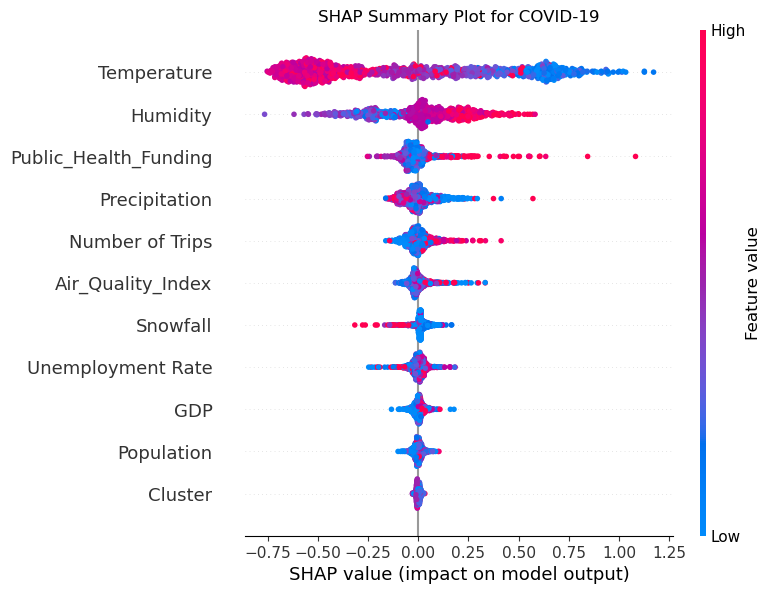

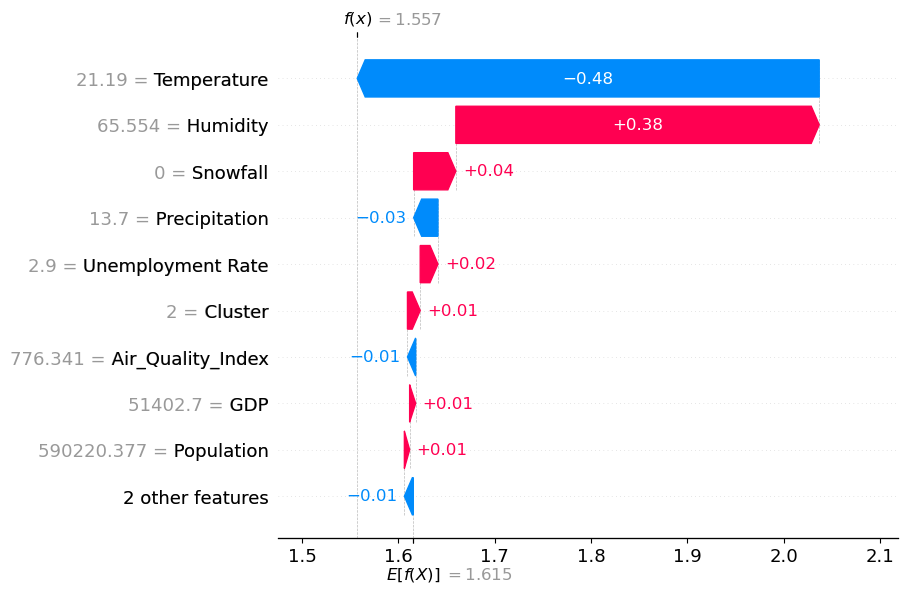

In [152]:
import matplotlib.pyplot as plt 

# One-Hot Encode State, and recent_trend
encoder_trend = OneHotEncoder(sparse=False)     # recent_trend

# Encode Pathogen, State, and recent_trend
encoded_trend = encoder_trend.fit_transform(covid_19[['recent_trend']])
encoded_trend_df = pd.DataFrame(encoded_trend, columns=encoder_trend.get_feature_names_out(['recent_trend']), index=covid_19.index)

covid_19_encoded = pd.concat([covid_19.drop(['State', 'Pathogen', 'Date'], axis=1), encoded_trend_df], axis=1)

# Set up features (X) and target (y)
X = covid_19_encoded.drop(['percent_visits', 'recent_trend', 
                           'recent_trend_Decreasing', 'recent_trend_Increasing', 'recent_trend_No Change', 'Population Staying at Home', 
                           'Population Not Staying at Home'], axis=1)  # Feature matrix
y = covid_19_encoded['percent_visits']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

# Train the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

param_grids = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 7, 9]
}

clf = GridSearchCV(estimator = rf, param_grid = param_grids) 
clf.fit(X_train, y_train)

# Accuracy Score 
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# SHAP analysis on the test set
explainer = shap.TreeExplainer(clf.best_estimator_)  
shap_values = explainer.shap_values(X)

# Summary plot for X_test (test set)
fig = plt.figure()  
shap.summary_plot(shap_values, X, show=False)
plt.title('SHAP Summary Plot for COVID-19')
plt.savefig(os.path.join(image_folder, "222COVID_19_shap_summary.png"), bbox_inches='tight', dpi=300)
plt.show()  # Display the summary plot in the notebook
plt.close(fig)  # Close the figure after saving

# Waterfall plot
shap_explanation = shap.Explanation(values=shap_values[66], 
                                    base_values=explainer.expected_value, 
                                    data=X_test.iloc[66], 
                                    feature_names=X_test.columns)

fig = plt.figure()  
shap.plots.waterfall(shap_explanation, max_display=10, show=False) 
plt.savefig(os.path.join(image_folder, "222COVID_19_shap_waterfall.png"), bbox_inches='tight', dpi=300) 
plt.show()  
plt.close(fig) 

In [153]:
clf.best_params_

{'max_depth': 9, 'n_estimators': 200}

### RSV

In [130]:
rsv.isnull().any()

Date                              False
Pathogen                          False
State                             False
percent_visits                    False
recent_trend                      False
Precipitation                     False
Humidity                          False
Snowfall                          False
Temperature                       False
Population Staying at Home        False
Population Not Staying at Home    False
Number of Trips                   False
Unemployment Rate                 False
GDP                               False
Population                        False
Air_Quality_Index                 False
Public_Health_Funding             False
Cluster                           False
dtype: bool

In [156]:
rsv['percent_visits'].idxmax()

269

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MSE: 0.1641161674709786
RMSE: 0.40511253679808357


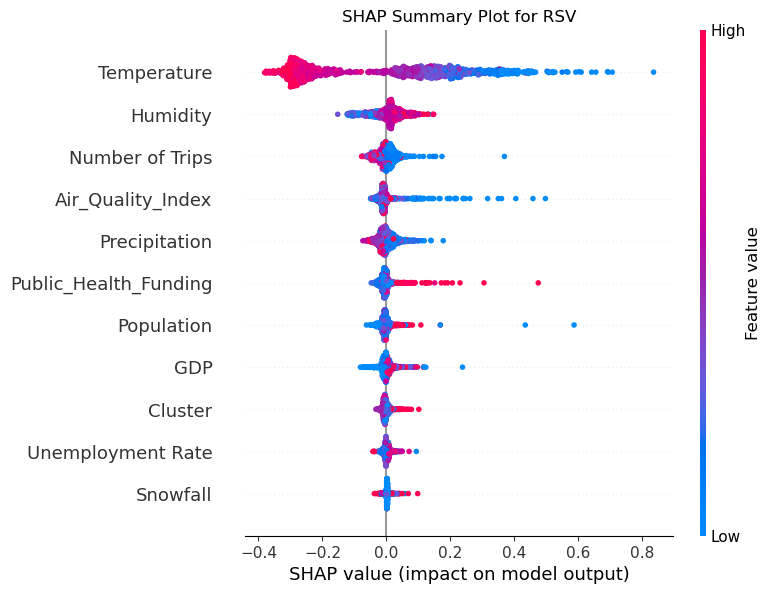

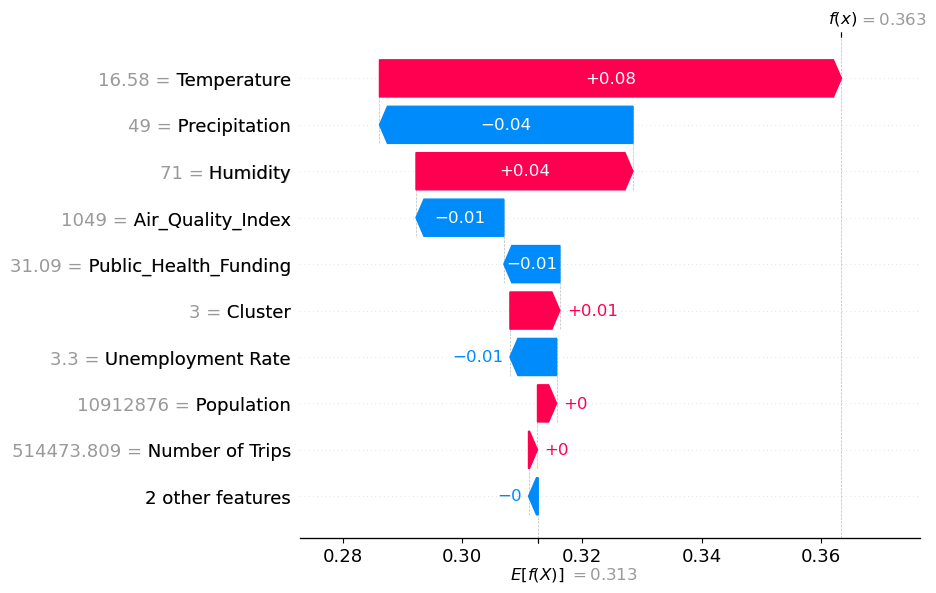

In [161]:
import matplotlib.pyplot as plt 

# One-Hot Encode State, and recent_trend
encoder_state = OneHotEncoder(sparse=False)     # State
encoder_trend = OneHotEncoder(sparse=False)     # recent_trend

# Encode Pathogen, State, and recent_trend
encoded_trend = encoder_trend.fit_transform(rsv[['recent_trend']])

# Convert encoded features back into DataFrames with proper column names
encoded_trend_df = pd.DataFrame(encoded_trend, columns=encoder_trend.get_feature_names_out(['recent_trend']), index=rsv.index)

# Concatenate the encoded columns back to the original dataframe, dropping the old categorical columns
rsv_encoded = pd.concat([rsv.drop(['State', 'Pathogen', 'Date'], axis=1), encoded_trend_df], axis=1)

# Set up features (X) and target (y)
X = rsv_encoded.drop(['percent_visits', 'recent_trend', 'Population Staying at Home', 'Population Not Staying at Home',
                      'recent_trend_No Change', 'recent_trend_Increasing'], axis=1)  # Feature matrix
y = rsv_encoded['percent_visits']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

# Train the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

param_grids = {
    'n_estimators': [1, 10, 100], 
    'max_depth': [3, 5, 7]
}

clf = GridSearchCV(estimator = rf, param_grid = param_grids) 
clf.fit(X_train, y_train)

# Accuracy Score 
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


# SHAP analysis on the test set
explainer = shap.TreeExplainer(clf.best_estimator_)  
shap_values = explainer.shap_values(X)

# Summary plot for X_test (test set)
fig = plt.figure()  # Create a figure to associate with plt.savefig()
shap.summary_plot(shap_values, X, show=False)
plt.title('SHAP Summary Plot for RSV')
plt.savefig(os.path.join(image_folder, "22RSV_shap_summary.png"), bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)  # Close the figure after saving

# Waterfall plot
shap_explanation = shap.Explanation(values=shap_values[182], 
                                    base_values=explainer.expected_value, 
                                    data=X_test.iloc[182], 
                                    feature_names=X_test.columns)

fig = plt.figure()  
shap.plots.waterfall(shap_explanation, max_display=10, show=False) 
plt.savefig(os.path.join(image_folder, "222RSV_shap_waterfall.png"), bbox_inches='tight', dpi=300) 
plt.show()  
plt.close(fig) 

### Influenza 

In [162]:
influenza.head(2)

Date   Pathogen    State  percent_visits recent_trend  \
48  2022-10-01  Influenza  alabama            5.00    No Change   
49  2022-10-01  Influenza   alaska            0.52    No Change   

    Precipitation   Humidity   Snowfall  Temperature  \
48      60.300000  67.000000   0.000000    15.550000   
49      84.144077  65.554118  58.230539    13.496885   

    Population Staying at Home  Population Not Staying at Home  \
48                26178.692125                   118032.631404   
49                14908.311851                    50850.469874   

    Number of Trips  Unemployment Rate      GDP  Population  \
48    547708.313093                2.5  110.440   5074296.0   
49    230348.871620                4.0   95.545    733583.0   

    Air_Quality_Index  Public_Health_Funding  Cluster  
48              559.0                  49.48        1  
49              122.0                  91.15        2

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MSE: 2.4415070922927953
RMSE: 1.5625322692004782


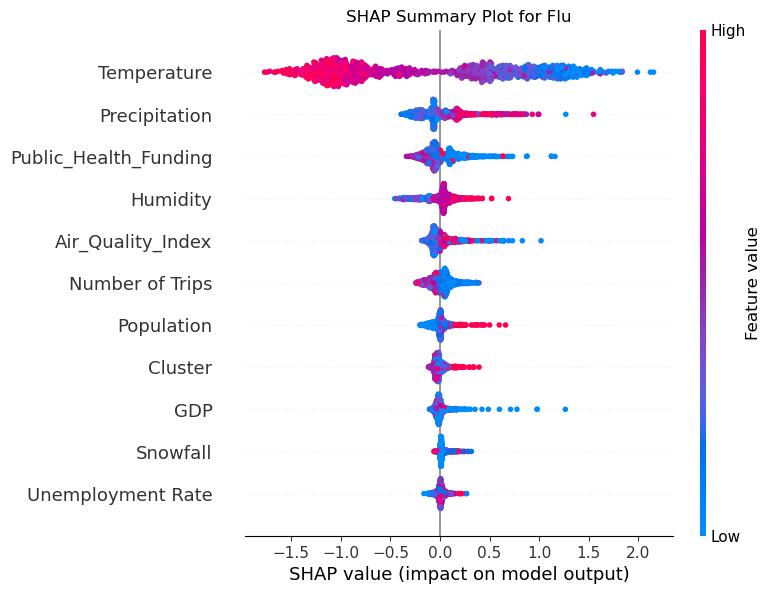

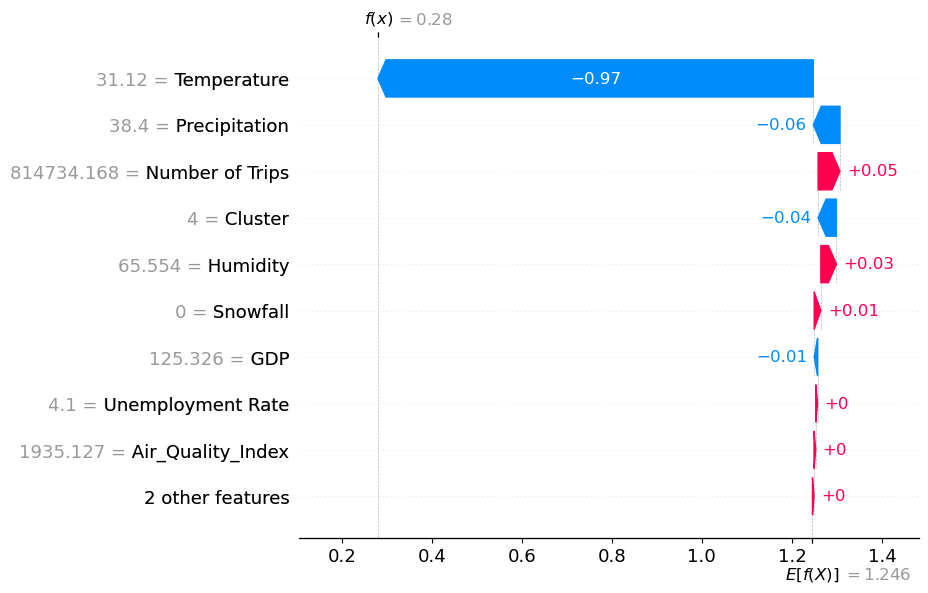

In [164]:
import matplotlib.pyplot as plt 

# One-Hot Encode State, and recent_trend
encoder_state = OneHotEncoder(sparse=False)     # State
encoder_trend = OneHotEncoder(sparse=False)     # recent_trend

# Encode Pathogen, State, and recent_trend
encoded_trend = encoder_trend.fit_transform(influenza[['recent_trend']])

# Convert encoded features back into DataFrames with proper column names
encoded_trend_df = pd.DataFrame(encoded_trend, columns=encoder_trend.get_feature_names_out(['recent_trend']), index=influenza.index)

# Concatenate the encoded columns back to the original dataframe, dropping the old categorical columns
influenza_encoded = pd.concat([influenza.drop(['State', 'recent_trend', 'Pathogen', 'Date'], axis=1), encoded_trend_df], axis=1)

# Set up features (X) and target (y)
X = influenza_encoded.drop(['percent_visits', 'Population Staying at Home', 'Population Not Staying at Home',
                            'recent_trend_Increasing', 'recent_trend_Decreasing', 'recent_trend_No Change'], axis=1)  # Feature matrix
y = influenza_encoded['percent_visits']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

# Train the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

param_grids = {
    'n_estimators': [1, 10, 100], 
    'max_depth': [3, 5, 7]
}

clf = GridSearchCV(estimator = rf, param_grid = param_grids) 
clf.fit(X_train, y_train)

# Accuracy Score 
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
# mape = mape(y_test, y_pred)
# print(f"MAPE: {rmse}%")

# SHAP analysis on the test set
explainer = shap.TreeExplainer(clf.best_estimator_)  
shap_values = explainer.shap_values(X)

# Summary plot
fig = plt.figure()  # Create a figure to associate with plt.savefig()
shap.summary_plot(shap_values, X, show=False)
plt.title('SHAP Summary Plot for Flu')
plt.savefig(os.path.join(image_folder, "222Flu_shap_summary.png"), bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)  # Close the figure after saving


# Waterfall plot
shap_explanation = shap.Explanation(values=shap_values[10], 
                                    base_values=explainer.expected_value, 
                                    data=X_test.iloc[10], 
                                    feature_names=X_test.columns)
fig = plt.figure()  
shap.plots.waterfall(shap_explanation, max_display=10, show=False) 
plt.savefig(os.path.join(image_folder, "222Flu_shap_waterfall.png"), bbox_inches='tight', dpi=300) 
plt.show()  
plt.close(fig) 

# Modeling
- Feature importance: Deep SHAP (computationally expensive) or Permutation Feature Importance (ignoring the order - which is critical for LSTM)

- X.shape[0] is automatically created as the total # of samples when we append
- X.shape[1] is the sliced # of rows (which are our) # of timestamps
- X.shape[2] is the # of features created

### SARIMAX

In [128]:
final = pd.read_csv("Merged_final.csv", index_col = 0)
final.head(2)

Date  Pathogen    State  percent_visits     Status trend_on_date  \
0  2022-10-01  COVID-19  alabama            0.94  Reporting    Decreasing   
1  2022-10-01  COVID-19   alaska            1.32  Reporting    Decreasing   

  recent_trend  Precipitation   Humidity   Snowfall  Temperature  \
0    No Change      60.300000  67.000000   0.000000    15.550000   
1   Decreasing      84.144077  65.554118  58.230539    13.496885   

   Population Staying at Home  Population Not Staying at Home  \
0                26178.692125                   118032.631404   
1                14908.311851                    50850.469874   

   Number of Trips  Unemployment Rate  GDP  
0    547708.313093                2.5  5.2  
1    230348.871620                4.0  6.3

In [133]:
# # Group by 'State' and count the number of 0 values in each numeric column
# zero_counts = final.groupby('State').apply(lambda x: (x['percent_visits'] == 0).sum())

# # Display the zero counts for each state
# print(zero_counts)

# # If you want to avoid states with many zeros, you can filter them
# # For example, keep only states with fewer than a specific threshold number of zeros
# threshold = 3  # Define your threshold here
# states_with_few_zeros = zero_counts[zero_counts.sum(axis=1) < threshold].index

# # Filter the original DataFrame to only include states with fewer than the threshold number of zeros
# filtered_final = final[final['State'].isin(states_with_few_zeros)]

# # print(filtered_final)

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_88037/3811183699.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_counts = final.groupby('State').apply(lambda x: (x['percent_visits'] == 0).sum())


State
alabama                  7
alaska                   3
arizona                  8
arkansas                 7
california               9
colorado                 8
connecticut             12
delaware                 9
district of columbia     6
florida                  3
georgia                  8
hawaii                   5
idaho                    8
illinois                 8
indiana                  9
iowa                     4
kansas                   9
kentucky                 6
louisiana                9
maine                   15
maryland                 9
massachusetts            8
michigan                10
minnesota                8
mississippi              4
montana                  9
nebraska                13
nevada                   9
new jersey              10
new mexico               9
new york                11
north carolina           9
north dakota             6
ohio                    14
oklahoma                 8
oregon                   9
pennsylvania          

ValueError: No axis named 1 for object type Series

In [129]:
group_data = final[final['State'] == 'new mexico']
group_data

Date   Pathogen       State  percent_visits     Status  \
29    2022-10-01   COVID-19  new mexico           2.800  Reporting   
77    2022-10-01  Influenza  new mexico           0.180  Reporting   
125   2022-10-01        RSV  new mexico           0.680  Reporting   
173   2022-11-01   COVID-19  new mexico           4.900  Reporting   
221   2022-11-01  Influenza  new mexico           3.525  Reporting   
...          ...        ...         ...             ...        ...   
3101  2024-07-01  Influenza  new mexico           0.100  Reporting   
3149  2024-07-01        RSV  new mexico           0.000  Reporting   
3197  2024-08-01   COVID-19  new mexico           2.740  Reporting   
3244  2024-08-01  Influenza  new mexico           0.100  Reporting   
3291  2024-08-01        RSV  new mexico           0.000  Reporting   

     trend_on_date recent_trend  Precipitation   Humidity  Snowfall  \
29      Decreasing    No Change           50.4  65.000000       0.0   
77       No Change    No Change           50.4  65.000000       0.0   
125     Increasing    No Change           50.4  65.000000       0.0   
173     Increasing    No Change           21.1  55.000000       8.0   
221     Increasing    No Change           21.1  55.000000       8.0   
...            ...          ...            ...        ...       ...   
3101     No Change    No Change           82.3  65.554118       0.0   
3149     No Change    No Change           82.3  65.554118       0.0   
3197    Increasing    No Change           10.6  65.554118       0.0   
3244     No Change    No Change           10.6  65.554118       0.0   
3291     No Change    No Change           10.6  65.554118       0.0   

      Temperature  Population Staying at Home  Population Not Staying at Home  \
29          16.90                26026.099994                   100915.547237   
77          16.90                26026.099994                   100915.547237   
125         16.90                26026.099994                   100915.547237   
173          8.70                25684.868687                   101376.737374   
221          8.70                25684.868687                   101376.737374   
...           ...                         ...                             ...   
3101        28.57                26022.995098                    97319.887255   
3149        28.57                26022.995098                    97319.887255   
3197        29.91                26022.995098                    97319.887255   
3244        29.91                26022.995098                    97319.887255   
3291        29.91                26022.995098                    97319.887255   

      Number of Trips  Unemployment Rate  GDP  
29      525639.417544                3.6  8.9  
77      525639.417544                3.6  8.9  
125     525639.417544                3.6  8.9  
173     539474.109091                3.6  8.9  
221     539474.109091                3.6  8.9  
...               ...                ...  ...  
3101    541855.225490                4.0  2.6  
3149    541855.225490                4.0  2.6  
3197    541855.225490                4.1  2.6  
3244    541855.225490                4.1  2.6  
3291    541855.225490                4.1  2.6  

[69 rows x 16 columns]

- PDARMIA for optimal parameters:
- Best model found out to be [Best model:  ARIMA(0,0,0)(0,2,0)[12] intercept]

- SARIMAX for one state
  Best: order=(0,0,0), seasonal_order=(0,2,0, 12)
- Differencing for Seasonality (D = 2): The fact that seasonal differencing (D) is set to 2 tells us that there is significant seasonal variation in your data, and applying a differencing twice is effective in removing the seasonality. Essentially, the data needs significant adjustment to account for repeated patterns every year. Because I had left the extreme outliers found in previous EDA.

In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

group_data = final[final['State'] == 'california']

# Initialize a list to store RMSEs
group_rmse = []

# Initialize scaler for both features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Loop through each unique pathogen for Alaska
for pathogen, group_data in group_data.groupby(['Pathogen']):
    print(f"Processing SARIMAX model for Alaska's {pathogen}")
    
    # Train-test split (e.g., last 20% as the test set)
    train_size = int(len(group_data) * 0.8)
    train_set = group_data.iloc[:train_size]
    test_set = group_data.iloc[train_size:]

    # Set the target (percent_visits) and exogenous variables (other columns)
    y_train = train_set['percent_visits'].values.reshape(-1, 1)
    y_train_scaled = scaler_target.fit_transform(y_train)

    X_train = train_set.drop(columns=['percent_visits', 'Status', 'Date', 'Snowfall', 'recent_trend', 'State', 'Pathogen'])
    X_train_scaled = scaler_features.fit_transform(X_train)

    y_test = test_set['percent_visits'].values.reshape(-1, 1)
    y_test_scaled = scaler_target.transform(y_test)

    X_test = test_set.drop(columns=['percent_visits', 'Status', 'Date', 'Snowfall', 'recent_trend', 'State', 'Pathogen'])
    X_test_scaled = scaler_features.transform(X_test)

    # Fit SARIMAX with exogenous variables
    model = SARIMAX(y_train_scaled, exog=X_train_scaled, order=(0,0,0), seasonal_order=(0,2,0, 12))
    model_fit = model.fit(disp=False)

    # Predict using the test set
    y_pred_scaled = model_fit.predict(start=len(y_train_scaled), end=len(y_train_scaled) + len(y_test_scaled) - 1, exog=X_test_scaled)

    # Inverse transform the predicted values to the original scale
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate RMSE for the group
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for State: Alaska, Pathogen: {pathogen} is {rmse}")
    
    # Append the RMSE to the list
    group_rmse.append({'Pathogen': pathogen, 'RMSE': rmse})

# Convert to a DataFrame to view RMSEs for each group
group_rmse_df = pd.DataFrame(group_rmse)
print(group_rmse_df)

Processing SARIMAX model for Alaska's ('COVID-19',)
RMSE for State: Alaska, Pathogen: ('COVID-19',) is 0.6276364393500429
Processing SARIMAX model for Alaska's ('Influenza',)
RMSE for State: Alaska, Pathogen: ('Influenza',) is 0.21272047386182646
Processing SARIMAX model for Alaska's ('RSV',)
RMSE for State: Alaska, Pathogen: ('RSV',) is 0.01118033988749895
       Pathogen      RMSE
0   (COVID-19,)  0.627636
1  (Influenza,)  0.212720
2        (RSV,)  0.011180


In [131]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

group_data = final[final['State'] == 'alaska']

# Initialize a list to store RMSEs
group_rmse = []

# Initialize scaler for both features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Loop through each unique pathogen for Alaska
for pathogen, group_data in group_data.groupby(['Pathogen']):
    print(f"Processing SARIMAX model for Alaska's {pathogen}")
    
    # Train-test split (e.g., last 20% as the test set)
    train_size = int(len(group_data) * 0.8)
    train_set = group_data.iloc[:train_size]
    test_set = group_data.iloc[train_size:]

    # Set the target (percent_visits) and exogenous variables (other columns)
    y_train = train_set['percent_visits'].values.reshape(-1, 1)
    y_train_scaled = scaler_target.fit_transform(y_train)

    X_train = train_set.drop(columns=['percent_visits', 'Status', 'Date', 'Snowfall', 'trend_on_date', 'recent_trend', 'State', 'Pathogen'])
    X_train_scaled = scaler_features.fit_transform(X_train)

    y_test = test_set['percent_visits'].values.reshape(-1, 1)
    y_test_scaled = scaler_target.transform(y_test)

    X_test = test_set.drop(columns=['percent_visits', 'Status', 'Date', 'Snowfall', 'trend_on_date', 'recent_trend', 'State', 'Pathogen'])
    X_test_scaled = scaler_features.transform(X_test)

    # Fit SARIMAX with exogenous variables
    model = SARIMAX(y_train_scaled, exog=X_train_scaled, order=(0,0,0), seasonal_order=(0,2,0, 12))
    model_fit = model.fit(disp=False)

    # Predict using the test set
    y_pred_scaled = model_fit.predict(start=len(y_train_scaled), end=len(y_train_scaled) + len(y_test_scaled) - 1, exog=X_test_scaled)

    # Inverse transform the predicted values to the original scale
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate RMSE for the group
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for State: Alaska, Pathogen: {pathogen} is {rmse}")
    
    # Append the RMSE to the list
    group_rmse.append({'Pathogen': pathogen, 'RMSE': rmse})

# Convert to a DataFrame to view RMSEs for each group
group_rmse_df = pd.DataFrame(group_rmse)
print(group_rmse_df)

Processing SARIMAX model for Alaska's ('COVID-19',)
RMSE for State: Alaska, Pathogen: ('COVID-19',) is 0.701448501317096
Processing SARIMAX model for Alaska's ('Influenza',)
RMSE for State: Alaska, Pathogen: ('Influenza',) is 0.9689362724142389
Processing SARIMAX model for Alaska's ('RSV',)
RMSE for State: Alaska, Pathogen: ('RSV',) is 0.08629889918185515
       Pathogen      RMSE
0   (COVID-19,)  0.701449
1  (Influenza,)  0.968936
2        (RSV,)  0.086299


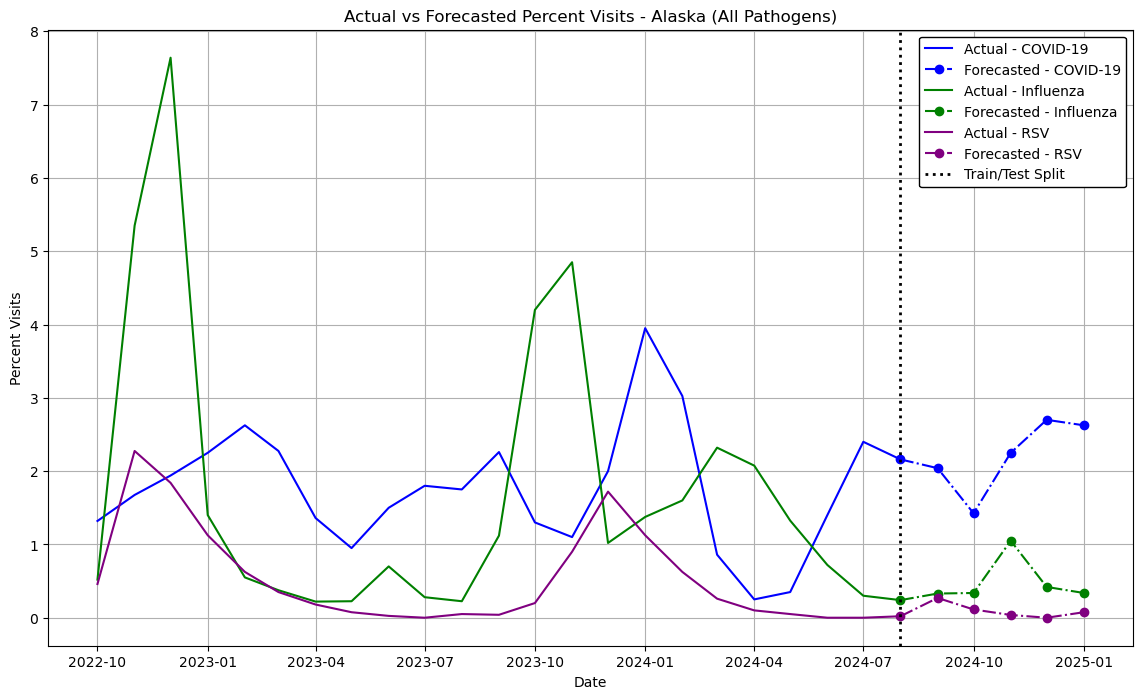

In [170]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

group_data = final[final['State'] == 'alaska']

# Initialize figure for plotting
plt.figure(figsize=(14, 8))

scaler = MinMaxScaler()

colors = {'COVID-19': 'blue', 'Influenza': 'green', 'RSV': 'purple'}

# Loop through each unique pathogen for Alaska
for pathogen_tuple, group in group_data.groupby(['Pathogen']):
    pathogen = pathogen_tuple if isinstance(pathogen_tuple, str) else pathogen_tuple[0]
    
    train_size = int(len(group) * 0.8)
    train_set = group.iloc[:train_size]
    test_set = group.iloc[train_size:]
    
    y_train = train_set['percent_visits'].values
    y_test = test_set['percent_visits'].values

    X_train = train_set.drop(columns=['percent_visits', 'Status', 'Date', 'Snowfall', 'recent_trend', 'State', 'Pathogen'])
    X_train_scaled = scaler.fit_transform(X_train)
    
    X_test = test_set.drop(columns=['percent_visits', 'Status', 'Date', 'Snowfall', 'recent_trend', 'State', 'Pathogen'])
    X_test_scaled = scaler.transform(X_test)
    
    # Fit SARIMAX with exogenous variables
    model = SARIMAX(y_train, exog=X_train_scaled, order=(0,0,0), seasonal_order=(0,2,0, 12))
    model_fit = model.fit(disp=False)

    # Combine training and test actuals into one array
    y_full_actual = np.concatenate([y_train, y_test])

    # Ensure 'Date' column is converted to datetime format
    dates = pd.to_datetime(group['Date'])

    # Plot actual values for each pathogen
    plt.plot(dates, y_full_actual, label=f'Actual - {pathogen}', linestyle='-', color=colors[pathogen])

    # Forecasting the next 3 months (exogenous required)
    last_sequence = X_test_scaled[-1:]  # Get the last value of the test set
    forecast_steps = 5
    forecast_dates = pd.date_range(start=pd.to_datetime(test_set['Date'].max()), periods=forecast_steps + 1, freq='MS')[1:]

    y_forecast = model_fit.forecast(steps=forecast_steps, exog=np.tile(last_sequence, (forecast_steps, 1)))

    # Combine the last actual value and forecasted values for continuity
    extended_forecast_dates = pd.concat([test_set['Date'].tail(1), pd.Series(forecast_dates)])
    extended_forecast_values = np.concatenate([[y_test[-1]], y_forecast])

    # Plot forecast values in the same color to ensure continuity
    plt.plot(pd.to_datetime(extended_forecast_dates), extended_forecast_values, linestyle='-.', label=f'Forecasted - {pathogen}', color=colors[pathogen], marker='o')

# Add labels, legend, title, etc.
plt.title("Actual vs Forecasted Percent Visits - Alaska (All Pathogens)")
plt.xlabel("Date")
plt.ylabel("Percent Visits")
plt.axvline(x=pd.to_datetime(test_set['Date'].max()), color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.legend(loc='best', fancybox=True, framealpha=1, edgecolor='black')
plt.grid(True)

# Show the plot
plt.show()

### LSTM
- As LSTM requires at least 30 data points, grouping by both state and pathogen for forecasting is not recommended.
- Encoded state & pathogen | month & day --> for grouping purpose
- As we are interested in medical visits by location, we group the pathogens by state.
- 

In [267]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class LSTMpreprocessor:
    def __init__(self, numerical_features, categorical_features, date_features, time_steps=3):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.date_features = date_features
        self.scaler = MinMaxScaler()
        self.label_encoders = {col: LabelEncoder() for col in self.categorical_features}
        self.time_steps = time_steps 
        
    # Scaling numerical features using MinMaxScaler
    def scale_numerical(self, df):
        df[self.numerical_features] = self.scaler.fit_transform(df[self.numerical_features])
        return df

    # Reshape the data for LSTM
    def create_sequences(self, data, target_column_index):
        X, y = [], []
        for i in range(len(data) - self.time_steps):
            # All columns before the target
            X.append(data[i:i + self.time_steps, np.arange(data.shape[1]) != target_column_index])  # at 1~4 sequences
            y.append(data[i + self.time_steps, target_column_index])     # at 5th sequence
        return np.array(X), np.array(y)

    def encode_categorical(self, df):
        for col in self.categorical_features:
            df[col] = self.label_encoders[col].fit_transform(df[col])
        return df

    # def train_test_split_time_series(self, df, test_size=0.2):
    #     n = len(df)
    #     train_size = int((1 - test_size) * n)
        
    #     train_set = df[:train_size]
    #     test_set = df[train_size:]
        
    #     return train_set, test_set

    def train_test_split_time_series(self, df, test_size=0.2):
        # Sort the dataset by date to ensure it is time-ordered
        df = df.sort_values(by='Date')
    
        # Calculate the index to start the test set (based on test_size)
        n = len(df)
        train_size = int((1 - test_size) * n)
        
        # Split the data into training and test sets
        train_set = df.iloc[:train_size]
        test_set = df.iloc[train_size:]  # Test set will contain the most recent dates
        
        return train_set, test_set

    
    def prepare_data(self, df, target_column):
    
        df = self.scale_numerical(df)
        df = self.encode_categorical(df)
        
        # Find the index of the target column
        target_column_index = df.columns.get_loc(target_column)
        
        # Convert to NumPy array and reshape for LSTM
        data = df[self.numerical_features + self.categorical_features + [target_column]].values
        X, y = self.create_sequences(data, target_column_index)
        
        # Reshape X to (samples, timesteps, features) format
        X = X.reshape(X.shape[0], X.shape[1], len(self.numerical_features + self.categorical_features))
       
        return X, y

    def prepare_data_with_split(self, df, target_column, test_size=0.2):
        # function above 
        train_set, test_set = self.train_test_split_time_series(df, test_size=test_size)
        
        # Prepare the training data
        X_train, y_train = self.prepare_data(train_set, target_column)
        
        # Prepare the test data
        X_test, y_test = self.prepare_data(test_set, target_column)
        
        return X_train, y_train, X_test, y_test

    # def evaluate_model(self, model, X_test, y_test):
    #     y_pred = model.predict(X_test)
        
    #     # Calculate RMSE and MAE
    #     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #     mae = mean_absolute_error(y_test, y_pred)
        
    #     print(f"RMSE: {rmse}")
    #     print(f"MAE: {mae}")
        
    #     return rmse, mae

    def evaluate_model(self, model, X_test, y_test, num_steps_ahead=6):
        y_pred = model.predict(X_test) 
        
        if y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)  
        
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)
    
        rmses = []
        maes = []
        
        for step in range(min(num_steps_ahead, y_pred.shape[1])):
            rmse = np.sqrt(mean_squared_error(y_test[:, step], y_pred[:, step]))
            mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
            rmses.append(rmse)
            maes.append(mae)
            print(f"Step {step+1}: RMSE = {rmse}, MAE = {mae}")
        
        avg_rmse = np.mean(rmses)
        avg_mae = np.mean(maes)
        
        print(f"Average RMSE across {num_steps_ahead} steps: {avg_rmse}")
        print(f"Average MAE across {num_steps_ahead} steps: {avg_mae}")
        
        return avg_rmse, avg_mae
        
    # def predict_next_for_each_state_and_pathogen(self, model, df):
    #     predictions = {}

    #     # Loop through each state-pathogen combination
    #     for (state, pathogen) in df.groupby(['State', 'Pathogen']).groups.keys():
    #         state_pathogen_data = df[(df['State'] == state) & (df['Pathogen'] == pathogen)]
    #         last_sequence = state_pathogen_data[self.numerical_features + self.categorical_features].values[-self.time_steps:]
    #         last_sequence = last_sequence.reshape((1, self.time_steps, len(self.numerical_features + self.categorical_features)))
    #         next_prediction = model.predict(last_sequence)
    #         predictions[(state, pathogen)] = next_prediction

    #     return predictions

    def predict_next_for_each_state(self, model, df, steps=6):
        predictions = {}
    
        # Loop through each state
        for state in df['State'].unique():
            state_data = df[df['State'] == state]
            
            # Aggregate pathogen data by summing or averaging the percent_visits
            state_aggregated_data = state_data.groupby('Date').agg({
                'percent_visits': 'sum',
                **{col: 'first' for col in self.numerical_features + self.categorical_features if col != 'percent_visits'}
            }).reset_index()
    
            if len(state_aggregated_data) >= self.time_steps:
                last_sequence = state_aggregated_data[self.numerical_features + self.categorical_features].values[-self.time_steps:]
                last_sequence = last_sequence.reshape((1, self.time_steps, len(self.numerical_features + self.categorical_features)))
    
                state_predictions = []
                for _ in range(steps):
                    # Predict the next step
                    next_prediction = model.predict(last_sequence)
                    state_predictions.append(next_prediction[0][0])
    
                    # Update the sequence with the new prediction for 'percent_visits'
                    # Create a new array where the target feature is replaced by the new prediction
                    new_sequence = np.copy(last_sequence)
                    new_sequence[:, -1, 0] = next_prediction[0][0]  # Replace the last target value (percent_visits)
                    
                    # Shift the sequence
                    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence[:, -1:, :], axis=1)
    
                predictions[state] = state_predictions
    
        return predictions

In [237]:
final

Date  Pathogen                 State  percent_visits     Status  \
5    2022-10-01  COVID-19              colorado            1.80  Reporting   
6    2022-10-01  COVID-19           connecticut            3.08  Reporting   
7    2022-10-01  COVID-19              delaware            2.18  Reporting   
8    2022-10-01  COVID-19  district of columbia            1.54  Reporting   
9    2022-10-01  COVID-19               florida            1.20  Reporting   
...         ...       ...                   ...             ...        ...   
3304 2024-08-01       RSV               vermont            0.00  Reporting   
3305 2024-08-01       RSV              virginia            0.00  Reporting   
3306 2024-08-01       RSV            washington            0.00  Reporting   
3307 2024-08-01       RSV         west virginia            0.00  Reporting   
3308 2024-08-01       RSV             wisconsin            0.00  Reporting   

     trend_on_date  recent_trend  Precipitation  Humidity  Snowfall  \
5       Decreasing             0       0.004774  0.229508       0.0   
6       Decreasing             2       0.132731  0.704918       0.0   
7        No Change             2       0.110834  0.704918       0.0   
8       Decreasing             2       0.073371  0.639344       0.0   
9       Decreasing             0       0.042237  0.803279       0.0   
...            ...           ...            ...       ...       ...   
3304     No Change             2       0.114570  0.632035       0.0   
3305     No Change             2       0.090390  0.632035       0.0   
3306     No Change             2       0.006849  0.632035       0.0   
3307     No Change             2       0.107721  0.632035       0.0   
3308     No Change             2       0.077003  0.632035       0.0   

      Temperature  Population Staying at Home  Population Not Staying at Home  \
5        0.630836                    0.103078                        0.113139   
6        0.626131                    0.473310                        0.589004   
7        0.642237                    0.276151                        0.356179   
8        0.668657                    0.594517                        0.465764   
9        0.772349                    0.360450                        0.469551   
...           ...                         ...                             ...   
3304     0.792074                    0.033321                        0.042681   
3305     0.876583                    0.061374                        0.076530   
3306     0.804560                    0.240345                        0.264685   
3307     0.796598                    0.023122                        0.027340   
3308     0.796236                    0.074801                        0.103383   

      Number of Trips       GDP  Unemployment Rate     month  year  \
5            0.130735  0.528634              0.300  0.818182   0.0   
6            0.578155  0.581498              0.525  0.818182   0.0   
7            0.329063  0.462555              0.625  0.818182   0.0   
8            0.599245  0.431718              0.675  0.818182   0.0   
9            0.425103  0.546256              0.300  0.818182   0.0   
...               ...       ...                ...       ...   ...   
3304         0.048670  0.418502              0.125  0.636364   1.0   
3305         0.084023  0.458150              0.275  0.636364   1.0   
3306         0.247451  0.453744              0.775  0.636364   1.0   
3307         0.026070  0.414097              0.625  0.636364   1.0   
3308         0.108765  0.387665              0.300  0.636364   1.0   

      percent_visits_rolling_mean_3  percent_visits_rolling_mean_6  
5                          0.169326                       0.189831  
6                          0.264184                       0.241646  
7                          0.312943                       0.262470  
8                          0.301418                       0.257143  
9                          0.218085                       0.26

In [319]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class LSTMpreprocessor:
    def __init__(self, numerical_features, categorical_features, date_features, time_steps=3):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.date_features = date_features
        self.scaler = MinMaxScaler()
        self.label_encoders = {col: LabelEncoder() for col in self.categorical_features}
        self.time_steps = time_steps 
        
    # Scaling numerical features using MinMaxScaler
    def scale_numerical(self, df):
        df[self.numerical_features] = self.scaler.fit_transform(df[self.numerical_features])
        return df

    # Reshape the data for LSTM
    def create_sequences(self, data, target_column_index, num_steps_ahead=3):
        X, y = [], []
        for i in range(len(data) - self.time_steps - num_steps_ahead + 1):
            # Input sequence
            X.append(data[i:i + self.time_steps, np.arange(data.shape[1]) != target_column_index])
            # Output multi-step target sequence
            y.append(data[i + self.time_steps:i + self.time_steps + num_steps_ahead, target_column_index])
        return np.array(X), np.array(y)

    def encode_categorical(self, df):
        for col in self.categorical_features:
            df[col] = self.label_encoders[col].fit_transform(df[col])
        return df

    # def train_test_split_time_series(self, df, test_size=0.2):
    #     n = len(df)
    #     train_size = int((1 - test_size) * n)
        
    #     train_set = df[:train_size]
    #     test_set = df[train_size:]
        
    #     return train_set, test_set

    def train_test_split_time_series(self, df, test_size=0.2):
        # Sort the dataset by date to ensure it is time-ordered
        df = df.sort_values(by='Date')
    
        # Calculate the index to start the test set (based on test_size)
        n = len(df)
        train_size = int((1 - test_size) * n)
        
        # Split the data into training and test sets
        train_set = df.iloc[:train_size]
        test_set = df.iloc[train_size:]  # Test set will contain the most recent dates
        
        return train_set, test_set

    
    def prepare_data(self, df, target_column, num_steps_ahead=3):
        df = self.scale_numerical(df)
        df = self.encode_categorical(df)
    
        target_column_index = df.columns.get_loc(target_column)
    
        # Convert to NumPy array and reshape for LSTM
        data = df[self.numerical_features + self.categorical_features + [target_column]].values
        X, y = self.create_sequences(data, target_column_index, num_steps_ahead=num_steps_ahead)
    
        # Reshape X to (samples, timesteps, features) format
        X = X.reshape(X.shape[0], X.shape[1], len(self.numerical_features + self.categorical_features))
    
        return X, y


    def prepare_data_with_split(self, df, target_column, test_size=0.2):
        # function above 
        train_set, test_set = self.train_test_split_time_series(df, test_size=test_size)
        
        # Prepare the training data
        X_train, y_train = self.prepare_data(train_set, target_column)
        
        # Prepare the test data
        X_test, y_test = self.prepare_data(test_set, target_column)
        
        return X_train, y_train, X_test, y_test

    # def evaluate_model(self, model, X_test, y_test):
    #     y_pred = model.predict(X_test)
        
    #     # Calculate RMSE and MAE
    #     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #     mae = mean_absolute_error(y_test, y_pred)
        
    #     print(f"RMSE: {rmse}")
    #     print(f"MAE: {mae}")
        
    #     return rmse, mae

    def evaluate_model(self, model, X_test, y_test, num_steps_ahead=3):
        y_pred = model.predict(X_test)  # Get the predicted output for each sequence
    
        if y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)
    
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)
    
        rmses = []
        maes = []
    
        # Iterate over each time step prediction
        for step in range(min(num_steps_ahead, y_pred.shape[1])):
            rmse = np.sqrt(mean_squared_error(y_test[:, step], y_pred[:, step]))
            mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
            rmses.append(rmse)
            maes.append(mae)
            print(f"Step {step+1}: RMSE = {rmse}, MAE = {mae}")
    
        avg_rmse = np.mean(rmses)
        avg_mae = np.mean(maes)
    
        print(f"Average RMSE across {num_steps_ahead} steps: {avg_rmse}")
        print(f"Average MAE across {num_steps_ahead} steps: {avg_mae}")
    
        return avg_rmse, avg_mae

        
    # def predict_next_for_each_state_and_pathogen(self, model, df):
    #     predictions = {}

    #     # Loop through each state-pathogen combination
    #     for (state, pathogen) in df.groupby(['State', 'Pathogen']).groups.keys():
    #         state_pathogen_data = df[(df['State'] == state) & (df['Pathogen'] == pathogen)]
    #         last_sequence = state_pathogen_data[self.numerical_features + self.categorical_features].values[-self.time_steps:]
    #         last_sequence = last_sequence.reshape((1, self.time_steps, len(self.numerical_features + self.categorical_features)))
    #         next_prediction = model.predict(last_sequence)
    #         predictions[(state, pathogen)] = next_prediction

    #     return predictions

    def predict_next_for_each_state(self, model, df, steps=6):
        predictions = {}
    
        # Loop through each state
        for state in df['State'].unique():
            state_data = df[df['State'] == state]
            
            # Aggregate pathogen data by summing or averaging the percent_visits
            state_aggregated_data = state_data.groupby('Date').agg({
                'percent_visits': 'sum',
                **{col: 'first' for col in self.numerical_features + self.categorical_features if col != 'percent_visits'}
            }).reset_index()
    
            if len(state_aggregated_data) >= self.time_steps:
                last_sequence = state_aggregated_data[self.numerical_features + self.categorical_features].values[-self.time_steps:]
                last_sequence = last_sequence.reshape((1, self.time_steps, len(self.numerical_features + self.categorical_features)))
    
                state_predictions = []
                for _ in range(steps):
                    # Predict the next step
                    next_prediction = model.predict(last_sequence)
                    state_predictions.append(next_prediction[0][0])
    
                    # Update the sequence with the new prediction for 'percent_visits'
                    # Create a new array where the target feature is replaced by the new prediction
                    new_sequence = np.copy(last_sequence)
                    new_sequence[:, -1, 0] = next_prediction[0][0]  # Replace the last target value (percent_visits)
                    
                    # Shift the sequence
                    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence[:, -1:, :], axis=1)
    
                predictions[state] = state_predictions
    
        return predictions

In [320]:
final = pd.read_csv("Merged_final.csv", index_col = 0)
final.head(2)

Date  Pathogen    State  percent_visits     Status trend_on_date  \
0  2022-10-01  COVID-19  alabama            0.94  Reporting    Decreasing   
1  2022-10-01  COVID-19   alaska            1.32  Reporting    Decreasing   

  recent_trend  Precipitation   Humidity   Snowfall  Temperature  \
0    No Change      60.300000  67.000000   0.000000    15.550000   
1   Decreasing      84.144077  65.554118  58.230539    13.496885   

   Population Staying at Home  Population Not Staying at Home  \
0                26178.692125                   118032.631404   
1                14908.311851                    50850.469874   

   Number of Trips  GDP  Unemployment Rate  
0    547708.313093  5.2                2.5  
1    230348.871620  6.3                4.0

### Raising accuracy
-  Adding month & year
-  Adding rolling averages of target variable

In [321]:
# month & year 
final['Date'] = pd.to_datetime(final['Date'], errors='coerce')
final['month'] = final['Date'].dt.month
final['year'] = final['Date'].dt.year

# Rolling averages of Y
final['percent_visits_rolling_mean_3'] = final['percent_visits'].rolling(window=3).mean()
final['percent_visits_rolling_mean_6'] = final['percent_visits'].rolling(window=6).mean()
final.dropna(inplace=True)

In [322]:
final

Date  Pathogen                 State  percent_visits     Status  \
5    2022-10-01  COVID-19              colorado            1.80  Reporting   
6    2022-10-01  COVID-19           connecticut            3.08  Reporting   
7    2022-10-01  COVID-19              delaware            2.18  Reporting   
8    2022-10-01  COVID-19  district of columbia            1.54  Reporting   
9    2022-10-01  COVID-19               florida            1.20  Reporting   
...         ...       ...                   ...             ...        ...   
3304 2024-08-01       RSV               vermont            0.00  Reporting   
3305 2024-08-01       RSV              virginia            0.00  Reporting   
3306 2024-08-01       RSV            washington            0.00  Reporting   
3307 2024-08-01       RSV         west virginia            0.00  Reporting   
3308 2024-08-01       RSV             wisconsin            0.00  Reporting   

     trend_on_date recent_trend  Precipitation   Humidity  Snowfall  \
5       Decreasing   Decreasing            4.6  41.000000       0.0   
6       Decreasing    No Change          127.9  70.000000       0.0   
7        No Change    No Change          106.8  70.000000       0.0   
8       Decreasing    No Change           70.7  66.000000       0.0   
9       Decreasing   Decreasing           40.7  76.000000       0.0   
...            ...          ...            ...        ...       ...   
3304     No Change    No Change          110.4  65.554118       0.0   
3305     No Change    No Change           87.1  65.554118       0.0   
3306     No Change    No Change            6.6  65.554118       0.0   
3307     No Change    No Change          103.8  65.554118       0.0   
3308     No Change    No Change           74.2  65.554118       0.0   

      Temperature  Population Staying at Home  Population Not Staying at Home  \
5           12.45                39689.746068                   139291.550114   
6           12.19               162986.200717                   629299.799283   
7           13.08                97327.177419                   389554.822581   
8           14.54               203351.225806                   502397.774194   
9           20.27               125401.117173                   506297.029886   
...           ...                         ...                             ...   
3304        21.36                16458.644444                    66739.888889   
3305        26.03                25801.027363                   101594.778607   
3306        22.05                85402.941667                   295341.708333   
3307        21.61                13062.151786                    50943.098214   
3308        21.59                30272.641553                   129246.098174   

      Number of Trips  GDP  Unemployment Rate  month  year  \
5        7.924974e+05  3.7                2.9     10  2022   
6        3.122849e+06  4.9                3.8     10  2022   
7        1.825472e+06  2.2                4.2     10  2022   
8        3.232693e+06  1.5                4.4     10  2022   
9        2.325688e+06  4.1                2.9     10  2022   
...               ...  ...                ...    ...   ...   
3304     3.650684e+05  1.2                2.2      8  2024   
3305     5.492021e+05  2.1                2.8      8  2024   
3306     1.400404e+06  2.0                4.8      8  2024   
3307     2.473598e+05  1.1                4.2      8  2024   
3308     6.780688e+05  0.5                2.9      8  2024   

      percent_visits_rolling_mean_3  percent_visits_rolling_mean_6  
5                          1.273333                       1.306667  
6                          1.986667                       1.663333  
7                          2.353333                       1.806667  
8                          2.266667                       1.770000  
9                          1.640000                       1.813333  
...                             ...                            ...  
3304                

In [324]:
df = final.iloc[-422:]

In [325]:
# numeric_features = final.select_dtypes(['float', 'int']).drop(columns='percent_visits')
numerical_features = list(final.columns[~final.columns.isin(['percent_visits', 'Date', 'Pathogen', 'State', 'Status', 'trend_on_date', 'recent_trend'])])
print(numerical_features)
categorical_features = ['recent_trend', 'State', 'Pathogen']
print(categorical_features)
date_features =['Date']
print(date_features)

['Precipitation', 'Humidity', 'Snowfall', 'Temperature', 'Population Staying at Home', 'Population Not Staying at Home', 'Number of Trips', 'GDP', 'Unemployment Rate', 'month', 'year', 'percent_visits_rolling_mean_3', 'percent_visits_rolling_mean_6']
['recent_trend', 'State', 'Pathogen']
['Date']


In [326]:
preprocessor = LSTMpreprocessor(numerical_features, categorical_features, date_features, time_steps=5)

In [327]:
X, y = preprocessor.prepare_data(final, target_column='percent_visits')

In [328]:
X_train, y_train, X_test, y_test = preprocessor.prepare_data_with_split(final, target_column='percent_visits')

In [329]:
# of rows (samples), timestamps, # of features
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3297, 5, 16) (3297, 3)
(2636, 5, 16) (2636, 3)
(654, 5, 16) (654, 3)


#### Training - Validation
- Dropout & increased units to raise accuracy level
- Goal of early stopping: to prevent overfitting

In [330]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

# Modify your LSTM model with Dropout and increased units
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.1))
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mean_squared_error')

# Use Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=32, callbacks=[early_stop])

Epoch 1/60
83/83 [==============================] - 3s 17ms/step - loss: 0.0495 - val_loss: 0.0356
Epoch 2/60
83/83 [==============================] - 1s 14ms/step - loss: 0.0249 - val_loss: 0.0321
Epoch 3/60
83/83 [==============================] - 1s 15ms/step - loss: 0.0222 - val_loss: 0.0314
Epoch 4/60
83/83 [==============================] - 1s 12ms/step - loss: 0.0205 - val_loss: 0.0318
Epoch 5/60
83/83 [==============================] - 1s 12ms/step - loss: 0.0207 - val_loss: 0.0288
Epoch 6/60
83/83 [==============================] - 1s 13ms/step - loss: 0.0183 - val_loss: 0.0274
Epoch 7/60
83/83 [==============================] - 1s 13ms/step - loss: 0.0176 - val_loss: 0.0297
Epoch 8/60
83/83 [==============================] - 1s 12ms/step - loss: 0.0176 - val_loss: 0.0382
Epoch 9/60
83/83 [==============================] - 1s 12ms/step - loss: 0.0171 - val_loss: 0.0331
Epoch 10/60
83/83 [==============================] - 1s 12ms/step - loss: 0.0174 - val_loss: 0.0297
Epoch 11/

In [331]:
# rmse, mae = preprocessor.evaluate_model(model, X_test, y_test, num_steps=3)
# print(f"RMSE: {rmse}, MAE: {mae}")

rmse, mae = preprocessor.evaluate_model(model, X_test, y_test, num_steps_ahead=3)
print(f"RMSE: {rmse}, MAE: {mae}")

21/21 [==============================] - 0s 3ms/step
Step 1: RMSE = 0.16381258766432447, MAE = 0.13354510356994645
Step 2: RMSE = 0.1656143907898483, MAE = 0.13500003744204953
Step 3: RMSE = 0.16698052902244076, MAE = 0.13495278079988282
Average RMSE across 3 steps: 0.1654691691588712
Average MAE across 3 steps: 0.13449930727062628
RMSE: 0.1654691691588712, MAE: 0.13449930727062628


<Axes: xlabel='percent_visits', ylabel='Count'>

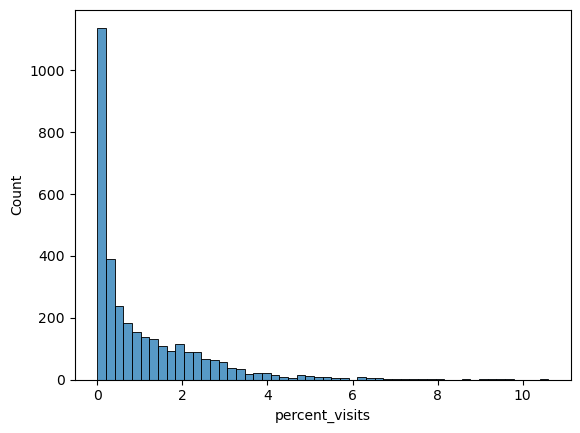

In [332]:
import seaborn as sns
sns.histplot(data=final, x="percent_visits")

### LSTM + Ensemble (gone up a bit better)
- 1) LSTM
- 2) Train on Residuals from LSTM from Random Forest
- 3) Average the accuracy level

In [219]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Train the LSTM model and make predictions
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

# Step 2: Get LSTM predictions on the training set
y_lstm_train_pred = lstm_model.predict(X_train)

# Flatten the LSTM predictions and y_train to ensure proper shape for RandomForest
y_lstm_train_pred = y_lstm_train_pred.flatten()
y_train = y_train.flatten()

# Step 3: Reshape X_train to 2D for RandomForest (flatten timesteps and features)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

# Train Random Forest on LSTM residuals
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_reshaped, y_train - y_lstm_train_pred)  # Train on LSTM residuals

# Step 4: Make predictions with both models on the test set

# LSTM predictions on the test set
y_lstm_test_pred = lstm_model.predict(X_test).flatten()  # Flatten the LSTM predictions

# Reshape X_test for RandomForest
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# RandomForest predictions on the test set
y_rf_test_pred = rf_model.predict(X_test_reshaped)

# Step 5: Combine predictions from LSTM and RandomForest
y_ensemble_pred = y_lstm_test_pred + y_rf_test_pred

# Evaluate the ensemble model
rmse = np.sqrt(mean_squared_error(y_test, y_ensemble_pred))
print(f"Ensemble RMSE: {rmse}")

Epoch 1/50
83/83 [==============================] - 2s 7ms/step - loss: 0.0390
Epoch 2/50
83/83 [==============================] - 1s 9ms/step - loss: 0.0206
Epoch 3/50
83/83 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 4/50
83/83 [==============================] - 1s 7ms/step - loss: 0.0179
Epoch 5/50
83/83 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 6/50
83/83 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 7/50
83/83 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 8/50
83/83 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 9/50
83/83 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 10/50
83/83 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 11/50
83/83 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 12/50
83/83 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 13/50
83/83 [==============================

### Save model as h5 format (for keras or tensor flow)

In [333]:
model.save('lstm_ver1.h5')

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### See prediction for all 48 states

In [334]:
from keras.models import load_model

# Load the saved LSTM model
lstm_model = load_model('lstm_ver1.h5')

In [51]:
state_predictions = preprocessor.predict_next_for_each_state(model, final)

# Display the predicted values for each state-pathogen pair
for state, prediction in state_predictions.items():
    print(f"Predicted next value for {state}: {prediction[0]}")

1/1 [==============================] - 0s 11ms/step
Predicted next value for colorado: [0.50654244]
Predicted next value for connecticut: [0.63774604]
Predicted next value for delaware: [0.56511676]
Predicted next value for district of columbia: [0.712379]
Predicted next value for florida: [0.64934033]
Predicted next value for georgia: [0.4283974]
Predicted next value for hawaii: [0.5402399]
Predicted next value for idaho: [0.4174797]
Predicted next value for illinois: [0.54283]
Predicted next value for indiana: [0.46831006]
Predicted next value for iowa: [0.35638073]
Predicted next value for kansas: [0.34315953]
Predicted next value for kentucky: [0.49380058]
Predicted next value for louisiana: [0.5151698]
Predicted next value for maine: [0.40177464]
Predicted next value for maryland: [0.49587357]
Predicted next value for massachusetts: [0.6854248]
Predicted next value for michigan: [0.5057277]
Predicted next value for minnesota: [0.38856205]
Predicted next value for mississippi: [0.4

In [108]:
state_pathogen_predictions = preprocessor.predict_next_for_each_state_and_pathogen(model, final)

# Display the predicted values for each state-pathogen pair
for (state, pathogen), prediction in state_pathogen_predictions.items():
    print(f"Predicted next value for {state} and {pathogen}: {prediction[0]}")

1/1 [==============================] - 0s 11ms/step
Predicted next value for alabama and COVID-19: [0.6600926]
Predicted next value for alabama and Influenza: [0.6600926]
Predicted next value for alabama and RSV: [0.6600926]
Predicted next value for alaska and COVID-19: [0.5138427]
Predicted next value for alaska and Influenza: [0.5552882]
Predicted next value for alaska and RSV: [0.5552882]
Predicted next value for arizona and COVID-19: [0.6762047]
Predicted next value for arizona and Influenza: [0.6041912]
Predicted next value for arizona and RSV: [0.6041912]
Predicted next value for arkansas and COVID-19: [0.6653361]
Predicted next value for arkansas and Influenza: [0.6653361]
Predicted next value for arkansas and RSV: [0.6653361]
Predicted next value for california and COVID-19: [0.6743004]
Predicted next value for california and Influenza: [0.55774397]
Predicted next value for california and RSV: [0.55774397]
Predicted next value for colorado and COVID-19: [0.6067445]
Predicted ne

### Compare Predictions

In [335]:
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

21/21 [==============================] - 0s 3ms/step


In [ ]:
# Prediction 1개일때만 
# y_train_pred = y_train_pred.reshape(-1)
# y_test_pred = y_test_pred.reshape(-1)

- Training | Test Separately

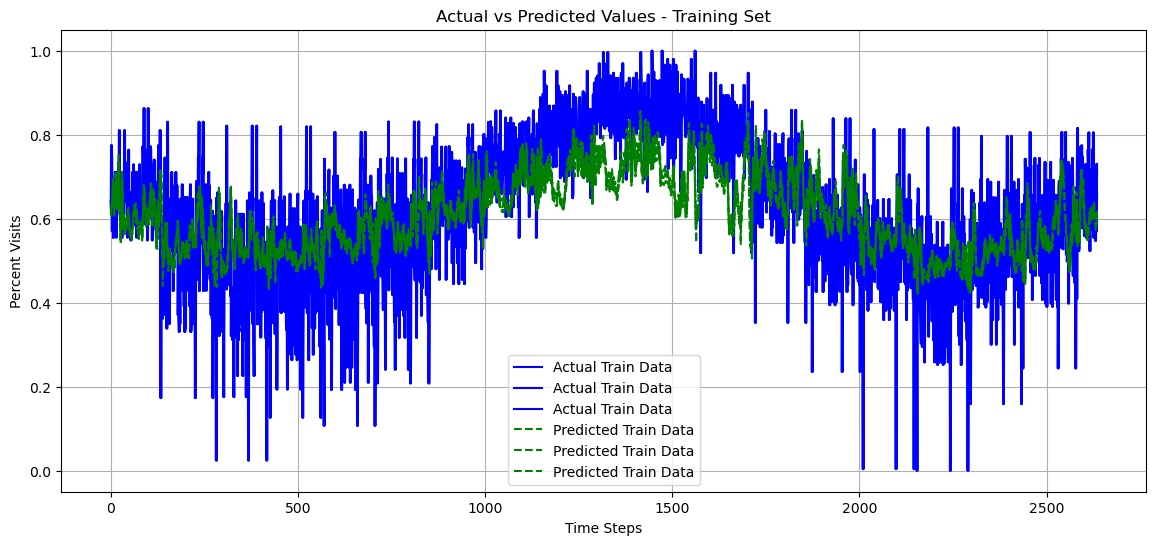

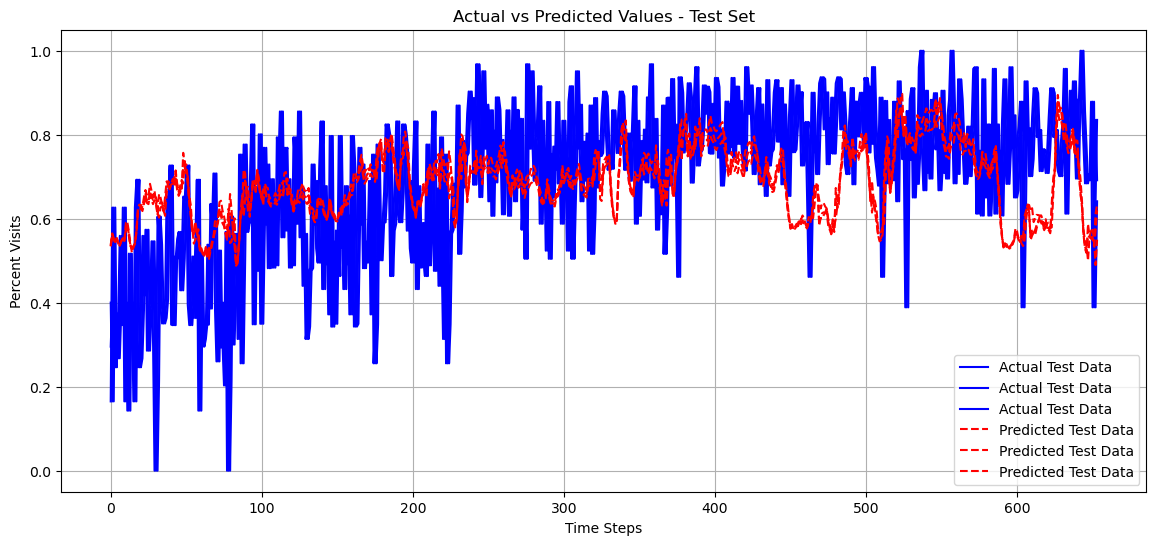

In [285]:
# Plot actual vs predicted for training data
plt.figure(figsize=(14, 6))
plt.plot(y_train, label='Actual Train Data', color='blue')
plt.plot(y_train_pred, label='Predicted Train Data', linestyle='--', color='green')
plt.title('Actual vs Predicted Values - Training Set')
plt.xlabel('Time Steps')
plt.ylabel('Percent Visits')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted for test data
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Test Data', color='blue')
plt.plot(y_test_pred, label='Predicted Test Data', linestyle='--', color='red')
plt.title('Actual vs Predicted Values - Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Percent Visits')
plt.legend()
plt.grid(True)
plt.show()

In [288]:
y_full_actual.shape

(3290, 3)

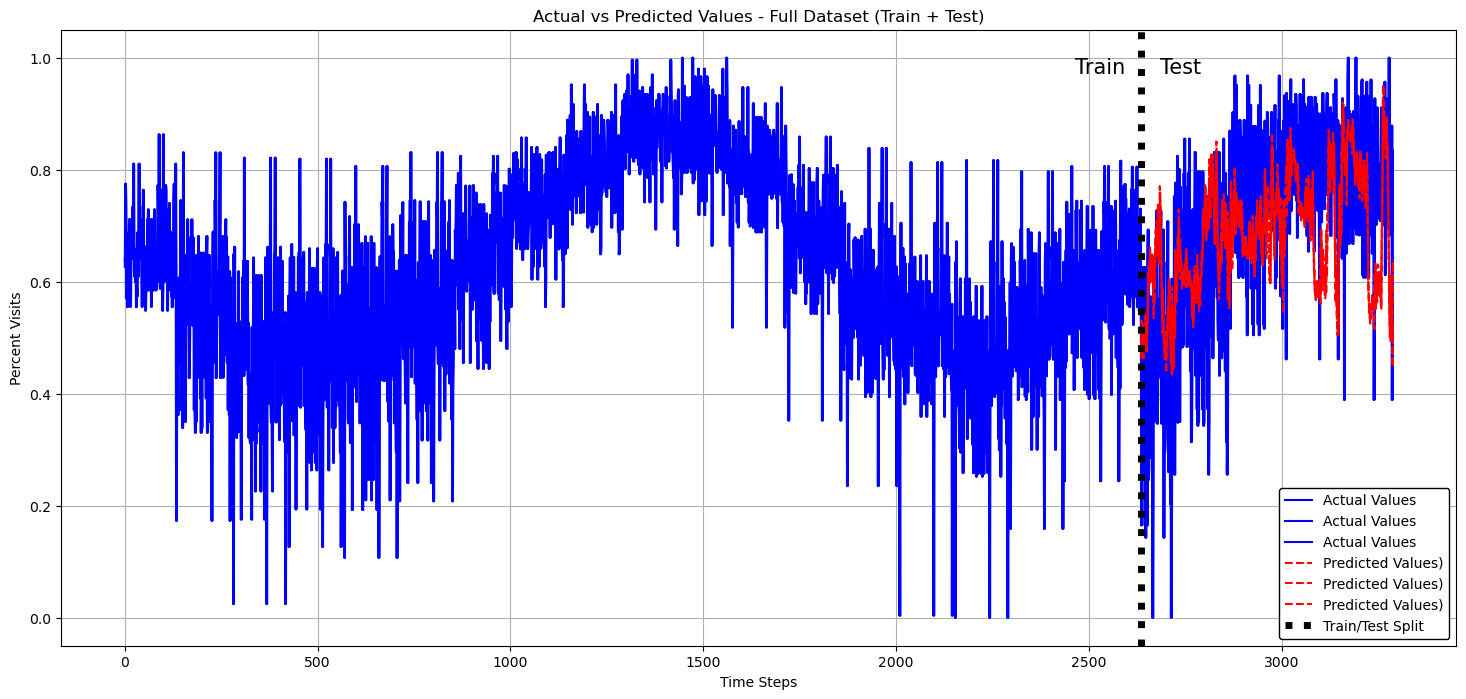

In [336]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine training and test actuals into one array
y_full_actual = np.concatenate([y_train, y_test], axis=0)
y_full_pred = np.concatenate([y_train_pred, y_test_pred], axis=0)
time_steps = np.arange(len(y_full_actual))
test_time_steps = time_steps[-len(y_test_pred):] 

# Plot the full actual vs predicted values
plt.figure(figsize=(18, 8))
plt.plot(time_steps, y_full_actual, label='Actual Values', color='blue')
plt.plot(test_time_steps, y_test_pred, label='Predicted Values)', linestyle='--', color='red')
plt.axvline(x=len(y_train)-1, color='black', linestyle=':', linewidth=5, label='Train/Test Split')

# Legend
split_index = len(y_full_actual) - len(y_test_pred) - 1
max_actual_value = np.max(y_full_actual)
plt.text(split_index - 40, max_actual_value, 'Train', verticalalignment='top', horizontalalignment='right', fontsize=15)
plt.text(split_index + 50,max_actual_value, 'Test', verticalalignment='top', horizontalalignment='left', fontsize=15)

# Titles and labels
plt.title('Actual vs Predicted Values - Full Dataset (Train + Test)')
plt.xlabel('Time Steps')
plt.ylabel('Percent Visits')
legend = plt.legend(loc='best', fancybox=True, framealpha=1, edgecolor='black')
legend.get_frame().set_linewidth(1)  # Adjust thickness of the legend box

plt.grid(True)
plt.show()

- Dense(3)

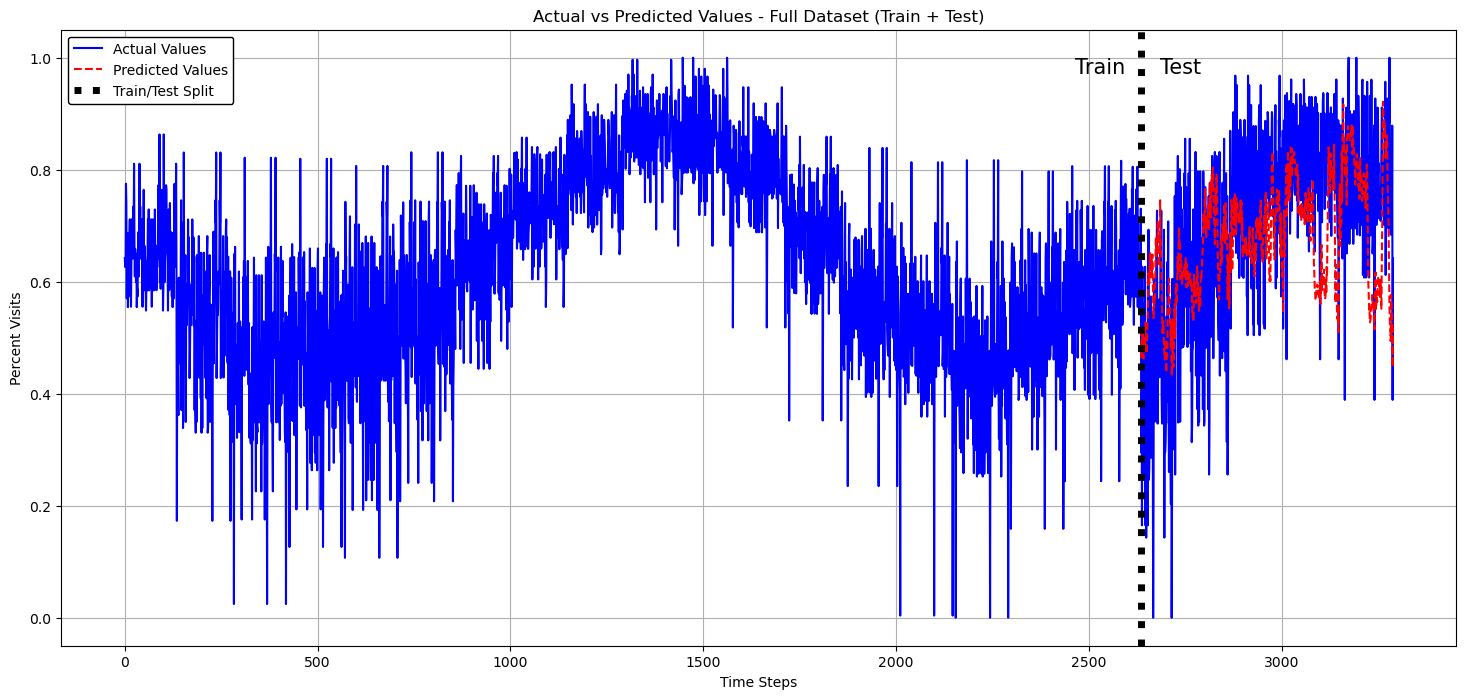

In [337]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine training and test actuals into one array
y_full_actual = np.concatenate([y_train, y_test], axis=0)
y_full_pred = np.concatenate([y_train_pred, y_test_pred], axis=0)
time_steps = np.arange(len(y_full_actual))
test_time_steps = time_steps[-len(y_test_pred):]

# For text positioning, we can either use the max of one of the columns (e.g., first step)
max_y_actual = np.max(y_full_actual[:, 0]) if y_full_actual.ndim > 1 else np.max(y_full_actual)  # Handling multi-step predictions

# Plot the full actual vs predicted values
plt.figure(figsize=(18, 8))
plt.plot(time_steps, y_full_actual[:, 0] if y_full_actual.ndim > 1 else y_full_actual, label='Actual Values', color='blue')
plt.plot(test_time_steps, y_test_pred[:, 0] if y_test_pred.ndim > 1 else y_test_pred, label='Predicted Values', linestyle='--', color='red')
plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', linewidth=5, label='Train/Test Split')

# Legend
split_index = len(y_full_actual) - len(y_test_pred) - 1
plt.text(split_index - 40, max_y_actual, 'Train', verticalalignment='top', horizontalalignment='right', fontsize=15)
plt.text(split_index + 50, max_y_actual, 'Test', verticalalignment='top', horizontalalignment='left', fontsize=15)

# Titles and labels
plt.title('Actual vs Predicted Values - Full Dataset (Train + Test)')
plt.xlabel('Time Steps')
plt.ylabel('Percent Visits')
legend = plt.legend(loc='best', fancybox=True, framealpha=1, edgecolor='black')
legend.get_frame().set_linewidth(1)  # Adjust thickness of the legend box

plt.grid(True)
plt.show()


In [293]:
y_test_pred.shape

(654, 3)

In [178]:
23*0.2*48*3

662.4000000000001

In [ ]:
def add_forecast_column(model, df, preprocessor, target_column='percent_visits', steps=2):
    # separate, forecasting column names 
    for step in range(steps):
        df[f'forecast_{step + 1}'] = np.nan

    for step in range(steps): 
        y_pred = model.predict(X_test)  

        df.loc[df.index[-len(y_test):], f'forecast_{step + 1}'] = y_pred.flatten()

        X_test = np.roll(X_test, shift=-1, axis=1)  # Shift the data to include the next forecast
        X_test[:, -1, -1] = y_pred.flatten()  # Add the predicted values to the input for the next step
    
    return df

- Dense(3) Forecast

In [341]:
last_data.shape

(429, 20)

In [342]:
X_last.shape

(422, 5, 16)

In [343]:
last_sequence.shape

(422, 5, 16)

In [360]:
import pandas as pd
import numpy as np

# Get the last 3 months of data (2024-06, 2024-07, 2024-08)
last_dates = pd.to_datetime(final['Date']).sort_values().unique()[-3:]
last_data = final[final['Date'].isin(last_dates)]

# Prepare the data using the preprocessor
X_last, _ = preprocessor.prepare_data(last_data, target_column='percent_visits')

# Check the shape of X_last (should be multiple samples, 5 timesteps, 16 features)
print("Shape of X_last:", X_last.shape)  # Expected: (multiple rows, 5 timesteps, features)

# Predicting the next 3 months ahead for all rows in one go
forecasted_values = lstm_model.predict(X_last)  # This will directly give the 3-month forecast for all rows

# Each row will have 3 predicted values (one for each future month)
print(f"Forecasted values shape: {forecasted_values.shape}")  # Should be (number_of_rows, 3)
forecasted_values

Shape of X_last: (422, 5, 16)
14/14 [==============================] - 0s 12ms/step


/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_1694/1541895094.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.numerical_features] = self.scaler.fit_transform(df[self.numerical_features])
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_1694/1541895094.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = self.label_encoders[col].fit_transform(df[col])
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_1694/1541895094.py:33: SettingWithCopyWarning: 
A valu

Forecasted values shape: (422, 3)


array([[0.41252705, 0.43383157, 0.45711926],
       [0.40453476, 0.43978107, 0.46655422],
       [0.53615284, 0.5522698 , 0.5785431 ],
       ...,
       [0.80298656, 0.8019346 , 0.80558217],
       [0.79855776, 0.79770684, 0.8007169 ],
       [0.7777438 , 0.77696943, 0.77813894]], dtype=float32)

In [440]:
final_dataset = pd.read_csv("Merged_final.csv", index_col = 0)

In [354]:
df

Date  Pathogen                 State  percent_visits     Status  \
2887 2024-06-01  COVID-19              delaware            0.52  Reporting   
2888 2024-06-01  COVID-19  district of columbia            0.68  Reporting   
2889 2024-06-01  COVID-19               florida            1.56  Reporting   
2890 2024-06-01  COVID-19               georgia            0.36  Reporting   
2891 2024-06-01  COVID-19                hawaii            4.48  Reporting   
...         ...       ...                   ...             ...        ...   
3304 2024-08-01       RSV               vermont            0.00  Reporting   
3305 2024-08-01       RSV              virginia            0.00  Reporting   
3306 2024-08-01       RSV            washington            0.00  Reporting   
3307 2024-08-01       RSV         west virginia            0.00  Reporting   
3308 2024-08-01       RSV             wisconsin            0.00  Reporting   

     trend_on_date recent_trend  Precipitation   Humidity   Snowfall  \
2887     No Change    No Change          165.2  65.554118   0.000000   
2888    Increasing    No Change           29.4  65.554118   0.000000   
2889    Increasing   Decreasing          109.1  65.554118   0.000000   
2890    Increasing    No Change           71.4  65.554118   0.000000   
2891    Increasing    No Change           98.6  65.554118  58.230539   
...            ...          ...            ...        ...        ...   
3304     No Change    No Change          110.4  65.554118   0.000000   
3305     No Change    No Change           87.1  65.554118   0.000000   
3306     No Change    No Change            6.6  65.554118   0.000000   
3307     No Change    No Change          103.8  65.554118   0.000000   
3308     No Change    No Change           74.2  65.554118   0.000000   

      Temperature  Population Staying at Home  Population Not Staying at Home  \
2887        23.59                98523.750000                   388358.250000   
2888        26.50               161401.083333                   544347.916667   
2889        28.12               126036.497549                   505661.649510   
2890        27.78                25644.014583                   107073.772917   
2891        24.56               132220.166667                   434111.433333   
...           ...                         ...                             ...   
3304        21.36                16458.644444                    66739.888889   
3305        26.03                25801.027363                   101594.778607   
3306        22.05                85402.941667                   295341.708333   
3307        21.61                13062.151786                    50943.098214   
3308        21.59                30272.641553                   129246.098174   

      Number of Trips  GDP  Unemployment Rate  month  year  \
2887     1.832407e+06  3.1                4.0      6  2024   
2888     3.580896e+06  1.3                5.4      6  2024   
2889     2.309314e+06  3.0                3.3      6  2024   
2890     4.800334e+05  2.3                3.3      6  2024   
2891     2.353900e+06  1.9                2.9      6  2024   
...               ...  ...                ...    ...   ...   
3304     3.650684e+05  1.2                2.2      8  2024   
3305     5.492021e+05  2.1                2.8      8  2024   
3306     1.400404e+06  2.0                4.8      8  2024   
3307     2.473598e+05  1.1                4.2      8  2024   
3308     6.780688e+05  0.5                2.9      8  2024   

      percent_visits_rolling_mean_3  percent_visits_rolling_mean_6  
2887                       0.680000                       0.816667  
2888                       0.646667                       0.696667  
2889                       0.920000                       0.886667  
2890                       0.866667                       0.773333  
2891                       2.133333                       1.390000  
...                             ...                            ...  
3304    

In [361]:
forecasted_values = np.array(forecasted_values).T 
forecasted_values

array([[0.41252705, 0.40453476, 0.53615284, ..., 0.80298656, 0.79855776,
        0.7777438 ],
       [0.43383157, 0.43978107, 0.5522698 , ..., 0.8019346 , 0.79770684,
        0.77696943],
       [0.45711926, 0.46655422, 0.5785431 , ..., 0.80558217, 0.8007169 ,
        0.77813894]], dtype=float32)

In [470]:
# Convert forecasted values to a DataFrame
forecasted_values_df = pd.DataFrame(np.array(forecasted_values).T)  # Transpose to match the number of rows

# Add forecasted dates (e.g., 2024-09 to 2024-11)
forecasted_dates = ['2024-09-01', '2024-10-01', '2024-11-01']
forecasted_values_df.columns = forecasted_dates
forecasted_values_df

# the last 422 rows 
df = df.reset_index(drop=True)
forecasted_values_df
df_with_forecasts = pd.concat([df, forecasted_values_df], axis=1)
df_with_forecasts

Date  Pathogen                 State  percent_visits     Status  \
0   2024-06-01  COVID-19              delaware            0.52  Reporting   
1   2024-06-01  COVID-19  district of columbia            0.68  Reporting   
2   2024-06-01  COVID-19               florida            1.56  Reporting   
3   2024-06-01  COVID-19               georgia            0.36  Reporting   
4   2024-06-01  COVID-19                hawaii            4.48  Reporting   
..         ...       ...                   ...             ...        ...   
417 2024-08-01       RSV               vermont            0.00  Reporting   
418 2024-08-01       RSV              virginia            0.00  Reporting   
419 2024-08-01       RSV            washington            0.00  Reporting   
420 2024-08-01       RSV         west virginia            0.00  Reporting   
421 2024-08-01       RSV             wisconsin            0.00  Reporting   

    trend_on_date recent_trend  Precipitation   Humidity   Snowfall  ...  \
0       No Change    No Change          165.2  65.554118   0.000000  ...   
1      Increasing    No Change           29.4  65.554118   0.000000  ...   
2      Increasing   Decreasing          109.1  65.554118   0.000000  ...   
3      Increasing    No Change           71.4  65.554118   0.000000  ...   
4      Increasing    No Change           98.6  65.554118  58.230539  ...   
..            ...          ...            ...        ...        ...  ...   
417     No Change    No Change          110.4  65.554118   0.000000  ...   
418     No Change    No Change           87.1  65.554118   0.000000  ...   
419     No Change    No Change            6.6  65.554118   0.000000  ...   
420     No Change    No Change          103.8  65.554118   0.000000  ...   
421     No Change    No Change           74.2  65.554118   0.000000  ...   

     Number of Trips  GDP  Unemployment Rate  month  year  \
0       1.832407e+06  3.1                4.0      6  2024   
1       3.580896e+06  1.3                5.4      6  2024   
2       2.309314e+06  3.0                3.3      6  2024   
3       4.800334e+05  2.3                3.3      6  2024   
4       2.353900e+06  1.9                2.9      6  2024   
..               ...  ...                ...    ...   ...   
417     3.650684e+05  1.2                2.2      8  2024   
418     5.492021e+05  2.1                2.8      8  2024   
419     1.400404e+06  2.0                4.8      8  2024   
420     2.473598e+05  1.1                4.2      8  2024   
421     6.780688e+05  0.5                2.9      8  2024   

     percent_visits_rolling_mean_3  percent_visits_rolling_mean_6  2024-09-01  \
0                         0.680000                       0.816667    0.412527   
1                         0.646667                       0.696667    0.404535   
2                         0.920000                       0.886667    0.536153   
3                         0.866667                       0.773333    0.554813   
4                         2.133333                       1.390000    0.568226   
..                             ...                            ...         ...   
417                       0.000000                       0.000000    0.797816   
418                       0.000000                       0.000000    0.818081   
419                       0.000000                       0.000000    0.802987   
420                       0.000000                       0.000000    0.798558   
421                       0.000000                       0.000000    0.777744   

     2024-10-01  2024-11-01  
0      0.433832    0.457119  
1      0.439781    0.466554  
2      0.552270    0.578543  
3      0.571054    0.593050  
4      0.585631    0.611506  
..          ...         ...  
417    0.799024    0.802640  
418    0.818431    0.822440  
419    0.801935    0.805582  
420    0.797707    0.800717  
421    0.776969    0.778139  

[422 rows x 23 columns]

In [428]:
df_with_forecasts.columns

Index(['Date', 'Pathogen', 'State', 'percent_visits', 'Status',
       'trend_on_date', 'recent_trend', 'Precipitation', 'Humidity',
       'Snowfall', 'Temperature', 'Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips', 'GDP',
       'Unemployment Rate', 'month', 'year', 'percent_visits_rolling_mean_3',
       'percent_visits_rolling_mean_6', '2024-09-01', '2024-10-01',
       '2024-11-01'],
      dtype='object')

In [471]:
forecast_melted = pd.melt(df_with_forecasts, 
                          id_vars=['Date', 'Pathogen', 'State', 'percent_visits', 'Status',
                                   'trend_on_date', 'recent_trend', 'Precipitation', 'Humidity',
                                   'Snowfall', 'Temperature', 'Population Staying at Home',
                                   'Population Not Staying at Home', 'Number of Trips', 'GDP',
                                   'Unemployment Rate', 'month', 'year', 'percent_visits_rolling_mean_3',
                                   'percent_visits_rolling_mean_6'],
                          value_vars=['2024-09-01', '2024-10-01', '2024-11-01'], 
                          var_name='forecasted_date', 
                          value_name='forecasted_percent_visits')

imaginary = forecast_melted.drop(columns=['Date', 'percent_visits'])
imaginary.rename(columns={'forecasted_date': 'Date', 'forecasted_percent_visits': 'percent_visits'}, inplace=True)

combined_df = pd.concat([imaginary, df], axis=0, ignore_index=True)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df[df.columns]
combined_df.sort_values(by=['Date', 'State'], ascending=True)

Date   Pathogen    State  percent_visits     Status trend_on_date  \
1307 2024-06-01  Influenza  alabama        0.240000  Reporting     No Change   
1355 2024-06-01        RSV  alabama        0.000000  Reporting     No Change   
1308 2024-06-01  Influenza   alaska        0.720000  Reporting    Decreasing   
1356 2024-06-01        RSV   alaska        0.000000  Reporting     No Change   
1309 2024-06-01  Influenza  arizona        0.480000  Reporting     No Change   
...         ...        ...      ...             ...        ...           ...   
932  2024-11-01  Influenza  wyoming        0.587932  Reporting     No Change   
980  2024-11-01        RSV  wyoming        0.543742  Reporting     No Change   
1028 2024-11-01   COVID-19  wyoming        0.495447  Reporting     No Change   
1076 2024-11-01  Influenza  wyoming        0.734937  Reporting     No Change   
1124 2024-11-01        RSV  wyoming        0.665321  Reporting     No Change   

     recent_trend  Precipitation   Humidity   Snowfall  Temperature  \
1307    No Change           67.3  65.554118   0.000000        27.09   
1355    No Change           67.3  65.554118   0.000000        27.09   
1308    No Change           38.6  65.554118  58.230539        16.17   
1356    No Change           38.6  65.554118  58.230539        16.17   
1309    No Change           31.3  65.554118   0.000000        19.30   
...           ...            ...        ...        ...          ...   
932     No Change           20.4  65.554118   0.000000        19.08   
980     No Change           20.4  65.554118   0.000000        19.08   
1028    No Change           13.7  65.554118   0.000000        21.19   
1076    No Change           13.7  65.554118   0.000000        21.19   
1124    No Change           13.7  65.554118   0.000000        21.19   

      Population Staying at Home  Population Not Staying at Home  \
1307                26219.245098                   117992.078431   
1355                26219.245098                   117992.078431   
1308                14294.681159                    48595.927536   
1356                14294.681159                    48595.927536   
1309               202046.802083                   707792.822917   
...                          ...                             ...   
932                 10276.888889                    37953.027778   
980                 10276.888889                    37953.027778   
1028                10276.888889                    37953.027778   
1076                10276.888889                    37953.027778   
1124                10276.888889                    37953.027778   

      Number of Trips  GDP  Unemployment Rate  month  year  \
1307     5.000292e+05  2.9                2.9      6  2024   
1355     5.000292e+05  2.9                2.9      6  2024   
1308     2.936740e+05  2.6                4.5      6  2024   
1356     2.936740e+05  2.6                4.5      6  2024   
1309     3.161815e+06  3.2                3.3      6  2024   
...               ...  ...                ...    ...   ...   
932      2.209296e+05  1.4                2.9      6  2024   
980      2.209296e+05  1.4                2.9      6  2024   
1028     2.209296e+05  1.4                2.9      7  2024   
1076     2.209296e+05  1.4                2.9      7  2024   
1124     2.209296e+05  1.4                2.9      7  2024   

      percent_visits_rolling_mean_3  percent_visits_rolling_mean_6  
1307                       0.500000                       0.660000  
1355                       0.100000                       0.136667  
1308                       0.586667                       0.666667  
1356                       0.073333                       0.116667  
1309                       0.480000                       0.520000  
...                             ...                            ...  
932                        0.113333                       0.146667  
980                        0.013333                       0.010000  
1028          

In [445]:
# month & year 
final_dataset
final_dataset['Date'] = pd.to_datetime(final_dataset['Date'], errors='coerce')
final_dataset['month'] = final_dataset['Date'].dt.month
final_dataset['year'] = final_dataset['Date'].dt.year

# Rolling averages of Y
final_dataset['percent_visits_rolling_mean_3'] = final_dataset['percent_visits'].rolling(window=3).mean()
final_dataset['percent_visits_rolling_mean_6'] = final_dataset['percent_visits'].rolling(window=6).mean()
final_dataset.dropna(inplace=True)

In [455]:
final_dataset = final_dataset[:-422]

In [458]:
combined_df = pd.concat([combined_df, final_dataset], axis=0, ignore_index=True)
combined_df.sort_values(by='Date', ascending=True)

Date  Pathogen          State  percent_visits     Status  \
1814 2022-10-01       RSV         oregon        0.180000  Reporting   
1723 2022-10-01  COVID-19          texas        0.780000  Reporting   
1724 2022-10-01  COVID-19           utah        1.880000  Reporting   
1725 2022-10-01  COVID-19        vermont        3.880000  Reporting   
1726 2022-10-01  COVID-19       virginia        1.920000  Reporting   
...         ...       ...            ...             ...        ...   
980  2024-11-01       RSV        wyoming        0.543742  Reporting   
979  2024-11-01       RSV      wisconsin        0.543818  Reporting   
978  2024-11-01       RSV  west virginia        0.549055  Reporting   
1002 2024-11-01  COVID-19  massachusetts        0.572764  Reporting   
850  2024-11-01  COVID-19       illinois        0.674558  Reporting   

     trend_on_date recent_trend  Precipitation   Humidity  Snowfall  \
1814    Increasing    No Change           80.8  70.000000       0.0   
1723    Decreasing   Decreasing           55.3  56.000000       0.0   
1724    Decreasing    No Change           20.5  42.000000       0.0   
1725     No Change    No Change           66.7  65.554118       0.0   
1726    Decreasing   Increasing           50.8  75.000000       0.0   
...            ...          ...            ...        ...       ...   
980      No Change    No Change           20.4  65.554118       0.0   
979     Decreasing    No Change          223.9  65.554118       0.0   
978     Decreasing    No Change           48.6  65.554118       0.0   
1002    Increasing    No Change           35.6  65.554118       0.0   
850     Increasing   Increasing          113.7  65.554118       0.0   

      Temperature  Population Staying at Home  Population Not Staying at Home  \
1814        16.34                51826.486486                   176159.297297   
1723        22.39                43794.304621                   185888.426567   
1724        14.43                45995.410753                   167735.122581   
1725        11.27                16432.746237                    66765.787097   
1726        15.64                25583.304044                   101812.501926   
...           ...                         ...                             ...   
980         19.08                10276.888889                    37953.027778   
979         21.35                30272.641553                   129246.098174   
978         20.93                13062.151786                    50943.098214   
1002        24.45               206457.611111                   712542.788889   
850         23.15                55062.527508                   190992.249191   

      Number of Trips  GDP  Unemployment Rate  month  year  \
1814     8.457451e+05  1.1                4.2     10  2022   
1723     8.476791e+05  8.9                4.0     10  2022   
1724     8.666108e+05  3.2                2.5     10  2022   
1725     3.413516e+05  6.6                2.5     10  2022   
1726     5.171337e+05  3.0                3.0     10  2022   
...               ...  ...                ...    ...   ...   
980      2.209296e+05  1.4                2.9      6  2024   
979      6.780688e+05  0.5                2.9      6  2024   
978      2.473598e+05  1.1                4.1      6  2024   
1002     4.488259e+06  1.0                3.5      7  2024   
850      1.030638e+06 -1.3                5.0      6  2024   

      percent_visits_rolling_mean_3  percent_visits_rolling_mean_6  
1814                       0.506667                       0.653333  
1723                       1.073333                       1.563333  
1724                       1.286667                       1.546667  
1725                       2.180000                       1.860000  
1726                       2.560000                       1.816667  
...                             ...                            ...  
980                        0.013333                       0.010000  
979                        0.000000

### Forecast for Top 5 States: Underfitting
- not enough distinctive features to differentiate between two viruses (RSV & Influenza)
- Underfitting: your model is just too simple - not capturing the complex relationships.

In [469]:
combined_df[(combined_df['State'] == 'california') & (combined_df['Date'] > '2024-09-01')]


Date   Pathogen       State  percent_visits     Status  \
467  2024-10-01  Influenza  california        0.611710  Reporting   
515  2024-10-01        RSV  california        0.613711  Reporting   
563  2024-10-01   COVID-19  california        0.590686  Reporting   
611  2024-10-01  Influenza  california        0.643654  Reporting   
659  2024-10-01        RSV  california        0.738504  Reporting   
707  2024-10-01   COVID-19  california        0.618926  Reporting   
754  2024-10-01  Influenza  california        0.596537  Reporting   
801  2024-10-01        RSV  california        0.833493  Reporting   
889  2024-11-01  Influenza  california        0.618110  Reporting   
937  2024-11-01        RSV  california        0.621751  Reporting   
985  2024-11-01   COVID-19  california        0.591061  Reporting   
1033 2024-11-01  Influenza  california        0.650376  Reporting   
1081 2024-11-01        RSV  california        0.754066  Reporting   
1129 2024-11-01   COVID-19  california        0.620229  Reporting   
1176 2024-11-01  Influenza  california        0.594754  Reporting   
1223 2024-11-01        RSV  california        0.847167  Reporting   

     trend_on_date recent_trend  Precipitation   Humidity   Snowfall  \
467     Decreasing    No Change            0.0  65.554118  58.230539   
515      No Change    No Change            0.0  65.554118  58.230539   
563     Increasing   Decreasing            0.0  65.554118  58.230539   
611     Decreasing    No Change            0.0  65.554118  58.230539   
659      No Change    No Change            0.0  65.554118  58.230539   
707     Increasing   Decreasing            0.0  65.554118  58.230539   
754     Decreasing    No Change            0.0  65.554118  58.230539   
801      No Change    No Change            0.0  65.554118  58.230539   
889     Decreasing    No Change            0.0  65.554118  58.230539   
937      No Change    No Change            0.0  65.554118  58.230539   
985     Increasing   Decreasing            0.0  65.554118  58.230539   
1033    Decreasing    No Change            0.0  65.554118  58.230539   
1081     No Change    No Change            0.0  65.554118  58.230539   
1129    Increasing   Decreasing            0.0  65.554118  58.230539   
1176    Decreasing    No Change            0.0  65.554118  58.230539   
1223     No Change    No Change            0.0  65.554118  58.230539   

      Temperature  Population Staying at Home  Population Not Staying at Home  \
467         21.05               312032.638418                    1.027365e+06   
515         21.05               312032.638418                    1.027365e+06   
563         23.63               312032.638418                    1.027365e+06   
611         23.63               312032.638418                    1.027365e+06   
659         23.63               312032.638418                    1.027365e+06   
707         24.16               312032.638418                    1.027365e+06   
754         24.16               312032.638418                    1.027365e+06   
801         24.16               312032.638418                    1.027365e+06   
889         21.05               312032.638418                    1.027365e+06   
937         21.05               312032.638418                    1.027365e+06   
985         23.63               312032.638418                    1.027365e+06   
1033        23.63               312032.638418                    1.027365e+06   
1081        23.63               312032.638418                    1.027365e+06   
1129        24.16               312032.638418                    1.027365e+06   
1176        24.16               312032.638418                    1.027365e+06   
1223        24.16               312032.638418                    1.027365e+06   

      Number of Trips  GDP  Unemployment Rate  month  year  \
467      5.138356e+06  1.2                5.2      6  2024   
515      5.138356e+06  1.2                5.2      6  2024   
563      5.138356e+06  1.2                5.2   

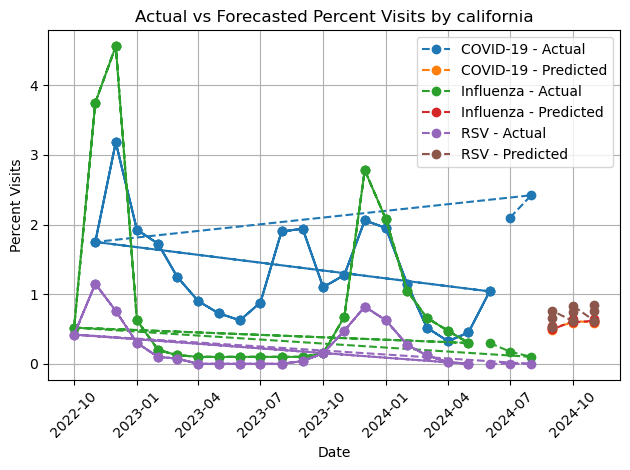

In [466]:
states = ['california']
viruses = ['COVID-19', 'Influenza', 'RSV']  # Example of virus categories

# Filter data for the selected states
selected_states_data = combined_df[combined_df['State'].isin(states)]
selected_states_data

for state in states:
    for virus in viruses:
        grouped_data = combined_df[(combined_df['State'] == state) & (combined_df['Pathogen'] == virus)]
        # actual 
        actual = grouped_data[grouped_data['Date'] < '2024-09-01'] 
        predict = grouped_data[grouped_data['Date'] >= '2024-09-01'] 
        plt.plot(actual['Date'], actual['percent_visits'], '--', label=f'{virus} - Actual', marker='o')
        plt.plot(predict['Date'], predict['percent_visits'], '--', label=f'{virus} - Predicted', marker='o')

    plt.title(f'Actual vs Forecasted Percent Visits by {state}')
    plt.xlabel('Date')
    plt.ylabel('Percent Visits')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- predict 1일때

In [476]:
X, y = preprocessor.prepare_data(final, target_column='percent_visits')

# Now, filter X and y for specific states and pathogens
for state in states:
    for virus in viruses:
        # Filter based on state and virus
        state_virus_data = final[(final['State'] == state) & (final['Pathogen'] == virus)]
        
        # Extract the matching rows from X and y
        X_state_virus = X[state_virus_data.index]
        y_state_virus = y[state_virus_data.index]

        # Make predictions using the trained LSTM model
        forecast = []
        current_input = X_state_virus[-1].reshape(1, X_state_virus.shape[1], X_state_virus.shape[2])  # Get the last sequence

        for _ in range(6):  # Forecast 6 steps ahead
            predicted_value = lstm_model.predict(current_input)[0, 0]  # Predict the next step
            forecast.append(predicted_value)
            # Update current input with the new forecasted value (shift window)
            current_input = np.roll(current_input, -1, axis=1)
            current_input[0, -1, 0] = predicted_value  # Add the new forecasted value

        # Store the forecast for this state-virus pair
        forecasts[(state, virus)] = forecast

IndexError: index -1 is out of bounds for axis 0 with size 0

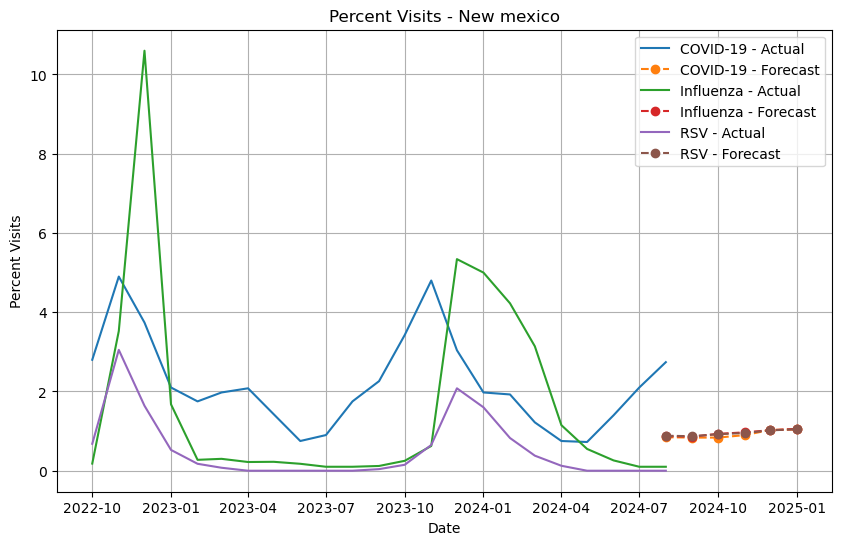

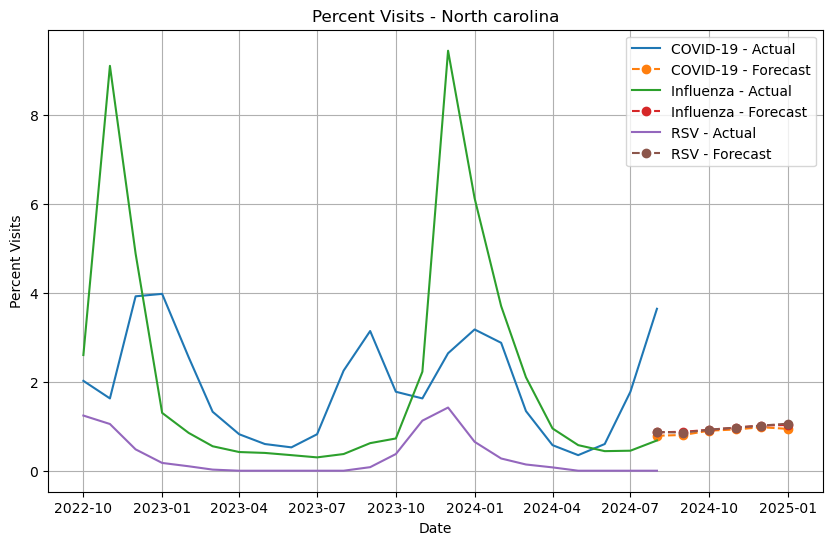

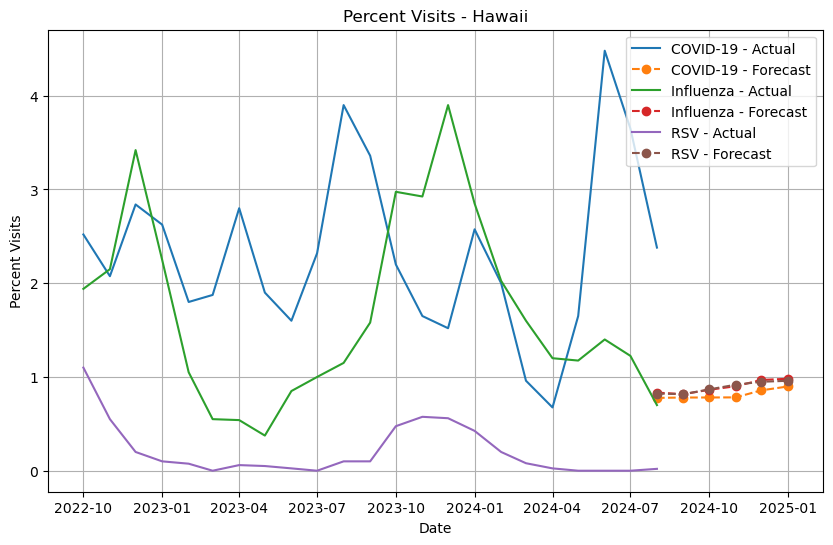

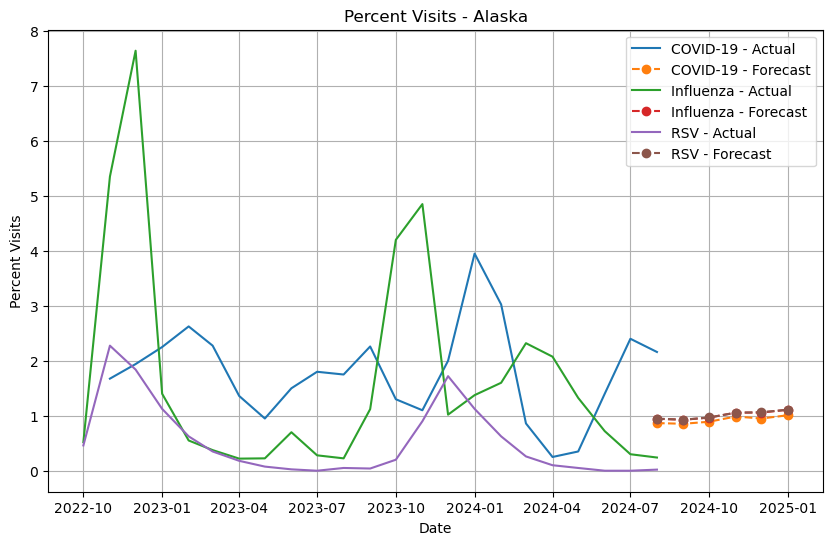

In [386]:
import matplotlib.pyplot as plt

for state in states:
    plt.figure(figsize=(10, 6))
    
    for virus in viruses:
        # Plot the original data
        state_virus_data = selected_states_data[(selected_states_data['State'] == state) & 
                                                (selected_states_data['Pathogen'] == virus)]
        plt.plot(state_virus_data['Date'], state_virus_data['percent_visits'], label=f'{virus} - Actual')
        
        # Plot the forecasted data with generated future dates
        last_known_date = state_virus_data['Date'].iloc[-2]
        forecast_dates = pd.date_range(last_known_date, periods=7, freq='MS')[1:]  # Generate future dates
        plt.plot(forecast_dates, forecasts[(state, virus)], '--', label=f'{virus} - Forecast', marker='o')
    
    plt.title(f'Percent Visits - {state.capitalize()}')
    plt.xlabel('Date')
    plt.ylabel('Percent Visits')
    plt.legend()
    plt.grid(True)
    plt.show()